In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from model_workflow import train_model
import joblib


In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("temps-demo").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [5]:
import json
with open("./config.json") as file:
    config_data = json.load(file)


In [6]:
# df_data = pd.DataFrame()
# for basin in config_data.keys():

#     reservoirs_of_interest = tuple(config_data[basin]["reservoirs_of_interest"])
#     input_features = config_data[basin]["input_features"]
#     target_feature = config_data[basin]["target_features"]
#     categorical = config_data[basin]["categorical_feature"]

#     dataset_sql_table = spark.table("produced.vw_well_completions_merged")
#     dataset_sql_table.createOrReplaceTempView("dataset_table")

#     data_df = spark.sql(
#     f"""select API10, API14, WellName, LatitudeBHWGS84, LatitudeSHWGS84, LongitudeBHWGS84, LongitudeSHWGS84,
#     CompletionDate, CompletionCost_USDMM, DrillCost_USDMM, FacilitiesCost_USDMM, BasinQuantum,
#     TotalWellCost_USDMM, Proppant_LBSPerFT, Fluid_BBLPerFT, TVD_FT, LateralLength_FT, OperatorGold, ReservoirGoldConsolidated
#     from dataset_table
#     where CompletionDate>'2014-01-01'
#     and HoleDirection='H'
#     and TotalWellCost_USDMM is not null
#     and BasinQuantum='{basin}'
#     and ReservoirGoldConsolidated in {reservoirs_of_interest}"""
#     ).toPandas()

#     n_samples = 100
#     res_in_df = [value for value in reservoirs_of_interest if value in list(data_df["ReservoirGoldConsolidated"].unique())]
#     n_reservoirs = len(res_in_df)
#     samples_per_reservoir = int(n_samples / n_reservoirs)

#     data_df["LatitudeMP"] = data_df.apply(
#     lambda x: np.nanmean([x["LatitudeBHWGS84"], x["LatitudeSHWGS84"]]), axis=1
#     )
#     data_df["LongitudeMP"] = data_df.apply(
#     lambda x: np.nanmean([x["LongitudeBHWGS84"], x["LongitudeSHWGS84"]]), axis=1
#     )

#     df_basin = pd.DataFrame()
#     for reservoir in res_in_df:
#         df_temp = data_df[data_df["ReservoirGoldConsolidated"] == reservoir][[categorical, "BasinQuantum"] + input_features + target_feature]
#         df_basin = pd.concat([df_basin, df_temp.sample(samples_per_reservoir, random_state=42)])
#         df_basin = df_basin[(df_basin["LateralLength_FT"] > 1000) & (df_basin["Fluid_BBLPerFT"] > 10) & (df_basin["Proppant_LBSPerFT"] > 1000)]
#         df_basin.dropna(inplace=True)
#     df_data = pd.concat([df_data, df_basin])
#     print(basin)
    
# df_data.reset_index(drop=True, inplace=True)
# df_data.to_csv("testing_data.csv")

In [7]:
import json
with open("./config.json") as file:
    config_data = json.load(file)

basin_of_interest = "ANADARKO EAST"
reservoirs_of_interest = tuple(config_data[basin_of_interest]["reservoirs_of_interest"])

In [8]:
print(config_data.get('filtering_config'))

None


In [18]:
import json
with open("./config.json") as file:
    config_data = json.load(file)

basins_of_interest = list(config_data.keys())
for basin_of_interest in ["ANADARKO EAST"]:
  reservoirs_of_interest = config_data[basin_of_interest]["reservoirs_of_interest"]
  
  model_performance, model_pipeline,operator_list, meta_data, model_params, training_model = train_model(
  basin_of_interest=basin_of_interest, 
  reservoirs=reservoirs_of_interest, 
  config_param=config_data, 
  spark=spark
)
  joblib.dump(model_pipeline, f"pipeline_{basin_of_interest.lower()}.pickle")

  with open(f"error_results_{basin_of_interest.lower()}.json", "w") as outfile:
      json.dump(model_performance["error_results"], outfile)
  print(f"{basin_of_interest} Done")

ANADARKO EAST Done


In [19]:
with open(f"operator_list_{basin_of_interest.lower()}.json", "w") as outfile:
    json.dump(operator_list, outfile)
print(f"{basin_of_interest} Done")

ANADARKO EAST Done


In [20]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Proppant_LBSPerFT',
                                                   'Fluid_BBLPerFT',
                                                   'LateralLength_FT',
                                                   'LatitudeMP',
                                                   'LongitudeMP']),
                                                 ('cat_reservoir',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['ReservoirGoldConsolidated']),
                                                 ('cat_operator',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse=False,
                                                                                 sparse_output=False))]),
                                                  ['OperatorGold'])])),
                ('model', HuberRegressor(max_iter=1000))])

In [21]:
operator_list

['CLR',
 'OVV',
 'CITIZEN',
 'DEVON',
 'BCE-MACH',
 'MARATHON',
 'CANVAS',
 'COTERRA',
 'EXXON',
 'CAMINO',
 'CHISHOLM O&G',
 'DIVERSIFIED',
 '89ENERGY',
 'PALOMA',
 'GPOR',
 'COMANCHE']

In [22]:
training_model.input

['Proppant_LBSPerFT',
 'Fluid_BBLPerFT',
 'LateralLength_FT',
 'LatitudeMP',
 'LongitudeMP',
 'x0_MISSISSIPPIAN',
 'x0_WOODFORD',
 'x0_89ENERGY',
 'x0_BCE-MACH',
 'x0_CAMINO',
 'x0_CANVAS',
 'x0_CHISHOLM O&G',
 'x0_CITIZEN',
 'x0_CLR',
 'x0_COTERRA',
 'x0_DEVON',
 'x0_DIVERSIFIED',
 'x0_EXXON',
 'x0_MARATHON',
 'x0_OVV',
 'x0_miscellaneous']

# Haynesville Validation

In [17]:
import pandas as pd
import numpy as np
import json
import joblib
import geopandas as gpd
from model_training import transformations, inverse_transformations

In [23]:
def model_predict(
  input_data: pd.DataFrame,
  pipeline: callable,
  error_results: dict = None,
  transformation_config: dict = None,
  drilling_cost_multiplier: float = 0.325,
  completions_cost_multiplier: float = 0.625,
  facilities_cost_multiplier: float = 0.05,

):
  input_data_copy = input_data.copy(deep=True)
  total_cost = pipeline.predict(input_data)
  input_data_copy = inverse_transformations(input_data_copy, transformation_config)

  results = {
    "TotalCost_USDMM": np.round(total_cost, 2),
    "CostPerFt_USD/FT": np.round(10 ** 6 * total_cost / input_data_copy["LateralLength_FT"], 2),
    "Drilling_USDMM": np.round(total_cost * drilling_cost_multiplier, 2),
    "Facilities_USDMM": np.round(total_cost * facilities_cost_multiplier, 2),
    "Completions_USDMM": np.round(total_cost * completions_cost_multiplier, 2),
  }   

  if error_results:
    bins_ll = error_results.get("error_bins_lateral_length")
    bin_name_ll = [f"{int(bins_ll[i-1])} - {int(bins_ll[i])}" for i in range(1, len(bins_ll))]

    bins_prop = error_results.get("error_bins_proppant")
    bin_name_prop = [f"{int(bins_prop[i-1])} - {int(bins_prop[i])}" for i in range(1, len(bins_prop))]
    
    bins_fluid = error_results.get("error_bins_fluid")
    bin_name_fluid= [f"{int(bins_fluid[i-1])} - {int(bins_fluid[i])}" for i in range(1, len(bins_fluid))]

    input_data_copy["bins_ll"] = pd.cut(input_data_copy["LateralLength_FT"], bins_ll, labels=bin_name_ll)
    input_data_copy["bins_prop"] = pd.cut(input_data_copy["Proppant_LBSPerFT"], bins_prop, labels=bin_name_prop)
    input_data_copy["bins_fluid"] = pd.cut(input_data_copy["Fluid_BBLPerFT"], bins_fluid, labels=bin_name_fluid)

    error_list = []
    for _, row in input_data_copy.iterrows():
      prop = error_results.get("error_dict").get(row["bins_ll"], None)
      if prop is None:
        error_list.append(np.nan)
        continue

      fluid = prop.get(row["bins_prop"], None)
      if fluid is None:
        error_list.append(np.nan)
        continue

      error = fluid.get(row["bins_fluid"], np.nan)
      
      error_list.append(error)


  results["expected_cost_variance"] = error_list

  return results

In [24]:
reservoirs_of_interest

['WOODFORD', 'MISSISSIPPIAN']

In [25]:
def get_lat_long(filename, filepath):
  twnshps_of_interest_gpd = gpd.read_file(f'{filepath}/{filename}')
  
  lat = []
  long = []

  for index, row in twnshps_of_interest_gpd.iterrows():


    coords = gpd.GeoSeries(row["geometry"]).centroid
    la, lo = (coords.x , coords.y)
    lat.append(la.values[0])
    long.append(lo.values[0])

  twnshps_of_interest_gpd["latitude"] = long
  twnshps_of_interest_gpd["longitude"] = lat

  if "MIDLAND" in filename:
      twnshps_of_interest_gpd = twnshps_of_interest_gpd[twnshps_of_interest_gpd["Basin"] == "Midland"].rename(columns={"Name": "NAME"})
      twnshps_of_interest_gpd["NAME"] = twnshps_of_interest_gpd["NAME"].astype(int)
  elif "DELAWARE" in filename:
      twnshps_of_interest_gpd = twnshps_of_interest_gpd[twnshps_of_interest_gpd["Basin"] == "Delaware"].rename(columns={"Name": "NAME"})
      twnshps_of_interest_gpd["NAME"] = twnshps_of_interest_gpd["NAME"].astype(int)

  return twnshps_of_interest_gpd

In [30]:
reservoir_map = {'WDFD': "WOODFORD", 'MISS': "MISSISSIPPIAN"} 

In [ ]:
# df_test = pd.read_excel("/Validation_data/{basin_of_interest}.xlsx", sheet_name="Formations_10%+",
#             usecols="B:I",
#             header=2)

# test_matrix = {
#   "Type Curve Area":[], 
#   'Proppant_LBSPerFT': [], 
#   'Fluid_BBLPerFT': [], 
#   'LatitudeMP': [], 'LongitudeMP': [], "LateralLength_FT": [], "LateralLength_FT_plot": [], 'ReservoirGoldConsolidated': []}

# test_dict = df_test.to_dict(orient="list")

# Lateral = [5000, 7500, 10000, 12500, 15000]
# for i in range(len(test_dict["type_curve_area"])):
#   for ll in Lateral:
#     test_matrix["ReservoirGoldConsolidated"].append(test_dict["ReservoirGoldConsolidated"][i])
#     test_matrix["Type Curve Area"].append(test_dict["type_curve_area"][i])
#     test_matrix["Proppant_LBSPerFT"].append(test_dict["ProppantGold_LbsPerFt"][i])
#     test_matrix["Fluid_BBLPerFT"].append(test_dict["FluidGold_BblPerFt"][i])
#     test_matrix["LateralLength_FT"].append(ll)
#     test_matrix["LateralLength_FT_plot"].append(ll)

#     test_matrix["LatitudeMP"].append(twnship_midland[twnship_midland["Name"].astype(int) == test_dict["type_curve_area"][i]]["latitude"].values[0])
#     test_matrix["LongitudeMP"].append(twnship_midland[twnship_midland["Name"].astype(int) == test_dict["type_curve_area"][i]]["longitude"].values[0])

# final_df = pd.DataFrame(test_matrix)

# cost_predictions = model_predict(input_data=final_df[inputs], pipeline=loaded_model, error_results=error_dict)

# final_df["TotalCost_USDMM"] = cost_predictions.get("TotalCost_USDMM")
# final_df["CostPerFt_USD/FT"] = cost_predictions.get("CostPerFt_USD/FT")
# final_df["expected_cost_variance %"] = cost_predictions.get("expected_cost_variance")


# # final_df.to_csv("test_results_all_tc_w_reservoir.csv")

# # final_df[final_df["LateralLength_FT"] == 5000].to_csv("5000.csv")
# # final_df[final_df["LateralLength_FT"] == 7500].to_csv("7500.csv")
# # final_df[final_df["LateralLength_FT"] == 10000].to_csv("10000.csv")
# # final_df[final_df["LateralLength_FT"] == 12500].to_csv("12500.csv")
# # final_df[final_df["LateralLength_FT"] == 15000].to_csv("15000.csv")


In [31]:
with open("./config.json") as file:
    config_data = json.load(file)

basins_of_interest = list(config_data.keys())
for basin_of_interest in ["ANADARKO EAST"]:
    reservoirs_of_interest = config_data[basin_of_interest]["reservoirs_of_interest"]
    transformation_config = config_data[basin_of_interest]["transformations"]
    inputs = config_data[basin_of_interest]["input_features"]

    if config_data[basin_of_interest]["encode"]:
        inputs.append(config_data[basin_of_interest]["categorical_feature"])
    
    loaded_model = joblib.load(f"pipeline_{basin_of_interest.lower()}.pickle")

    with open(f"error_results_{basin_of_interest.lower()}.json") as file:
        error_dict = json.load(file)
    
    filename = f"{basin_of_interest}.shp"
    filepath = f"/Users/djoshi/OneDrive - QUANTUM ENERGY PARTNERS/Desktop/Azure Devops/Capex models/git_capex/qep-ds-capex_model/src/shapely/{basin_of_interest}"

    twnshps_of_interest_gpd = gpd.read_file(f'{filepath}/{filename}')

    df_test = pd.read_excel(f"./Validation_data/{basin_of_interest}.xlsx")

    test_matrix = {
    "Type Curve Area":[],
    'Proppant_LBSPerFT': [], 
    'Fluid_BBLPerFT': [], 
    'LatitudeMP': [], 
    'LongitudeMP': [], 
    "LateralLength_FT": [],
    "TotalCost_USDMM": [],
    "Cost_USDPerFT": [],
    "expected_cost_variance_%": [],}
    
    if config_data[basin_of_interest]["encode"]:
        test_matrix["ReservoirGoldConsolidated"] = []

    test_dict = df_test.to_dict(orient="list")

    Lateral = np.arange(6000, 15750, 250)
    for i in range(len(test_dict["type_curve_area"])):
        if test_dict["type_curve_area"][i] in ["HARRISON", "PANOLA"]: 
            for ll in Lateral:    
                if config_data[basin_of_interest]["encode"]:
                    catvar = test_dict["FlowUnit_Analog"][i].upper()
                    test_matrix["ReservoirGoldConsolidated"].append(catvar)
                    if catvar not in reservoirs_of_interest:
                        if "/" in catvar:
                            catvar = catvar.split(" / ")
                    

                test_matrix["Type Curve Area"].append(test_dict["type_curve_area"][i])
                test_matrix["Proppant_LBSPerFT"].append(3500)
                test_matrix["Fluid_BBLPerFT"].append(85)
                test_matrix["LateralLength_FT"].append(ll)
                
                lat = township[township["NAME"].str.upper() == test_dict["type_curve_area"][i]]["latitude"].values[0]
                long = township[township["NAME"].str.upper()  == test_dict["type_curve_area"][i]]["longitude"].values[0]
                test_matrix["LatitudeMP"].append(lat)
                test_matrix["LongitudeMP"].append(long)

                if not isinstance(catvar, list):
                    df_t = pd.DataFrame({
                        'Proppant_LBSPerFT': [test_dict["ProppantGold_LbsPerFt"][i]],
                        'Fluid_BBLPerFT': [test_dict["FluidGold_BblPerFt"][i]],
                        'LatitudeMP': [lat], 
                        'LongitudeMP': [long], 
                        "LateralLength_FT": [ll],
                        "ReservoirGoldConsolidated": [catvar]
                    })
                    if transformation_config:
                        df_t  = transformations(df_t, transformation_config=transformation_config, order=list(transformation_config.keys()))

                    cost_predictions = model_predict(
                        input_data=df_t[inputs], 
                        pipeline=loaded_model, 
                        error_results=error_dict,
                        transformation_config=transformation_config
                    )
                    test_matrix["TotalCost_USDMM"].append(cost_predictions.get("TotalCost_USDMM")[0])
                    test_matrix["Cost_USDPerFT"].append(cost_predictions.get("CostPerFt_USD/FT")[0])
                    test_matrix["expected_cost_variance_%"].append(cost_predictions.get("expected_cost_variance")[0])
                else:
                    df_dict = {
                            'Proppant_LBSPerFT': [],
                            'Fluid_BBLPerFT': [],
                            'LatitudeMP': [], 
                            'LongitudeMP': [], 
                            "LateralLength_FT": [],
                            "ReservoirGoldConsolidated": []
                        }
                    for cat_variable in catvar:
                        df_dict["Proppant_LBSPerFT"].append(test_dict["ProppantGold_LbsPerFt"][i])
                        df_dict["Fluid_BBLPerFT"].append(test_dict["FluidGold_BblPerFt"][i])
                        df_dict["LatitudeMP"].append(lat)
                        df_dict["LongitudeMP"].append(long)
                        df_dict["LateralLength_FT"].append(ll)
                        df_dict["ReservoirGoldConsolidated"].append(reservoir_map[cat_variable])

                    df_t = pd.DataFrame(df_dict)
                    if transformation_config:
                        df_t  = transformations(df_t, transformation_config=transformation_config, order=list(transformation_config.keys()))
                    
                    cost_predictions = model_predict(
                        input_data=df_t[inputs], 
                        pipeline=loaded_model, 
                        error_results=error_dict,
                        transformation_config=transformation_config
                    )
                    test_matrix["TotalCost_USDMM"].append(np.median(cost_predictions.get("TotalCost_USDMM")))
                    test_matrix["Cost_USDPerFT"].append(np.median(cost_predictions.get("CostPerFt_USD/FT")))
                    test_matrix["expected_cost_variance_%"].append(np.median(cost_predictions.get("expected_cost_variance")))

final_df = pd.DataFrame(test_matrix)

# final_df.to_csv(f"{basin_of_interest}_results.csv")

# final_df[final_df["LateralLength_FT"] == 5000].to_csv(f"{basin_of_interest}_5000.csv")
# final_df[final_df["LateralLength_FT"] == 7500].to_csv(f"{basin_of_interest}_7500.csv")
# final_df[final_df["LateralLength_FT"] == 10000].to_csv(f"{basin_of_interest}_10000.csv")
# final_df[final_df["LateralLength_FT"] == 12500].to_csv(f"{basin_of_interest}_12500.csv")
# final_df[final_df["LateralLength_FT"] == 15000].to_csv(f"{basin_of_interest}_15000.csv")

DriverError: '/Users/djoshi/OneDrive - QUANTUM ENERGY PARTNERS/Desktop/Azure Devops/Capex models/git_capex/qep-ds-capex_model/src/shapely/ANADARKO EAST/ANADARKO EAST.shp' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
# zero_data = np.zeros(shape=(len([2000, 2500, 3000, 3500, 4000]),len(inputs)))
# fig, ax= plt.subplots(figsize=(16, 9))
# X = pd.DataFrame(zero_data, columns=inputs)

# X = pd.DataFrame(zero_data, columns=inputs)
# X["Proppant_LBSPerFT"] =[2000, 2500, 3000, 3500, 4000]
# X["Fluid_BBLPerFT"] = [76] * len(X["Proppant_LBSPerFT"])
# X["LatitudeMP"] = [32.0777271257391] * len(X["Fluid_BBLPerFT"])
# X["LongitudeMP"] = [-93.8894739411914] * len(X["Fluid_BBLPerFT"])

# for ll in [5000, 7500, 10000, 12500, 15000]:

#       # X["LatitudeMP"] = [32.533112] * len(X["Proppant_LBSPerFT"])
#       # X["LongitudeMP"] = [-101.577391] * len(X["Proppant_LBSPerFT"])
            
#       X["LateralLength_FT"] = [ll] * len(X["Proppant_LBSPerFT"])
#       # X["ReservoirGoldConsolidated"] = ["SPRABERRY LOWER"] * len(X["Proppant_LBSPerFT"])

#       cost = model_predict(model = model, scaler_x=inputs, input_data=X[inputs], encoder=encoder, error_results=error_results, transformation_config=transformation_config)
#       X[f"costUSDMM_{ll}"] = cost.get("TotalCost_USDMM")
#       X[f"cost/FT_{ll}"] = 10 ** 6 * X[f"costUSDMM_{ll}"] / ll
#       X[f"Error_{ll}"] = cost.get("Errors")
#       X["Proppant_LBSPerFT_plot"] =[2000, 2500, 3000, 3500, 4000]
#       sns.lineplot(y = X[f"costUSDMM_{ll}"], x = X["Proppant_LBSPerFT_plot"].values)
# ax.legend([5000, 7500, 10000, 12500, 15000])
# ax.set_xlabel("Proppant_LBSPerFT")
# ax.set_ylabel("Cost, USDMM")

# X_prop = X.copy(deep=True)

In [ ]:

# zero_data = np.zeros(shape=(len([65, 70, 75, 80, 85]),len(features)))
# fig, ax= plt.subplots(figsize=(16, 9))
# X = pd.DataFrame(zero_data, columns=features)

# X["Fluid_BBLPerFT"] = [65, 70, 75, 80, 85]
# X["Proppant_LBSPerFT"] = [3680] * len(X["Fluid_BBLPerFT"])

# X["LatitudeMP"] = [32.0777271257391] * len(X["Fluid_BBLPerFT"])
# X["LongitudeMP"] = [-93.8894739411914] * len(X["Fluid_BBLPerFT"])

# # X["x0_ROCKCLIFF"] = 1 * len(X["Proppant_LBSPerFT"])
# for ll in [5000, 7500, 10000, 12500, 15000]:
#       X["LateralLength_FT"] = [ll] * len(X["Fluid_BBLPerFT"])
#       cost = model_predict(model = model, scaler_x=scaler, input_data=X[features], encoder=encoder, error_results=error_results, transformation_config=transformation_config)
#       X[f"costUSDMM_{ll}"] = cost.get("TotalCost_USDMM")
#       X[f"cost/FT_{ll}"] = 10 ** 6 * X[f"costUSDMM_{ll}"] / ll
#       X[f"Error_{ll}"] = cost.get("Errors")
#       X["Fluid_plot"] =[65, 70, 75, 80, 85]
#       sns.lineplot(y = X[f"costUSDMM_{ll}"], x = X["Fluid_plot"].values)
# ax.legend([5000, 7500, 10000, 12500, 15000])
# ax.set_xlabel("Fluid_BBLPerFT")
# ax.set_ylabel("Cost, USDMM")

# X_fluid = X.copy(deep=True)

In [ ]:
# X_fluid.to_csv("fluid.csv")
# X_prop.to_csv("prop.csv")

# Tests


In [26]:
import pandas as pd
import numpy as np
import json
import joblib
import geopandas as gpd
from model_training import transformations, inverse_transformations
from data_downloader import Downloader
from shapely.geometry import LineString

In [27]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("temps-demo").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [28]:
with open("./config.json") as file:
    config_data = json.load(file)
basin_of_interest = "ANADARKO EAST"
reservoirs = config_data.get(basin_of_interest).get("reservoirs_of_interest")

In [29]:
df = Downloader(
  basin_of_interest=basin_of_interest.upper(), 
  reservoirs_of_interest=tuple([reservoir.upper() for reservoir in reservoirs]), 
  dataset_completions="produced.vw_well_completions_merged",
  dataset_enverus="produced.premerge_enverus_completions",
  impute_from_enverus=True
).run(spark)

In [30]:

df["LatitudeMP"] = df.apply(
    lambda x: np.nanmean([x["LatitudeBHWGS84"], x["LatitudeSHWGS84"]]), axis=1
)
df["LongitudeMP"] = df.apply(
    lambda x: np.nanmean([x["LongitudeBHWGS84"], x["LongitudeSHWGS84"]]), axis=1
)

In [31]:
pd.set_option("display.max_columns", 50)
display(df)

API10           API14                   WellName  LatitudeBHWGS84  \
0     3507326153  35073261530000  JESTER 1606 4LOH-3 4LMH-3        35.897764   
1     3501926375  35019263750000       AMSTERDAM 1-35-26XHW        34.448709   
2     3507326744  35073267440000        JIMENEZ 1708 4H-16X        35.956337   
3     3501124083  35011240830000           MARKS 1610 3H-4X        35.898565   
4     3501725427  35017254270000     WM WALLACE 1406 6H-18X        35.696366   
...          ...             ...                        ...              ...   
5673  3501724743  35017247430000             ARMACOST 4-33H        35.652313   
5674  3504323702  35043237020000          RAPP 121-19-18 3H        36.153763   
5675  3501123632  35011236320000            DOROTHY 3H-32UM        35.826481   
5676  3505124804  35051248040000               HALE 4-1X36H        34.783131   
5677  3501124285  35011242850000      LAKE 2635-15N-10W 5HX              NaN   

      LatitudeSHWGS84  LongitudeBHWGS84  LongitudeSHWGS84      CompletionDate  \
0           35.886238        -97.824895        -97.821831 2019-04-22 19:00:00   
1           34.423103        -97.490293        -97.491442 2021-04-30 19:00:00   
2           35.928540        -98.061956        -98.060049 2021-08-16 19:00:00   
3           35.870926        -98.269811        -98.270676 2018-12-26 18:00:00   
4           35.668365        -97.873148        -97.875313 2019-10-15 19:00:00   
...               ...               ...               ...                 ...   
5673        35.638969        -98.273593        -98.273270 2015-12-10 18:00:00   
5674        36.129452        -99.077491        -99.077408 2019-09-02 19:00:00   
5675        35.810353        -98.286709        -98.286764 2016-12-05 18:00:00   
5676        34.759203        -97.782490        -97.781672 2021-04-23 19:00:00   
5677        35.755282               NaN        -98.234697 2022-10-04 19:00:00   

      CompletionCost_USDMM  DrillCost_USDMM  FacilitiesCost_USDMM  \
0                 2.524537         1.312759              0.201963   
1                 5.630317         2.927765              0.450425   
2                 4.088827         2.126190              0.327106   
3                 4.057014         2.109647              0.324561   
4                 3.850071         2.002037              0.308006   
...                    ...              ...                   ...   
5673              4.799263         2.495617              0.383941   
5674              3.461208         1.799828              0.276897   
5675              2.612310         1.358401              0.208985   
5676              8.558619         4.450482              0.684689   
5677              6.624194         3.444581              0.529935   

      TotalWellCost_USDMM  Proppant_LBSPerFT  Fluid_BBLPerFT    TVD_FT  \
0                4.039260        1364.691063       36.400604   7541.00   
1                9.008508        2533.180688       46.811471  10972.00   
2                6.542123        2030.003142       46.263158   8358.32   
3                6.491223        1909.408112       47.375948   9921.25   
4                6.160113        2023.280979       45.242295   8621.54   
...                   ...                ...             ...       ...   
5673             7.678821        3547.859819       69.329923  12851.63   
5674             5.537932         601.314909       21.647491  11336.28   
5675             4.179697        2141.737223       51.765566  10408.81   
5676            13.693790        2881.919771       61.274324  14500.00   
5677            10.598710        3268.112290       39.399068  11000.00   

      LateralLength_FT OperatorGold ReservoirGoldConsolidated  cost_filter  \
0               4140.0       CANVAS             MISSISSIPPIAN        False   
1               8927.0          CLR                  WOODFORD        False   
2              10184.0          OVV             MISSISSIPPIAN        False   
3               9887.0          OVV            

In [32]:

def extract_gpd_model(df: pd.DataFrame, cols: list = None, crs: str = 'EPSG:4326'):
    """
    Function to extract gopandas model from lat long mentioned in the df
    """

    line_geometry = []
    if not cols:
        cols = ['API14', 'LatitudeSHWGS84', 'LongitudeSHWGS84', 'LatitudeBHWGS84', 'LongitudeBHWGS84']

    if not set(cols).issubset(df.columns):
        print("Required columns not available")

    gpd_wells_df = df[cols].drop_duplicates()

    # create a dataframe with surface and bottom hole location data along with production and spud date.
    for api in gpd_wells_df['API14'].unique():
        tmp_df = df[df['API14'] == api]

        # extract the coordinates
        geo_coord_tmp = [
            [tmp_df['LongitudeSHWGS84'].values[0], tmp_df['LatitudeSHWGS84'].values[0]],
            [tmp_df['LongitudeBHWGS84'].values[0], tmp_df['LatitudeBHWGS84'].values[0]]
        ]
        line_geometry.append(LineString(geo_coord_tmp))

    return gpd.GeoDataFrame(gpd_wells_df, geometry=line_geometry, crs=crs)


# Testing MRO's AFEs

In [33]:
file_in = f"C:/Users/jsingh/Documents/local_projects/PC_projects/capex/AnadarkoEastMRONonOpAFEs2H2022Forward.xlsx"
df_mro = pd.read_excel(file_in,sheet_name="Table",skiprows=4,usecols="C:X")
display(df_mro)
api_list = df_mro['API10'].values
df_select_mro= df[df['API10'].isin(api_list)] 
#display(df[df['API10']==3501725797])

WELL_NAME       API10     OPERATOR    COUNTY  AFE_LL  \
0   VON TUNGELN 17-20-12N-8W 3WH  3501725797  TRAVIS PEAK  CANADIAN   10000   
1   MEDICINE ARROWS 26-35-2-3WXH  3508722395    89 ENERGY   MCCLAIN   11400   
2     MOOSE FED 0604 20-29-2 WXH  3508722380     CASILLAS   MCCLAIN   10673   
3   MEDICINE ARROWS 26-35-2-2WXH  3508722394    89 ENERGY   MCCLAIN    9610   
4     GUINNESS 0604 29-32-5-2WXH  3508722372     CASILLAS   MCCLAIN   10323   
..                           ...         ...          ...       ...     ...   
68      PACIFICO 0303 34-27-4WXH  3504925398     CASILLAS    GARVIN   10000   
69        NORTH BASIN 3-13-24HXW  3513727650     CITATION  STEPHENS    9800   
70         PERCHERON 0304 15-4WH  3504925404      RIMROCK    GARVIN    5000   
71         PERCHERON 0304 15-5WH  3504925405      RIMROCK    GARVIN    5000   
72         PERCHERON 0304 15-6WH  3504925407      RIMROCK    GARVIN    5000   

        TVD       MD  GROSS_TOTAL_AFE  AFE D&C $/ft  \
0   12000.0  24000.0        10041.797   1004.179700   
1    9580.0  24580.0         9369.443    821.880965   
2   11262.0  22170.0         9100.793    852.693057   
3    9610.0  20440.0         9205.175    957.874610   
4   12500.0  21800.0         9083.729    879.950499   
..      ...      ...              ...           ...   
68   9700.0  20143.0         9470.335    947.033500   
69  12136.0  22347.0        10912.097   1113.479286   
70  12900.0  18200.0         7700.920   1540.184000   
71  12900.0  18200.0         7700.920   1540.184000   
72  12900.0  18200.0         7700.920   1540.184000   

                       TC AREA  Well Status   AFE Date Permit Date  Spud Date  \
0           SOUTH STACK - LYGC          NaN 2022-06-21  2022-04-08 2022-09-08   
1    NORTH SCOOP - SHALLOW OIL          NaN 2022-10-05  2022-10-11 2022-11-30   
2       NORTH SCOOP - DEEP OIL          NaN 2022-08-03  2022-08-01 2022-08-19   
3    NORTH SCOOP - SHALLOW OIL          NaN 2022-10-05  2022-10-11 2022-12-26   
4       NORTH SCOOP - DEEP OIL          NaN 2022-07-06  2022-07-19 2022-08-21   
..                         ...          ...        ...         ...        ...   
68             CORE SCOOP - SE          NaN 2023-02-07  2023-01-25        NaT   
69                           0          NaN 2023-01-23  2022-01-25        NaT   
70  CORE SCOOP - GAS HOLE DEEP          NaN 2023-01-16  2023-02-10        NaT   
71  CORE SCOOP - GAS HOLE DEEP          NaN 2023-01-16  2023-02-10        NaT   
72  CORE SCOOP - GAS HOLE DEEP          NaN 2023-01-16  2023-02-10        NaT   

   First Prod   TVD_FT  LateralLengthGold_FT  ProppantGold_LbsPerFt  \
0         NaT  12000.0                 10243                 2582.0   
1         NaT   9580.0                 11154                 2481.0   
2  2023-01-01  11262.0                 10208                 2493.0   
3         NaT   9610.0                 11180                 2353.0   
4  2022-12-01  12500.0                  9604                 2481.0   
..        ...      ...                   ...                    ...   
68        NaT   9700.0                 10536                    NaN   
69        NaT  12136.0                  9929                    NaN   
70        NaT  14000.0                  5232                    NaN   
71        NaT  14000.0                  5237                    NaN   
72        NaT  14000.0                  5320                    NaN   

    FluidGold_BblPerFt  TotalWellCost_ENV_USDMM  ENV D&C $/ft     Delta  
0                 66.0                    11.48   1120.765401  0.116100  
1                 61.0                    11.31   1013.986014  0.233738  
2                 62.0                    10.98   1075.626959  0.261447  
3                 58.0                    10.97    981.216458  0.024368  
4                 61.0                    10.73   1117.242815  0.269666  
..                 ...                      ...           ...       ...  
68                 NaN                      NaN           NaN       N

In [34]:
display((df_mro["API10"].astype("string").values))

<StringArray>
['3501725797', '3508722395', '3508722380', '3508722394', '3508722372',
 '3501926506', '3508722373', '3508722375', '3504925386', '3501926508',
 '3501926505', '3501926512', '3508722374', '3513727542', '3508722369',
 '3508722371', '3508722370', '3505124940', '3505124946', '3505124938',
 '3505124939', '3501725752', '3507326865', '3507326863', '3507326864',
 '3508722376', '3508722377', '3508722382', '3505124977', '3505124978',
 '3505124976', '3505124979', '3501725753', '3501926482', '3505124981',
 '3508722401', '3505124984', '3508722328', '3508722338', '3508722404',
 '3501725893', '3504925372', '3505124985', '3504925373', '3505125003',
 '3501926536', '3505124961', '3504925370', '3504925400', '3508722414',
 '3504925412', '3504925413', '3508722413', '3504925401', '3508722415',
 '3508722419', '3501725907', '3501725909', '3508722426', '3505125008',
 '3505125007', '3501725908', '3501725910', '3501725911', '3501725902',
 '3501725903', '3504925396', '3504925397', '3504925398', '35137

In [35]:
api_list = df_mro['API10'].astype("string").values
api_list

<StringArray>
['3501725797', '3508722395', '3508722380', '3508722394', '3508722372',
 '3501926506', '3508722373', '3508722375', '3504925386', '3501926508',
 '3501926505', '3501926512', '3508722374', '3513727542', '3508722369',
 '3508722371', '3508722370', '3505124940', '3505124946', '3505124938',
 '3505124939', '3501725752', '3507326865', '3507326863', '3507326864',
 '3508722376', '3508722377', '3508722382', '3505124977', '3505124978',
 '3505124976', '3505124979', '3501725753', '3501926482', '3505124981',
 '3508722401', '3505124984', '3508722328', '3508722338', '3508722404',
 '3501725893', '3504925372', '3505124985', '3504925373', '3505125003',
 '3501926536', '3505124961', '3504925370', '3504925400', '3508722414',
 '3504925412', '3504925413', '3508722413', '3504925401', '3508722415',
 '3508722419', '3501725907', '3501725909', '3508722426', '3505125008',
 '3505125007', '3501725908', '3501725910', '3501725911', '3501725902',
 '3501725903', '3504925396', '3504925397', '3504925398', '35137

In [36]:
a_east_basin_wells_gpd = extract_gpd_model(df)


In [37]:

basin_of_interest = "ANADARKO EAST"
reservoirs_of_interest = config_data[basin_of_interest]["reservoirs_of_interest"]
transformation_config = config_data[basin_of_interest]["transformations"]
inputs = config_data[basin_of_interest]["input_features"]

if config_data[basin_of_interest]["encode"]:
    inputs.append(config_data[basin_of_interest]["categorical_feature"])

loaded_model = joblib.load(f"pipeline_{basin_of_interest.lower()}.pickle")

with open(f"error_results_{basin_of_interest.lower()}.json") as file:
    error_dict = json.load(file)

filename = f"{basin_of_interest}.shp"
filepath = f"C:/Users/jsingh/Documents/local_projects/PC_projects/capex/shapely/shapely/{basin_of_interest}"

twnshps_of_interest_gpd = gpd.read_file(f'{filepath}/{filename}')


In [38]:

# basin_of_interest = 'ANADARKO EAST'
# filename = f"{basin_of_interest}.shp"
# filepath = f"C:/Users/jsingh/Documents/local_projects/PC_projects/capex/shapely/shapely/{basin_of_interest}"

# twnshps_of_interest_gpd = get_lat_long(filename, filepath)

twnshps_wells = gpd.sjoin(
    twnshps_of_interest_gpd[['Area', 'geometry']],
    a_east_basin_wells_gpd[['API14', 'geometry']],
    how='inner',
    op='intersects'
)

# Count the no of wellls in each TWNSHPLAB and show in the descending order
twnshps_wells[['Area', 'API14']].groupby('Area').count().sort_values('API14', ascending=False).head(20)


API14
Area                              
Core STACK - Volatile Oil      780
Fringe STACK - Oil             551
Core STACK - LYGC              516
Core STACK - HYGC              336
South STACK - Low Yield        294
NW STACK - Low Yield           254
North SCOOP - Deep Oil         242
South STACK - High Yield       235
Core SCOOP - Shallow LYWG      218
South STACK - Area B South     212
Core SCOOP - Deep LYWG         201
Core STACK - Oil               199
South STACK - Area G South     168
Fringe STACK - Volatile Oil    156
Core SCOOP - HYGC              152
North SCOOP - Shallow Oil      149
NW STACK - Oil                 137
Core SCOOP - GAS HOLE DEEP     112
Fringe STACK - Low Yield       108
North SCOOP - HYWG             101

In [39]:
twnshps_of_interest_gpd

Shape__Are     Shape__Len     Basin      Reservoir  \
0   2.881532e+09  316444.424229  Anadarko  Mississippian   
1   1.754208e+10  619989.055677  Anadarko  Mississippian   
2   6.508530e+09  513117.160665  Anadarko  Mississippian   
3   7.087723e+09  458083.298817  Anadarko  Mississippian   
4   1.087032e+10  520176.358362  Anadarko  Mississippian   
5   6.839486e+09  363779.082967  Anadarko  Mississippian   
6   1.973689e+09  206808.493734  Anadarko       Woodford   
7   4.096727e+09  330769.510806  Anadarko  Mississippian   
8   1.876805e+09  191411.135863  Anadarko  Mississippian   
9   3.280713e+09  288961.692989  Anadarko  Mississippian   
10  9.922055e+09  529653.582656  Anadarko  Mississippian   
11  2.515197e+09  219293.900468  Anadarko  Mississippian   
12  3.870481e+09  275499.852003  Anadarko  Mississippian   
13  3.725124e+09  426653.949426  Anadarko  Mississippian   
14  8.579201e+09  511233.821662  Anadarko  Mississippian   
15  7.692284e+09  391427.180518  Anadarko  Mississippian   
16  8.859113e+08  170179.492339  Anadarko  Mississippian   
17  1.510242e+09  186419.990998  Anadarko       Woodford   
18  2.188716e+09  232656.449325  Anadarko       Woodford   
19  3.111067e+09  310385.567440  Anadarko       Woodford   
20  2.646135e+09  287291.640399  Anadarko       Woodford   
21  2.044249e+09  377470.597039  Anadarko       Woodford   
22  3.334679e+09  378265.786073  Anadarko       Woodford   
23  3.717875e+09  337155.737059  Anadarko       Woodford   
24  2.356923e+09  259217.065556  Anadarko       Woodford   
25  3.416851e+09  305070.379419  Anadarko       Woodford   
26  1.343481e+09  267527.148814  Anadarko       Woodford   
27  1.874864e+09  301399.516503  Anadarko       Woodford   
28  1.717268e+09  203043.058367  Anadarko       Woodford   
29  1.794330e+09  204112.453089  Anadarko       Woodford   
30  6.104007e+09  362051.219241  Anadarko       Woodford   
31  6.539505e+09  384231.934475  Anadarko       Woodford   
32  3.244969e+09  261014.217515  Anadarko       Woodford   
33  2.881378e+09  231587.105355  Anadarko       Woodford   
34  8.528596e+08  151396.060742  Anadarko       Woodford   
35  8.272912e+08  143603.070018  Anadarko       Woodford   
36  1.854677e+09  210941.084926  Anadarko       Woodford   
37  2.980705e+09  248275.758620  Anadarko       Woodford   
38  4.132807e+09  298669.415802  Anadarko       Woodford   
39  2.852603e+09  426272.402148  Anadarko       Woodford   

                             Area AreaType  \
0                  NW STACK - Gas      TCA   
1            NW STACK - Low Yield      TCA   
2           NW STACK - High Yield      TCA   
3                  NW STACK - Oil      TCA   
4                Core STACK - Gas      TCA   
5         South STACK - Low Yield      TCA   
6                  MERGE - Area J      TCA   
7        Fringe STACK - Low Yield      TCA   
8       Fringe STACK - High Yield      TCA   
9     Fringe STACK - Volatile Oil      TCA   
10             Fringe STACK - Oil      TCA   
11               Core STACK - Oil      TCA   
12       South STACK - High Yield      TCA   
13              Core STACK - HYGC      TCA   
14              Core STACK - LYGC      TCA   
15      Core STACK - Volatile Oil      TCA   
16             MERGE - Condensate      TCA   
17                 MERGE - Area H      TCA   
18             North SCOOP - LYWG      TCA   
19          North SCOOP - Dry Gas      TCA   
20           Core SCOOP - Dry Gas      TCA   
21      Core SCOOP - Shallow LYWG      TCA   
22         Core SCOOP - Deep LYWG      TCA   
23     South STACK - Area B South      TCA   
24     South STACK - Area G South      TCA   
25         North SCOOP - Deep Oil      TCA   
26             North SCOOP - HYWG      TCA   
27              Core SCOOP - HYGC      TCA   
28  Core SCOOP - GAS HOLE SHALLOW      TCA   
29     Core SCOOP - GAS HOLE DEEP      TCA   
30      North SCOOP - Shallow Oil      TCA   
31                          SWOOP      TCA   
32           Core SCOOP - R

In [40]:
all_wells_df = df.merge(twnshps_wells[["Area", "API14"]], on="API14")
#all_wells_df = all_wells_df[all_wells_df["ReservoirGoldConsolidated"] == "WOODFORD"]

In [41]:
loaded_model = joblib.load(f"pipeline_anadarko east.pickle")

In [49]:
# loaded_model = joblib.load(f"pipeline_{basin_of_interest.lower()}.pickle")

# with open(f"error_results_{basin_of_interest.lower()}.json") as file:
#     error_dict = json.load(file)


In [42]:

with open(f"error_results_anadarko east.json") as file:
    error_dict = json.load(file)


In [43]:
all_wells_df.columns

Index(['API10', 'API14', 'WellName', 'LatitudeBHWGS84', 'LatitudeSHWGS84',
       'LongitudeBHWGS84', 'LongitudeSHWGS84', 'CompletionDate',
       'CompletionCost_USDMM', 'DrillCost_USDMM', 'FacilitiesCost_USDMM',
       'TotalWellCost_USDMM', 'Proppant_LBSPerFT', 'Fluid_BBLPerFT', 'TVD_FT',
       'LateralLength_FT', 'OperatorGold', 'ReservoirGoldConsolidated',
       'cost_filter', 'LatitudeMP', 'LongitudeMP', 'Area'],
      dtype='object')

In [44]:
test_matrix = {
"API10":[],
"Type Curve Area":[],
'Proppant_LBSPerFT': [], 
'Fluid_BBLPerFT': [], 
'LatitudeMP': [], 
'LongitudeMP': [], 
"LateralLength_FT": [],
"TVD_FT": [],
"OperatorGold":[],
"TotalCost_USDMM": [],
"Cost_USDPerFT": [],
"expected_cost_variance_%": [],
"Actualcost_USDMM":[],
"ActualcostPerFT":[]}

if config_data[basin_of_interest]["encode"]:
    test_matrix["OperatorGold"] = []
    test_matrix["ReservoirGoldConsolidated"] = []

test_dict = all_wells_df.dropna().to_dict(orient="list")

for i in range(len(test_dict["Area"])):
#for i in [4]:
    #operator_list = model_performance["operator_list"]
    with open(f"operator_list_anadarko east.json") as file:
        operator_list = json.load(file)
    if test_dict["OperatorGold"][i] in operator_list:
        operator = test_dict["OperatorGold"][i]
    else:
        operator = "miscellaneous"
    test_matrix["API10"].append(test_dict["API10"][i])
    test_matrix["Type Curve Area"].append(test_dict["Area"][i])
    test_matrix["Proppant_LBSPerFT"].append(test_dict["Proppant_LBSPerFT"][i])
    test_matrix["Fluid_BBLPerFT"].append(test_dict["Fluid_BBLPerFT"][i])
    test_matrix["LateralLength_FT"].append(test_dict["LateralLength_FT"][i])

    test_matrix["LatitudeMP"].append(test_dict["LatitudeMP"][i])
    test_matrix["LongitudeMP"].append(test_dict["LongitudeMP"][i])
    test_matrix["ReservoirGoldConsolidated"].append(test_dict["ReservoirGoldConsolidated"][i])
    test_matrix["TVD_FT"].append(test_dict["TVD_FT"][i])
    test_matrix["OperatorGold"].append(operator)
    catvar = test_dict["ReservoirGoldConsolidated"][i]
    if not isinstance(catvar, list):
        df_t = pd.DataFrame({
            'Proppant_LBSPerFT': [test_dict["Proppant_LBSPerFT"][i]],
            'Fluid_BBLPerFT': [test_dict["Fluid_BBLPerFT"][i]],
            "LateralLength_FT": [test_dict["LateralLength_FT"][i]],
            "TVD_FT": [test_dict["TVD_FT"][i]],
            'LatitudeMP': [test_dict["LatitudeMP"][i]], 
            'LongitudeMP': [test_dict["LongitudeMP"][i]], 
            "ReservoirGoldConsolidated": [catvar],
            "OperatorGold": [operator]
        })
        if transformation_config:
            df_t  = transformations(df_t, transformation_config=transformation_config, order=list(transformation_config.keys()))

        cost_predictions = model_predict(
            input_data=df_t[loaded_model.feature_names_in_], 
            pipeline=loaded_model, 
            error_results=error_dict,
            transformation_config=transformation_config
        )
        test_matrix["TotalCost_USDMM"].append(cost_predictions.get("TotalCost_USDMM")[0])
        test_matrix["Cost_USDPerFT"].append(cost_predictions.get("CostPerFt_USD/FT")[0])
        test_matrix["expected_cost_variance_%"].append(cost_predictions.get("expected_cost_variance")[0])
        test_matrix["Actualcost_USDMM"].append(test_dict["TotalWellCost_USDMM"][i])
        test_matrix["ActualcostPerFT"].append(10 ** 6 * test_matrix["Actualcost_USDMM"][i] / test_matrix["LateralLength_FT"][i])
            
final_df = pd.DataFrame(test_matrix)

# final_df.to_csv(f"{basin_of_interest}_results.csv")

# final_df[final_df["LateralLength_FT"] == 5000].to_csv(f"{basin_of_interest}_5000.csv")
# final_df[final_df["LateralLength_FT"] == 7500].to_csv(f"{basin_of_interest}_7500.csv")
# final_df[final_df["LateralLength_FT"] == 10000].to_csv(f"{basin_of_interest}_10000.csv")
# final_df[final_df["LateralLength_FT"] == 12500].to_csv(f"{basin_of_interest}_12500.csv")
# final_df[final_df["LateralLength_FT"] == 15000].to_csv(f"{basin_of_interest}_15000.csv")

In [45]:
test_matrix["Actualcost_USDMM"]
type(test_dict["TotalWellCost_USDMM"][i])

float

In [46]:
df.shape[0]

5678

In [47]:
final_df.shape[0]

5755

In [48]:
for key in test_matrix.keys():
    print(f"{key} {len(test_matrix[key])}")

API10 5755
Type Curve Area 5755
Proppant_LBSPerFT 5755
Fluid_BBLPerFT 5755
LatitudeMP 5755
LongitudeMP 5755
LateralLength_FT 5755
TVD_FT 5755
OperatorGold 5755
TotalCost_USDMM 5755
Cost_USDPerFT 5755
expected_cost_variance_% 5755
Actualcost_USDMM 5755
ActualcostPerFT 5755
ReservoirGoldConsolidated 5755


In [49]:
df[df["API10"].isin(api_list)]

API10           API14                           WellName  \
9     3508722375  35087223750000              MOOSE 0604 29-20 5WXH   
767   3508722371  35087223710000           MCELDERRY MU37 22-27 4HX   
786   3508722373  35087223730000         GUINNESS 0604 29-32-5 3WXH   
1152  3505124939  35051249390000                 DAVIS 0805 3HW-34X   
1220  3508722382  35087223820000                  MOOSE 0604 20-4WH   
1890  3505124946  35051249460000             WAGNER 0607 15-22-1WXH   
2175  3508722372  35087223720000         GUINNESS 0604 29-32-5 2WXH   
2212  3508722394  35087223940000  MEDICINE ARROWS 0804 26-35-2-2WXH   
2294  3501725752  35017257520000                    WALTHER 3H-1-12   
2768  3508722369  35087223690000           MCELDERRY MU37 22-27 2HX   
2847  3501926508  35019265080000                 COURBET 10-15-9XHW   
3236  3501926505  35019265050000                  COURBET 8-22-9XHW   
3269  3505124938  35051249380000                 DAVIS 0805 2HW-34X   
3317  3507326864  35073268640000                   RUEB 1507 3H-26X   
3714  3501926512  35019265120000                  COURBET 7-22-9XHW   
3908  3508722374  35087223740000         GUINNESS 0604 29-32-5 4WXH   
4198  3507326863  35073268630000                   RUEB 1507 2H-26X   
4297  3513727542  35137275420000            ZENYATTA 29-32-1-4 1WXH   
4396  3501926506  35019265060000                  COURBET 9-22-9XHW   
4526  3508722376  35087223760000                 FOSTER 0804 2H-20X   
4653  3507326865  35073268650000                   RUEB 1507 4H-26X   
4713  3508722370  35087223700000           MCELDERRY MU37 22-27 3HX   
4848  3505124940  35051249400000                 DAVIS 0805 4HW-34X   
5040  3508722380  35087223800000          MOOSE FED 0604 20-29-2WXH   
5240  3508722395  35087223950000  MEDICINE ARROWS 0804 26-35-2-3WXH   
5372  3508722377  35087223770000                 FOSTER 0804 3H-20X   
5490  3501725797  35017257970000       VON TUNGELN 1720-12N-8W 3WHX   

      LatitudeBHWGS84  LatitudeSHWGS84  LongitudeBHWGS84  LongitudeSHWGS84  \
9           34.985737        34.959705        -97.638751        -97.643022   
767               NaN        34.987051               NaN        -97.399422   
786         34.931599        34.959704        -97.643120        -97.643123   
1152              NaN        35.131749               NaN        -97.714750   
1220              NaN        34.985517               NaN        -97.648305   
1890        34.978452        35.001460        -97.919087        -97.919025   
2175        34.930267        34.959705        -97.647769        -97.643173   
2212              NaN        35.133853               NaN        -97.592012   
2294              NaN        35.371099               NaN        -97.785952   
2768              NaN        34.987326               NaN        -97.399423   
2847              NaN        34.468761               NaN        -97.495597   
3236              NaN        34.461647               NaN        -97.497662   
3269              NaN        35.131719               NaN        -97.714786   
3317        35.727423        35.753957        -97.917990        -97.916809   
3714              NaN        34.457771               NaN        -97.498829   
3908        34.932848        34.959705        -97.638471        -97.643073   
4198        35.726690        35.753957        -97.912720        -97.916809   
4297        34.507803        34.535477        -97.635109        -97.634331   
4396              NaN        34.461730               NaN        -97.497662   
4526              NaN        35.134770               NaN        -97.647103   
4653        35.726807        35.753957        -97.922965        -97.916942   
4713              NaN        34.986941               NaN        -97.399490   
4848              NaN        35.131778               NaN        -97.714715   
5040              NaN        34.985559               NaN        -97.648305   
5240              NaN        35.133811               NaN        -97.5920

In [50]:
df_t[loaded_model.feature_names_in_]

Proppant_LBSPerFT  Fluid_BBLPerFT  LateralLength_FT  LatitudeMP  \
0       25910.090304      550.890864          8.990566   34.771167   

   LongitudeMP ReservoirGoldConsolidated OperatorGold  
0   -97.782081                  WOODFORD         GPOR

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
final_df.describe()

Proppant_LBSPerFT  Fluid_BBLPerFT   LatitudeMP  LongitudeMP  \
count       5.755000e+03     5755.000000  5755.000000  5755.000000   
mean        6.877166e+03      201.626053    35.497391   -97.989791   
std         2.745366e+05     8900.480011     0.479801     0.340142   
min         1.562849e-02        0.013480    33.744753   -99.099817   
25%         1.476940e+03       40.090713    35.132341   -98.188334   
50%         2.009590e+03       48.283858    35.678706   -97.913246   
75%         2.466679e+03       58.628551    35.855798   -97.759011   
max         1.833608e+07   629438.480000    36.172975   -96.745277   

       LateralLength_FT        TVD_FT  TotalCost_USDMM  Cost_USDPerFT  \
count       5755.000000   5755.000000      5755.000000   5.755000e+03   
mean        7386.471356  10764.229961         6.793844  -1.099445e+04   
std         2585.572479   2497.461386         2.535486   6.409068e+05   
min            1.000000   6130.950000       -34.540000  -3.453962e+07   
25%         4805.000000   8940.740000         4.920000   7.840950e+02   
50%         7497.000000  10376.300000         6.600000   9.259200e+02   
75%         9939.000000  12374.045000         8.730000   1.087995e+03   
max        17762.000000  23319.000000        22.660000   4.625016e+04   

       expected_cost_variance_%  Actualcost_USDMM  ActualcostPerFT  
count               4940.000000       5755.000000     5.755000e+03  
mean                   7.496332          6.917500     3.687865e+03  
std                    5.780467          2.577759     1.499060e+05  
min                    0.040000          2.236884     2.591182e+02  
25%                    3.600000          4.853032     7.917119e+02  
50%                    6.220000          6.452460     9.554601e+02  
75%                    9.570000          8.681028     1.111768e+03  
max                   46.840000         18.531130     9.725715e+06

In [53]:
final_df[final_df["ActualcostPerFT"] < 1500]

API10              Type Curve Area  Proppant_LBSPerFT  \
0     3507326153             Core STACK - Oil        1364.691063   
1     3501926375     South SCOOP - High Yield        2533.180688   
2     3507326744  Fringe STACK - Volatile Oil        2030.003142   
3     3507326744    Core STACK - Volatile Oil        2030.003142   
4     3501124083    Core STACK - Volatile Oil        1909.408112   
...          ...                          ...                ...   
5748  3508521247          Marietta - Deep Oil        1545.621594   
5749  3501725225           Fringe STACK - Oil        2033.437000   
5751  3504323702         NW STACK - Low Yield         601.314909   
5752  3501123632            Core STACK - HYGC        2141.737223   
5753  3501123632    Core STACK - Volatile Oil        2141.737223   

      Fluid_BBLPerFT  LatitudeMP  LongitudeMP  LateralLength_FT    TVD_FT  \
0          36.400604   35.892001   -97.823363            4140.0   7541.00   
1          46.811471   34.435906   -97.490867            8927.0  10972.00   
2          46.263158   35.942439   -98.061003           10184.0   8358.32   
3          46.263158   35.942439   -98.061003           10184.0   8358.32   
4          47.375948   35.884745   -98.270243            9887.0   9921.25   
...              ...         ...          ...               ...       ...   
5748       50.475222   33.903580   -97.139083            4918.0  16134.19   
5749       70.838000   35.717832   -97.721104            4708.0   7248.90   
5751       21.647491   36.141607   -99.077449            8431.0  11336.28   
5752       51.765566   35.818417   -98.286736            4833.0  10408.81   
5753       51.765566   35.818417   -98.286736            4833.0  10408.81   

     OperatorGold  TotalCost_USDMM  Cost_USDPerFT  expected_cost_variance_%  \
0          CANVAS             2.03         489.27                     23.42   
1             CLR            10.56        1182.74                     13.70   
2             OVV             6.58         646.57                      0.87   
3             OVV             6.58         646.57                      0.87   
4             OVV             6.61         668.26                      2.08   
...           ...              ...            ...                       ...   
5748        EXXON             5.90        1199.07                      9.78   
5749      CITIZEN             4.68         994.85                      3.60   
5751  DIVERSIFIED             5.75         682.16                       NaN   
5752          OVV             3.69         764.38                     10.77   
5753          OVV             3.69         764.38                     10.77   

      Actualcost_USDMM  ActualcostPerFT ReservoirGoldConsolidated  
0             4.039260       975.666643             MISSISSIPPIAN  
1             9.008508      1009.130487                  WOODFORD  
2             6.542123       642.392251             MISSISSIPPIAN  
3             6.542123       642.392251             MISSISSIPPIAN  
4             6.491223       656.541211             MISSISSIPPIAN  
...                ...              ...                       ...  
5748          6.305050      1282.035435                  WOODFORD  
5749          4.495888       954.946474             MISSISSIPPIAN  
5751          5.537932       656.853546             MISSISSIPPIAN  
5752          4.179697       864.824437             MISSISSIPPIAN  
5753          4.179697       864.824437             MISSISSIPPIAN  

[5514 rows x 15 columns]

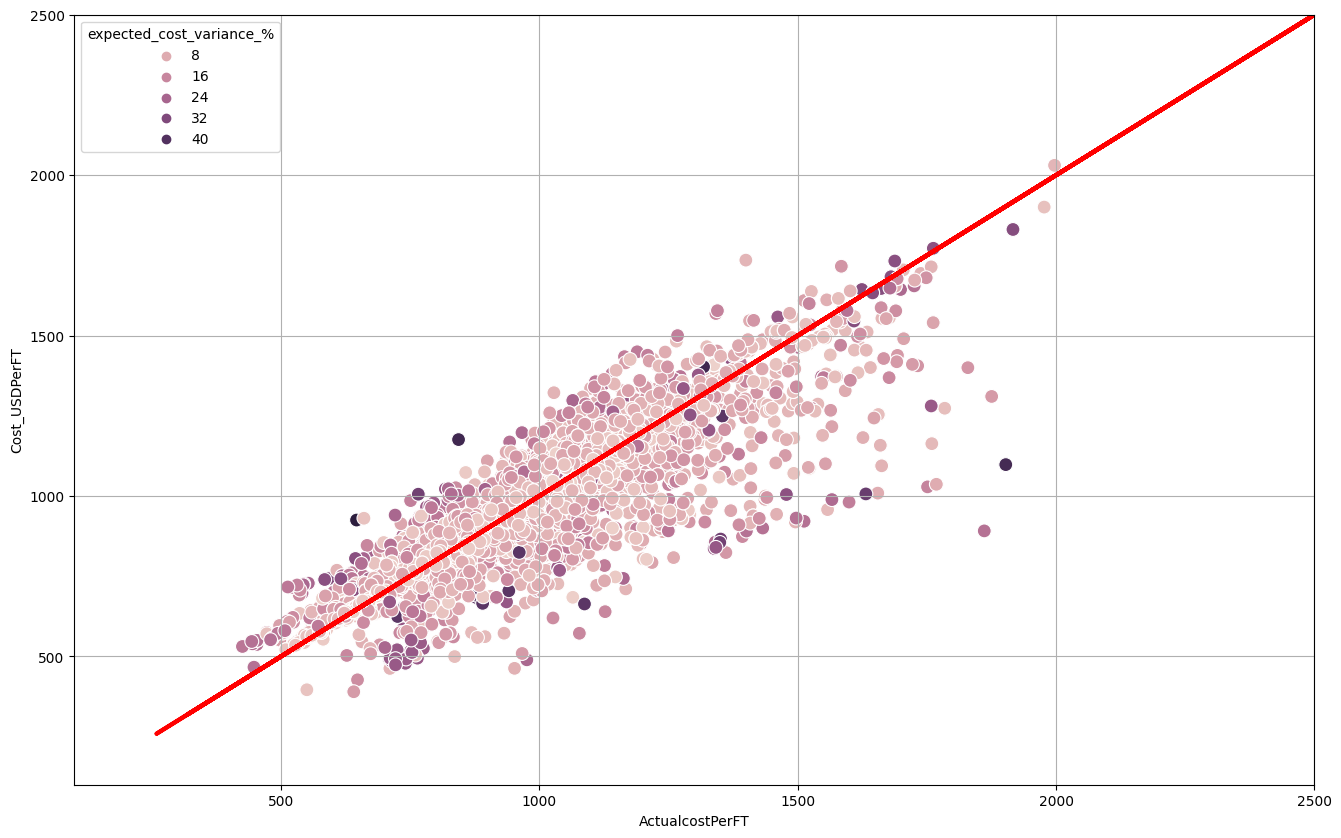

In [54]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue="expected_cost_variance_%", s=100)

plt.plot(final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)]["ActualcostPerFT"].values, final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000)]["ActualcostPerFT"].values, color='red', linewidth=3)
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

In [55]:
final_df["ActualcostPerFT"].describe()

count    5.755000e+03
mean     3.687865e+03
std      1.499060e+05
min      2.591182e+02
25%      7.917119e+02
50%      9.554601e+02
75%      1.111768e+03
max      9.725715e+06
Name: ActualcostPerFT, dtype: float64

In [56]:
final_df[final_df["ActualcostPerFT"]>3000]

API10             Type Curve Area  Proppant_LBSPerFT  \
363   3505124054  South STACK - Area G South       9.885096e+06   
1551  3501725257           Core STACK - LYGC       3.811285e+03   
1825  3505124003  South STACK - Area B South       2.975211e+04   
1902  3505124092  South STACK - Area B South       9.403783e+03   
1903  3505124092  South STACK - Area G South       9.403783e+03   
4469  3501724961     South STACK - Low Yield       1.833608e+07   
4731  3505124185          North SCOOP - HYWG       2.947066e+03   

      Fluid_BBLPerFT  LatitudeMP  LongitudeMP  LateralLength_FT   TVD_FT  \
363    244639.330000   35.268362   -97.864651               1.0  11190.0   
1551       85.554125   35.681744   -98.262671             337.0  12466.0   
1825      662.874061   35.294060   -97.783306             490.0   9766.0   
1902      201.980889   35.232133   -97.704248            2194.0  10416.0   
1903      201.980889   35.232133   -97.704248            2194.0  10416.0   
4469   629438.480000   35.485938   -98.069530               1.0  11628.0   
4731       68.376510   34.945922   -97.670324            1490.0  11798.4   

     OperatorGold  TotalCost_USDMM  Cost_USDPerFT  expected_cost_variance_%  \
363       CITIZEN           -34.22   -34223154.42                       NaN   
1551      COTERRA            -4.81      -14269.03                       NaN   
1825      CITIZEN            22.66       46250.16                       NaN   
1902      CITIZEN            10.45        4762.66                       NaN   
1903      CITIZEN            10.45        4762.66                       NaN   
4469       PALOMA           -34.54   -34539619.19                       NaN   
4731     89ENERGY             1.43         957.83                       NaN   

      Actualcost_USDMM  ActualcostPerFT ReservoirGoldConsolidated  
363           5.897921     5.897921e+06             MISSISSIPPIAN  
1551          3.232195     9.591082e+03                  WOODFORD  
1825          6.459811     1.318329e+04             MISSISSIPPIAN  
1902          8.088748     3.686759e+03             MISSISSIPPIAN  
1903          8.088748     3.686759e+03             MISSISSIPPIAN  
4469          9.725715     9.725715e+06                  WOODFORD  
4731          5.893536     3.955393e+03             MISSISSIPPIAN

In [57]:
final_df["error"] = abs(final_df["Cost_USDPerFT"] - final_df["ActualcostPerFT"])/final_df["ActualcostPerFT"]
df_t = final_df[(final_df.Cost_USDPerFT > 0)]# & (final_df.ActualcostPerFT < 5000)]

In [94]:
api_list

<StringArray>
['3501725797', '3508722395', '3508722380', '3508722394', '3508722372',
 '3501926506', '3508722373', '3508722375', '3504925386', '3501926508',
 '3501926505', '3501926512', '3508722374', '3513727542', '3508722369',
 '3508722371', '3508722370', '3505124940', '3505124946', '3505124938',
 '3505124939', '3501725752', '3507326865', '3507326863', '3507326864',
 '3508722376', '3508722377', '3508722382', '3505124977', '3505124978',
 '3505124976', '3505124979', '3501725753', '3501926482', '3505124981',
 '3508722401', '3505124984', '3508722328', '3508722338', '3508722404',
 '3501725893', '3504925372', '3505124985', '3504925373', '3505125003',
 '3501926536', '3505124961', '3504925370', '3504925400', '3508722414',
 '3504925412', '3504925413', '3508722413', '3504925401', '3508722415',
 '3508722419', '3501725907', '3501725909', '3508722426', '3505125008',
 '3505125007', '3501725908', '3501725910', '3501725911', '3501725902',
 '3501725903', '3504925396', '3504925397', '3504925398', '35137

In [58]:
mro_wells_forecasted= df_t[df_t["API10"].isin(api_list)]["API10"].astype("string").values
mro_input_wells_forecasted_df=df_mro[df_mro["API10"].astype("string").isin(mro_wells_forecasted)][["API10", "AFE D&C $/ft"]]

In [59]:
display(mro_input_wells_forecasted_df)

API10  AFE D&C $/ft
4   3508722372    879.950499
6   3508722373    898.538060
7   3508722375    836.636278
12  3508722374    945.122434
13  3513727542   1413.368587
18  3505124946   1870.818228
22  3507326865    614.870157
23  3507326863    614.629597
24  3507326864    614.870157

In [60]:
df_t[df_t["OperatorGold"] == "MARATHON"]["ActualcostPerFT"].describe()

count     387.000000
mean     1105.087986
std       262.722304
min       478.225434
25%       916.509296
50%      1068.539090
75%      1233.822060
max      2476.008245
Name: ActualcostPerFT, dtype: float64

In [61]:
display(data_tmp)

NameError: name 'data_tmp' is not defined

In [62]:
data_tmp = final_df[final_df["API10"].isin(api_list)]
data_tmp["API10"]=data_tmp["API10"].astype("string")
mro_input_wells_forecasted_df["API10"]=mro_input_wells_forecasted_df["API10"].astype("string")
data_tmp2 = data_tmp.merge(mro_input_wells_forecasted_df,how="inner", on="API10")
display(data_tmp2)

API10            Type Curve Area  Proppant_LBSPerFT  Fluid_BBLPerFT  \
0  3508722375     North SCOOP - Deep Oil        2491.005913       60.603527   
1  3508722373     North SCOOP - Deep Oil        2465.302099       59.886064   
2  3505124946      North SCOOP - Dry Gas        2390.574342       68.742385   
3  3508722372     North SCOOP - Deep Oil        2480.722824       60.560808   
4  3507326864  Core STACK - Volatile Oil        2431.616360       48.723823   
5  3508722374     North SCOOP - Deep Oil        2483.315096       60.019183   
6  3507326863  Core STACK - Volatile Oil        2476.561486       49.547626   
7  3513727542   South SCOOP - High Yield        2445.539926       59.430349   
8  3507326865  Core STACK - Volatile Oil        2479.236467       49.399843   

   LatitudeMP  LongitudeMP  LateralLength_FT    TVD_FT OperatorGold  \
0   34.972721   -97.640886            9471.0  11277.00     89ENERGY   
1   34.945652   -97.643122            9242.0  13000.00     89ENERGY   
2   34.989956   -97.919056            7748.0  16934.00       CAMINO   
3   34.944986   -97.645471            9604.0  12500.00     89ENERGY   
4   35.740690   -97.917400           10171.0   8559.00          OVV   
5   34.946276   -97.640772            8810.0  11230.00     89ENERGY   
6   35.740323   -97.914764           10173.0   8542.00          OVV   
7   34.521640   -97.634720            9242.0   9725.77      CITIZEN   
8   35.740382   -97.919954           10179.0   8568.00          OVV   

   TotalCost_USDMM  Cost_USDPerFT  expected_cost_variance_%  Actualcost_USDMM  \
0            10.01        1056.48                      4.88         10.356112   
1             9.87        1068.31                      4.39         10.522295   
2             7.52         970.65                      2.27          7.795778   
3            10.09        1050.12                      4.88         10.737414   
4             7.09         696.63                      6.46          6.809639   
5             9.67        1097.43                       NaN          9.782473   
6             7.15         702.79                      6.08          6.885022   
7             9.43        1020.30                      4.39          9.485212   
8             7.16         703.34                      6.08          6.894591   

   ActualcostPerFT ReservoirGoldConsolidated     error  AFE D&C $/ft  
0      1093.454956                  WOODFORD  0.033815    836.636278  
1      1138.530090                  WOODFORD  0.061676    898.538060  
2      1006.166464                  WOODFORD  0.035299   1870.818228  
3      1118.014767                  WOODFORD  0.060728    879.950499  
4       669.515185             MISSISSIPPIAN  0.040499    614.870157  
5      1110.382897                  WOODFORD  0.011665    945.122434  
6       676.793683             MISSISSIPPIAN  0.038411    614.629597  
7      1026.315982                  WOODFORD  0.005862   1413.368587  
8       677.334814             MISSISSIPPIAN  0.038393    614.870157

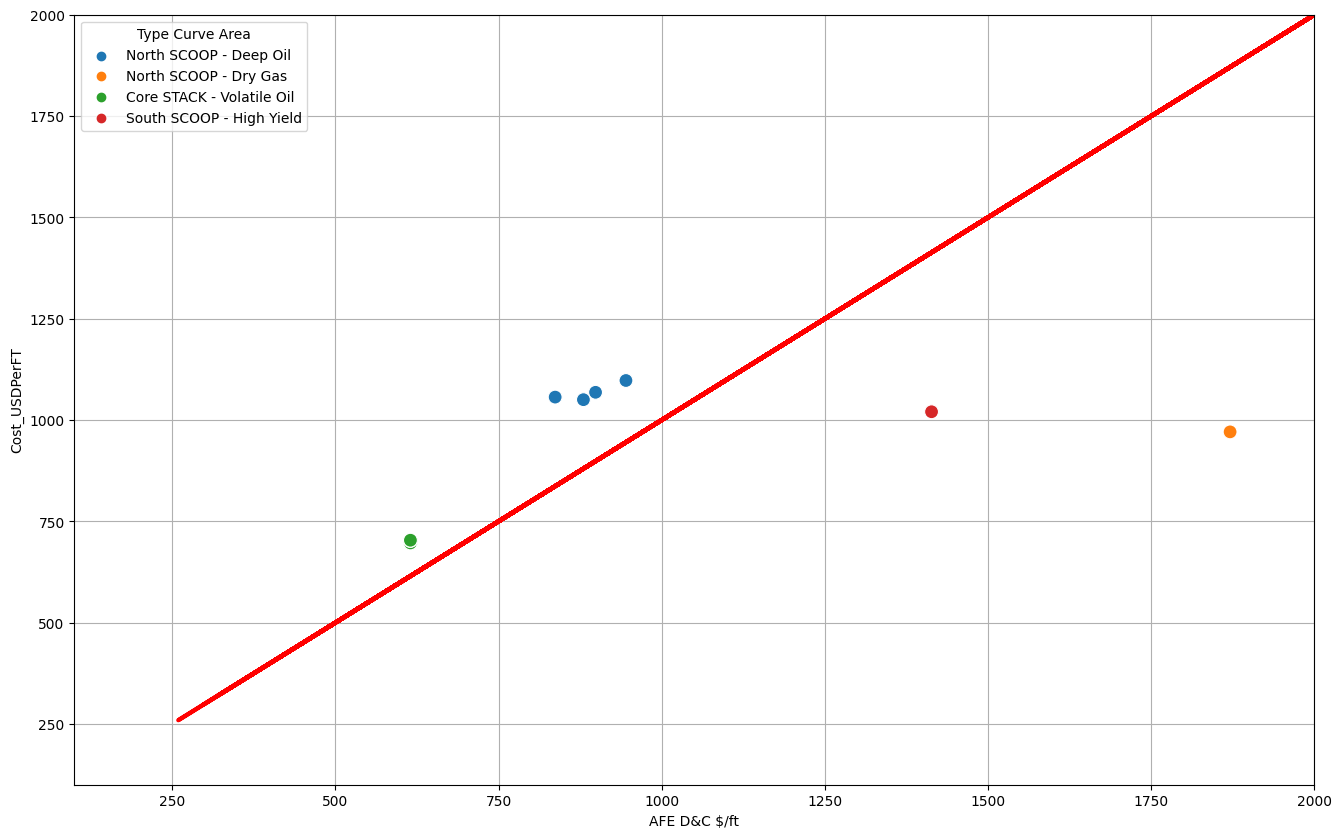

In [63]:
# cost parity for the selected mro afe wells
fig, ax = plt.subplots(figsize=(16, 10))

sns.scatterplot(data=data_tmp2, x ="AFE D&C $/ft", y ="Cost_USDPerFT", hue= "Type Curve Area", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2000])
plt.ylim([100, 2000])
plt.grid()

In [64]:
tca_avg=final_df.groupby("Type Curve Area").agg({"API10":'count',
                                                 "Proppant_LBSPerFT": "mean",
                                                 "Fluid_BBLPerFT":"mean",
                                                 "LateralLength_FT":"mean",
                                                 "TVD_FT":"mean",
                                                 "ActualcostPerFT":"mean",
                                                 "Cost_USDPerFT":"mean"
                                                 })
tca_avg.to_csv('anadarko_east_tca_avgs.csv')

In [65]:
display(tca_avg)

API10  Proppant_LBSPerFT  Fluid_BBLPerFT  \
Type Curve Area                                                           
Core SCOOP - Deep LYWG           195        1765.838863       49.584400   
Core SCOOP - Dry Gas               4        1770.788425       56.729765   
Core SCOOP - GAS HOLE DEEP       110        1862.320117       50.881763   
Core SCOOP - GAS HOLE SHALLOW     30        1960.161362       54.212821   
Core SCOOP - HYGC                149        1439.097083       40.058084   
Core SCOOP - RIMROCK              32        1928.702240       48.664833   
Core SCOOP - Shallow LYWG        217        1644.772960       46.424142   
Core STACK - Gas                  63        2230.981495       59.026571   
Core STACK - HYGC                325        2332.012732       44.227549   
Core STACK - LYGC                508        2259.454585       47.766393   
Core STACK - Oil                 194        1572.345485       48.329539   
Core STACK - Volatile Oil        759        2111.650705       46.117346   
Fringe STACK - High Yield         73        2250.433936       44.783490   
Fringe STACK - Low Yield         105        2079.953313       55.667663   
Fringe STACK - Oil               540        1344.624847       54.813048   
Fringe STACK - Volatile Oil      151        2135.260381       45.545617   
MERGE - Area H                    39        2310.228123       55.751981   
MERGE - Area J                    37        2244.304121       50.790810   
MERGE - Condensate                81        2358.139882       50.713461   
Marietta - Condensate              1        1150.998734       38.024108   
Marietta - Deep Oil               54        1738.235122       52.681470   
Marietta - Updip                  14        1084.986884       38.855978   
NW STACK - Gas                    12        2004.313624       50.613841   
NW STACK - High Yield             80        1835.670236       45.586482   
NW STACK - Low Yield             250        1689.535839       47.211524   
NW STACK - Oil                   131        1296.783373       58.028647   
North SCOOP - Deep Oil           230        2058.253737       49.722747   
North SCOOP - Dry Gas             14        2560.936231       65.547859   
North SCOOP - HYWG               101        1995.196084       51.304737   
North SCOOP - LYWG                90        2011.615119       54.820675   
North SCOOP - Shallow Oil        142        2335.250367       51.644198   
SWOOP                             30        2105.202390       52.151104   
South SCOOP - High Yield          58        2343.888706       53.528306   
South SCOOP - Lower Cont.         21        1213.538226       38.936088   
South SCOOP - Upper Deep          14         833.544042       42.171316   
South SCOOP - Upper Shallow       28        1440.440638       52.691372   
South STACK - Area B South       206        2356.460565       54.724265   
South STACK - Area G South       156       65538.268947     1618.659541   
South STACK - High Yield         232        2132.400367       50.825551   
South STACK - Low Yield          279       68111.361774     2312.303585   

                               LateralLength_FT        TVD_FT  \
Type Curve Area                                                 
Core SCOOP - Deep LYWG              8169.466667  15559.458615   
Core SCOOP - Dry Gas                8372.500000  18153.157500   
Core SCOOP - GAS HOLE DEEP          7939.763636  12470.438545   
Core SCOOP - GAS HOLE SHALLOW       6895.666667   9798.023667   
Core SCOOP - HYGC                   7850.758389  13294.037987   
Core SCOOP - RIMROCK                8255.437500  10274.204063   
Core SCOOP - Shallow LYWG           7747.986175  14858.088479   
Core STACK - Gas                    8943.984127  15028.816349   
Core STACK - HYGC                   8359.886154  10711.757600   
Core STACK - LYGC                   6957.149302  12193.053209   
Core STACK - Oil                    5451.546105   7540.730258   
Core STACK - Volatile Oil          

In [66]:
tca_avg["error"]=(tca_avg["Cost_USDPerFT"]-tca_avg["ActualcostPerFT"])/tca_avg["ActualcostPerFT"]
display(tca_avg.sort_values("error"))

API10  Proppant_LBSPerFT  Fluid_BBLPerFT  \
Type Curve Area                                                           
South STACK - Area G South       156       65538.268947     1618.659541   
South STACK - Low Yield          279       68111.361774     2312.303585   
North SCOOP - Dry Gas             14        2560.936231       65.547859   
South SCOOP - Upper Deep          14         833.544042       42.171316   
Core SCOOP - Dry Gas               4        1770.788425       56.729765   
MERGE - Area J                    37        2244.304121       50.790810   
North SCOOP - LYWG                90        2011.615119       54.820675   
South SCOOP - Upper Shallow       28        1440.440638       52.691372   
NW STACK - Oil                   131        1296.783373       58.028647   
Core SCOOP - Shallow LYWG        217        1644.772960       46.424142   
Core SCOOP - Deep LYWG           195        1765.838863       49.584400   
MERGE - Area H                    39        2310.228123       55.751981   
Core SCOOP - GAS HOLE DEEP       110        1862.320117       50.881763   
North SCOOP - HYWG               101        1995.196084       51.304737   
Core SCOOP - HYGC                149        1439.097083       40.058084   
Fringe STACK - Oil               540        1344.624847       54.813048   
Marietta - Deep Oil               54        1738.235122       52.681470   
NW STACK - Gas                    12        2004.313624       50.613841   
North SCOOP - Shallow Oil        142        2335.250367       51.644198   
Core STACK - LYGC                508        2259.454585       47.766393   
Core STACK - Oil                 194        1572.345485       48.329539   
Core STACK - Gas                  63        2230.981495       59.026571   
Core STACK - Volatile Oil        759        2111.650705       46.117346   
Core SCOOP - GAS HOLE SHALLOW     30        1960.161362       54.212821   
Marietta - Condensate              1        1150.998734       38.024108   
North SCOOP - Deep Oil           230        2058.253737       49.722747   
NW STACK - Low Yield             250        1689.535839       47.211524   
Core STACK - HYGC                325        2332.012732       44.227549   
South SCOOP - High Yield          58        2343.888706       53.528306   
South STACK - High Yield         232        2132.400367       50.825551   
Fringe STACK - High Yield         73        2250.433936       44.783490   
NW STACK - High Yield             80        1835.670236       45.586482   
MERGE - Condensate                81        2358.139882       50.713461   
Fringe STACK - Low Yield         105        2079.953313       55.667663   
SWOOP                             30        2105.202390       52.151104   
Fringe STACK - Volatile Oil      151        2135.260381       45.545617   
Core SCOOP - RIMROCK              32        1928.702240       48.664833   
South SCOOP - Lower Cont.         21        1213.538226       38.936088   
Marietta - Updip                  14        1084.986884       38.855978   
South STACK - Area B South       206        2356.460565       54.724265   

                               LateralLength_FT        TVD_FT  \
Type Curve Area                                                 
South STACK - Area G South          7574.846154  10547.368974   
South STACK - Low Yield             7199.660736  11399.428961   
North SCOOP - Dry Gas               7455.785714  16353.412857   
South SCOOP - Upper Deep            4756.857143  15312.654286   
Core SCOOP - Dry Gas                8372.500000  18153.157500   
MERGE - Area J                      8251.189189  13047.448649   
North SCOOP - LYWG                  7555.366667  15051.333222   
South SCOOP - Upper Shallow         6357.357143  12359.754387   
NW STACK - Oil                      4739.906600   7719.136794   
Core SCOOP - Shallow LYWG           7747.986175  14858.088479   
Core SCOOP - Deep LYWG              8169.466667  15559.458615   
MERGE - Area H                     

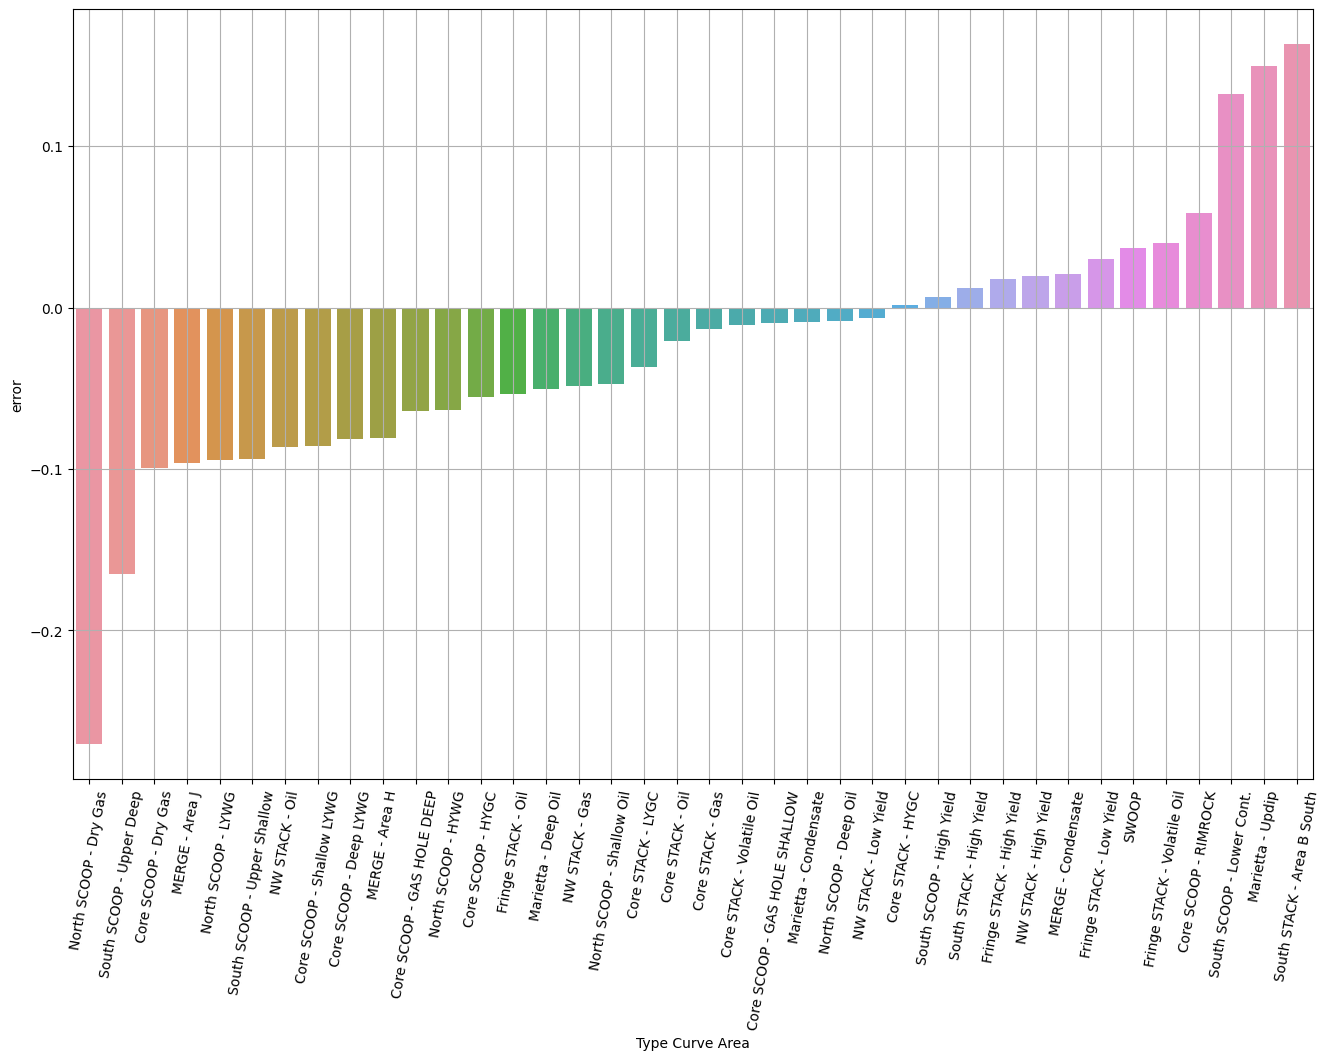

In [67]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(data=tca_avg[tca_avg["Cost_USDPerFT"]>0].sort_values("error").reset_index(),x="Type Curve Area", y="error")
ax.tick_params(axis='x', rotation=80)
plt.grid()

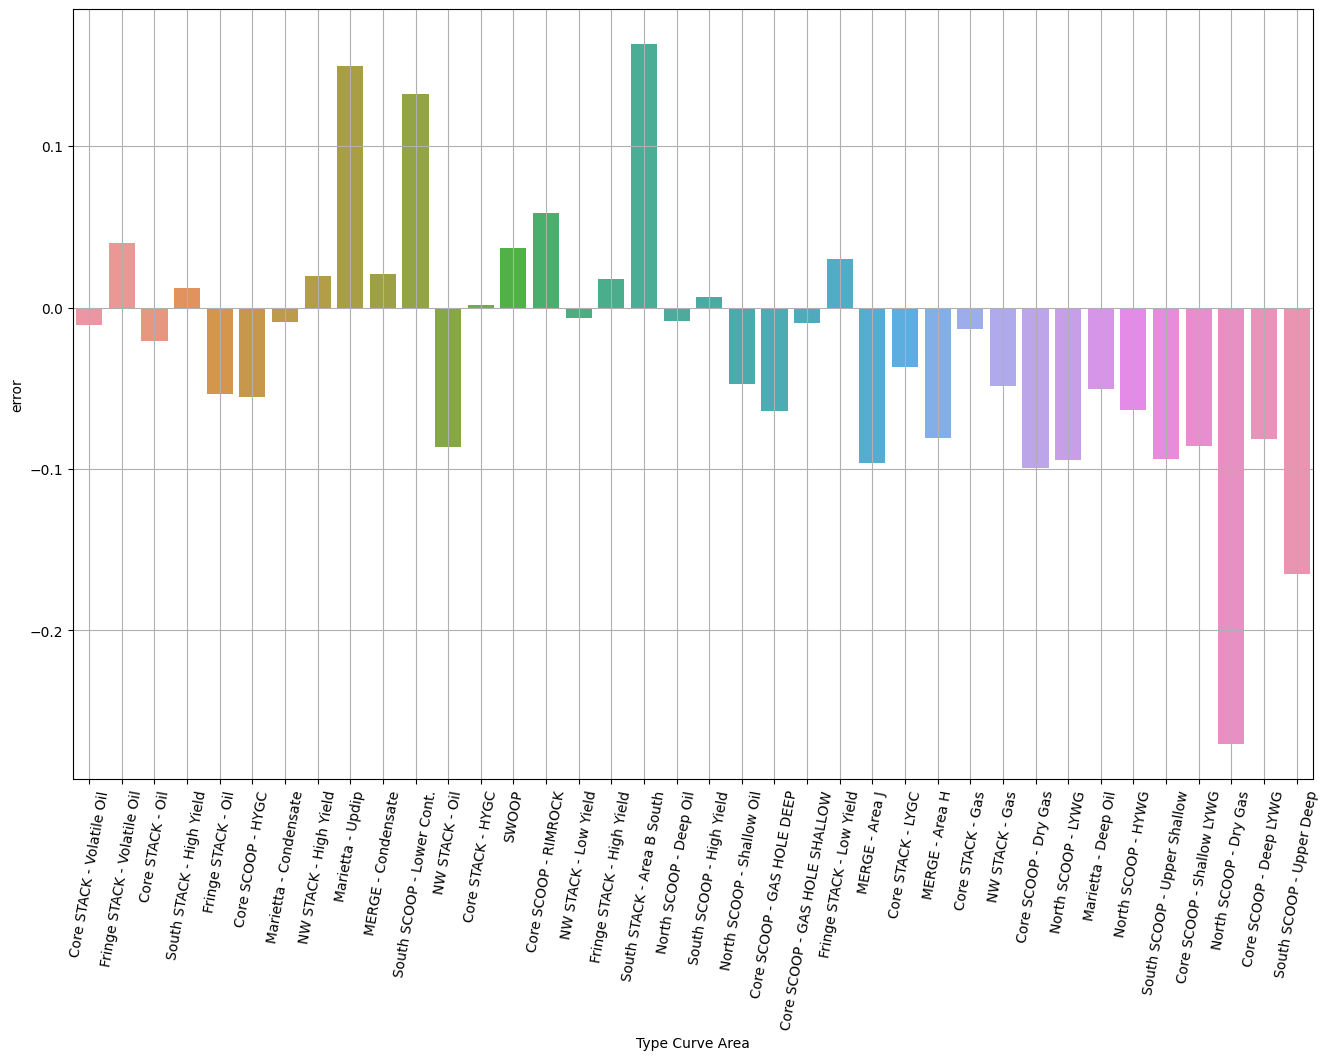

In [68]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(data=tca_avg[tca_avg["Cost_USDPerFT"]>0].sort_values("ActualcostPerFT").reset_index(),x="Type Curve Area", y="error")
ax.tick_params(axis='x', rotation=80)
plt.grid()

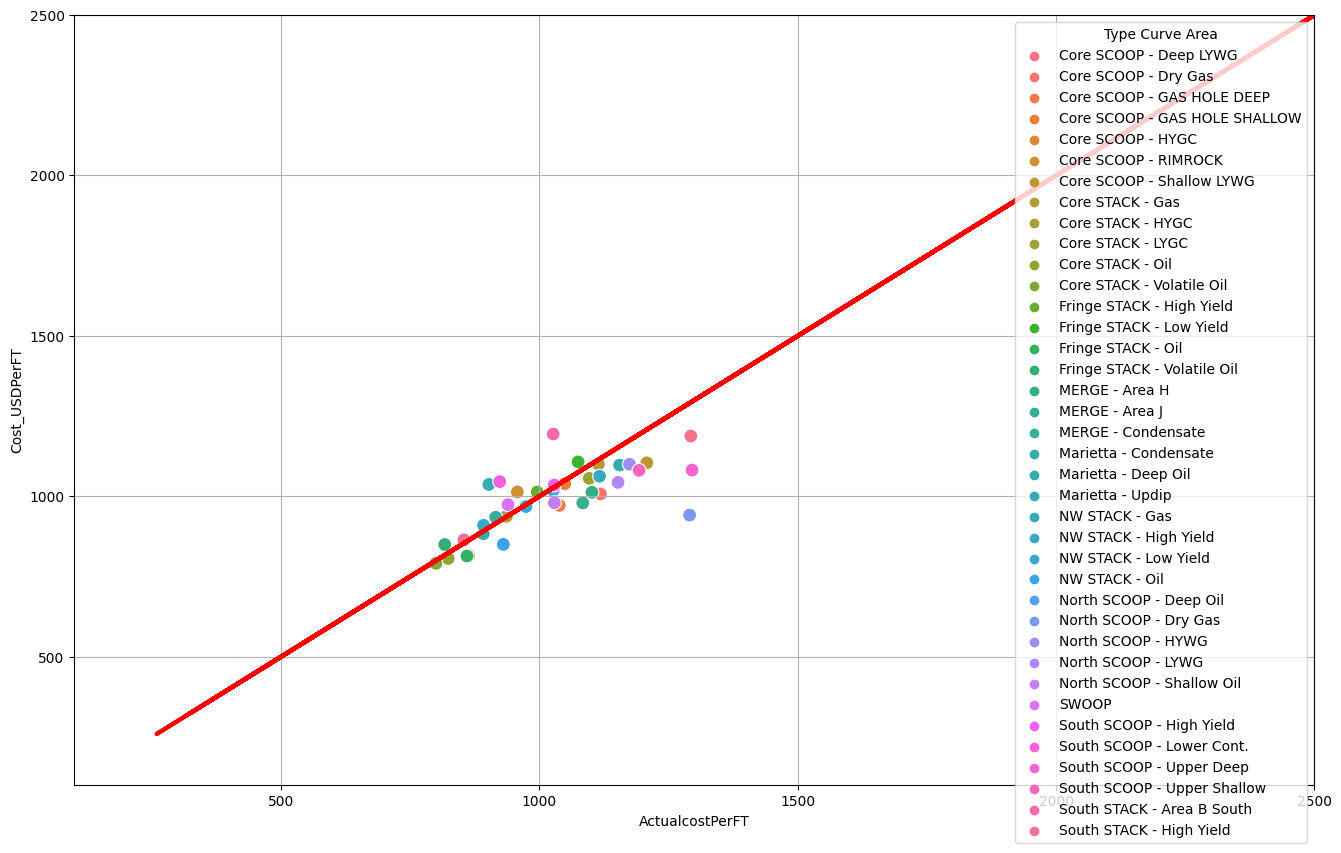

In [69]:
#conpare cost_USDPerFT and ActualCostPerFT means per TCA
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=tca_avg[tca_avg["Cost_USDPerFT"]>0], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "Type Curve Area", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

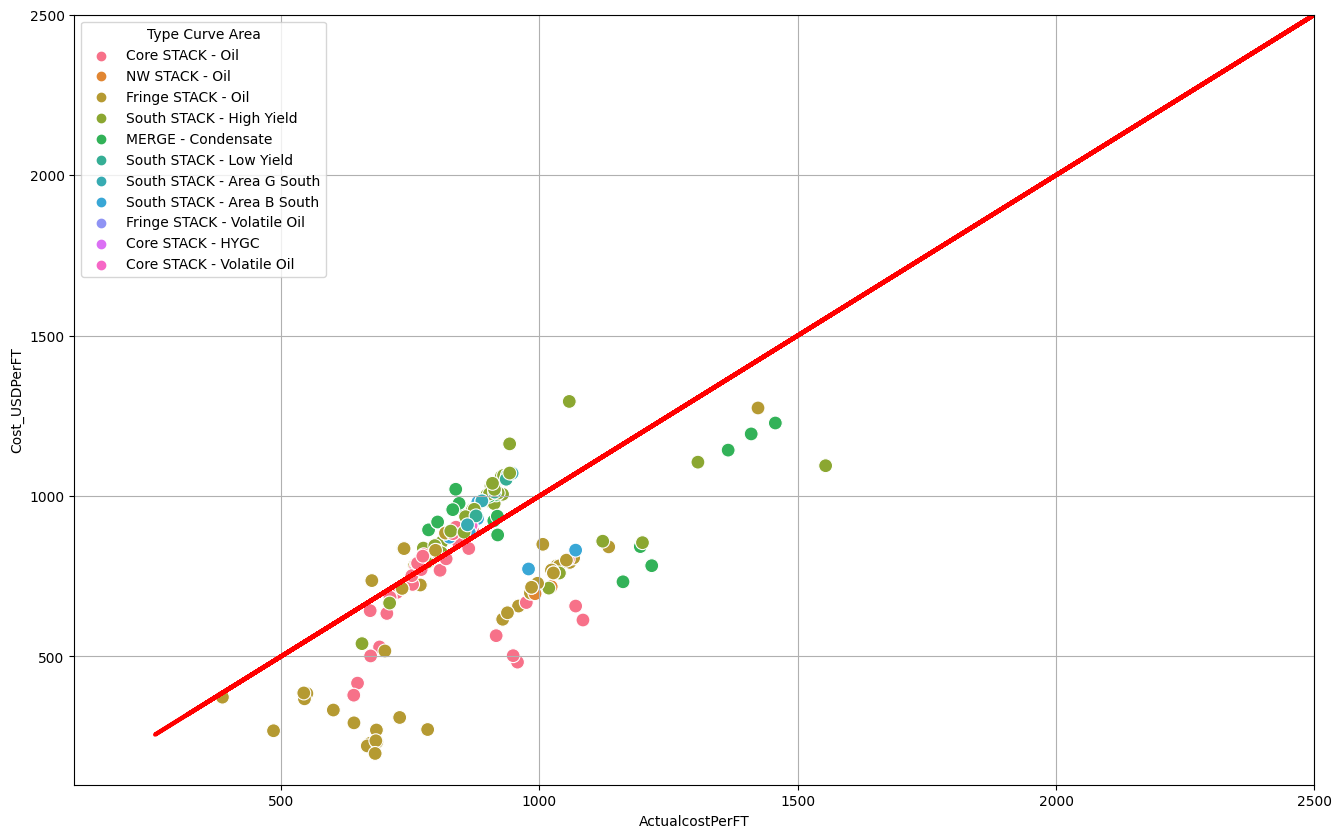

In [42]:
#conpare cost_USDPerFT and ActualCostPerFT for CANVAS
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=final_df[(final_df.Cost_USDPerFT > 0) & (final_df.ActualcostPerFT < 5000) &(final_df.OperatorGold == 'CANVAS')], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "Type Curve Area", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

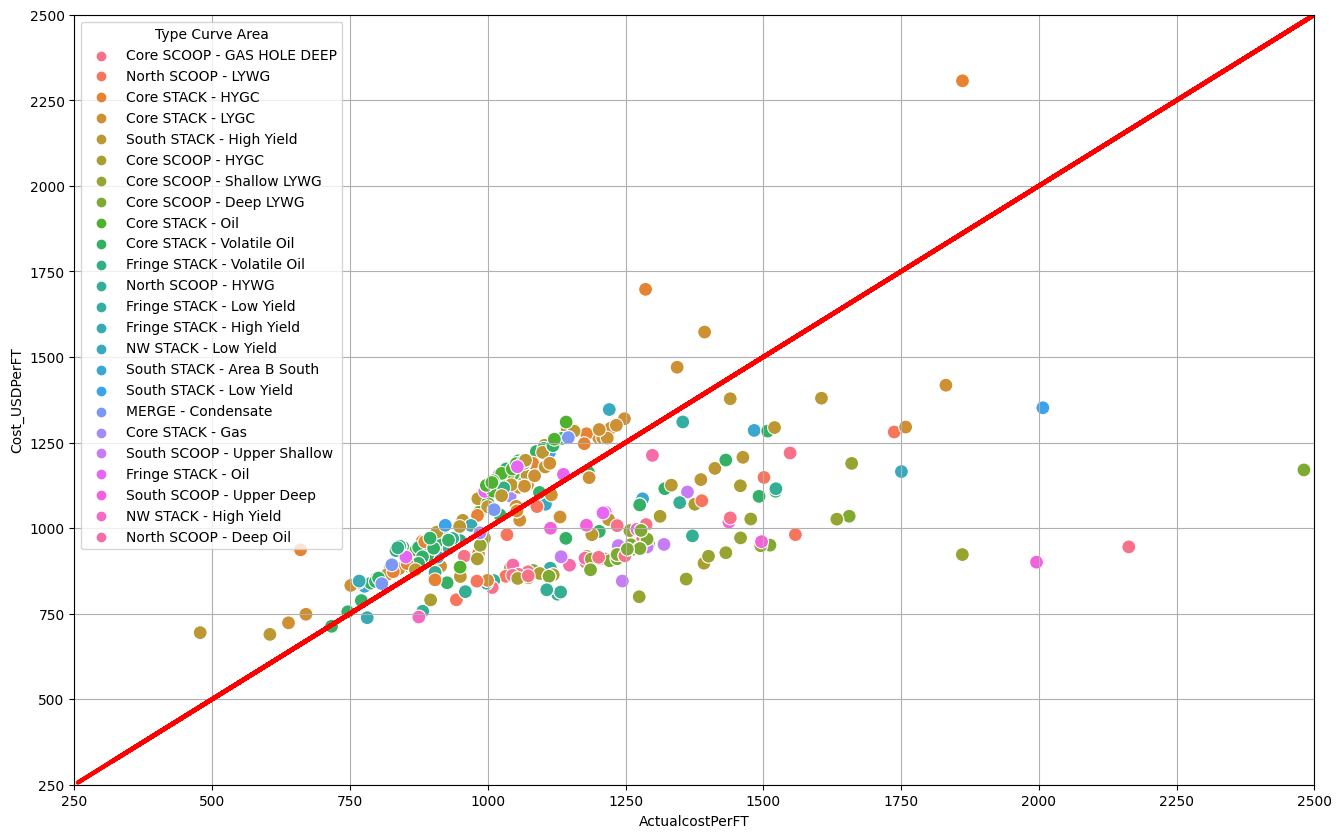

In [43]:
#conpare cost_USDPerFT and ActualCostPerFT for Marathon
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "Type Curve Area", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([250, 2500])
plt.ylim([250, 2500])
plt.grid()

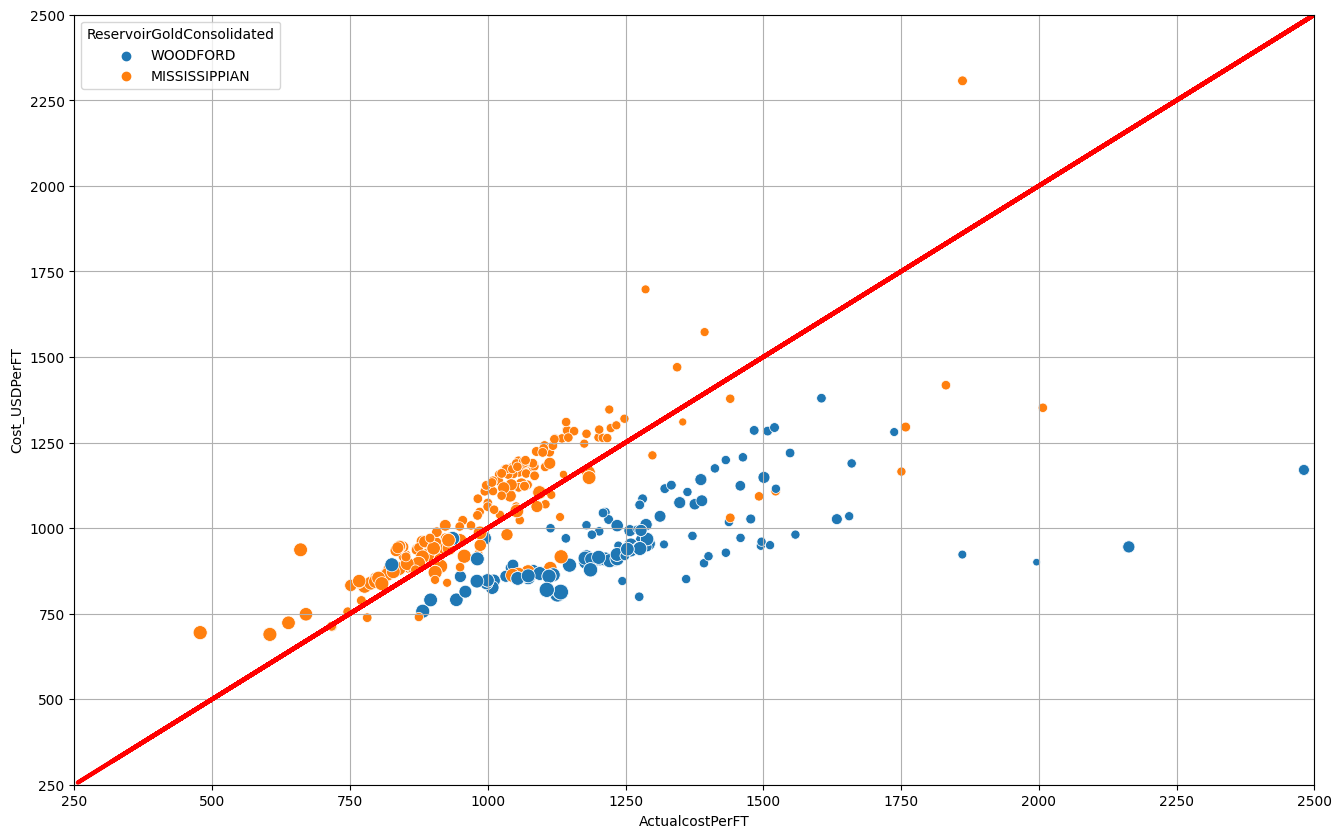

In [44]:
#conpare cost_USDPerFT and ActualCostPerFT for Marathon
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "ReservoirGoldConsolidated", s=df_t[df_t["OperatorGold"] == "MARATHON"]["LateralLength_FT"]/100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([250, 2500])
plt.ylim([250, 2500])
plt.grid()

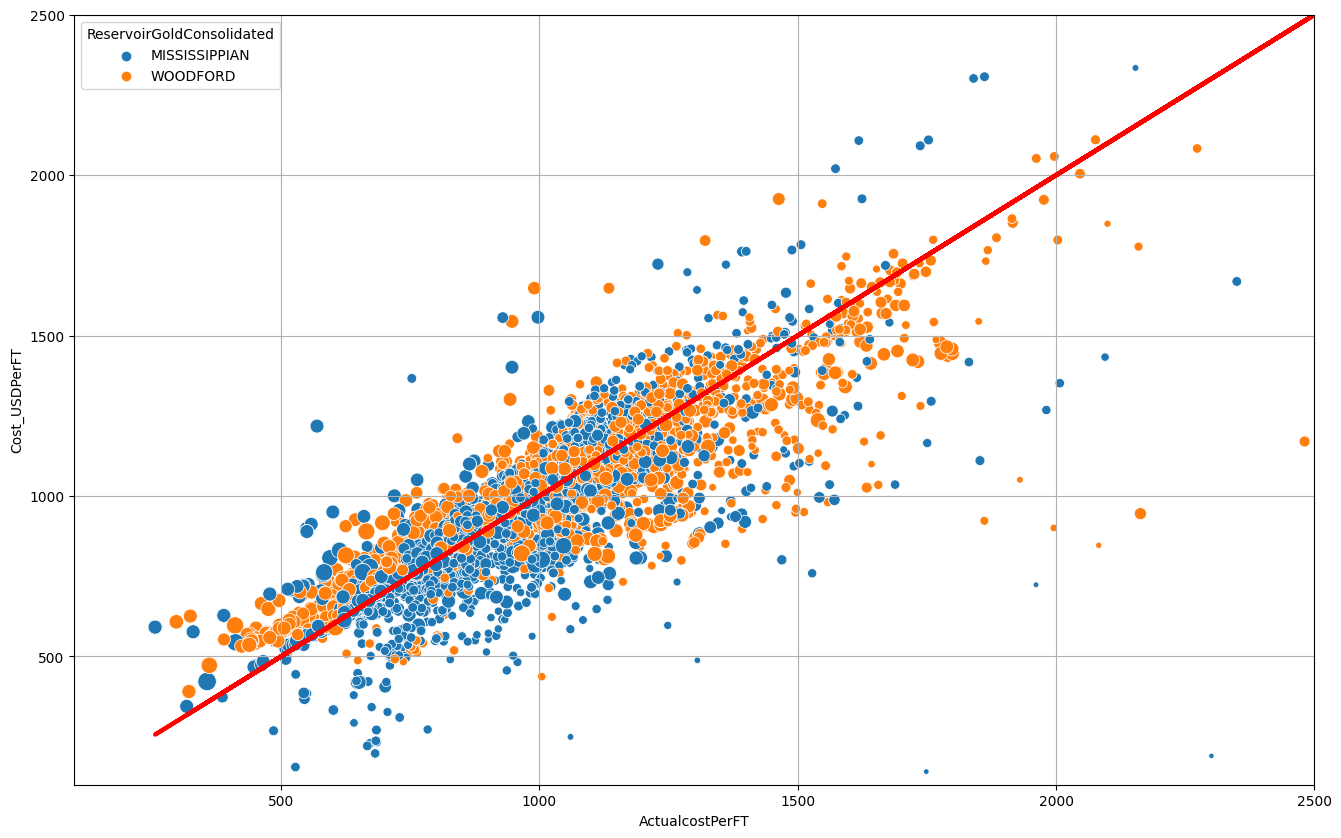

In [45]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t, x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "ReservoirGoldConsolidated", s=df_t["LateralLength_FT"]/100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

In [46]:
df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")]['OperatorGold'].unique()

array(['CLR', 'COTERRA', 'OVV', 'GPOR', '89ENERGY', 'miscellaneous',
       'DEVON', 'MARATHON', 'CITIZEN', 'CAMINO', 'BCE-MACH', 'EXXON',
       'PALOMA', 'CANVAS', 'CHISHOLM O&G'], dtype=object)

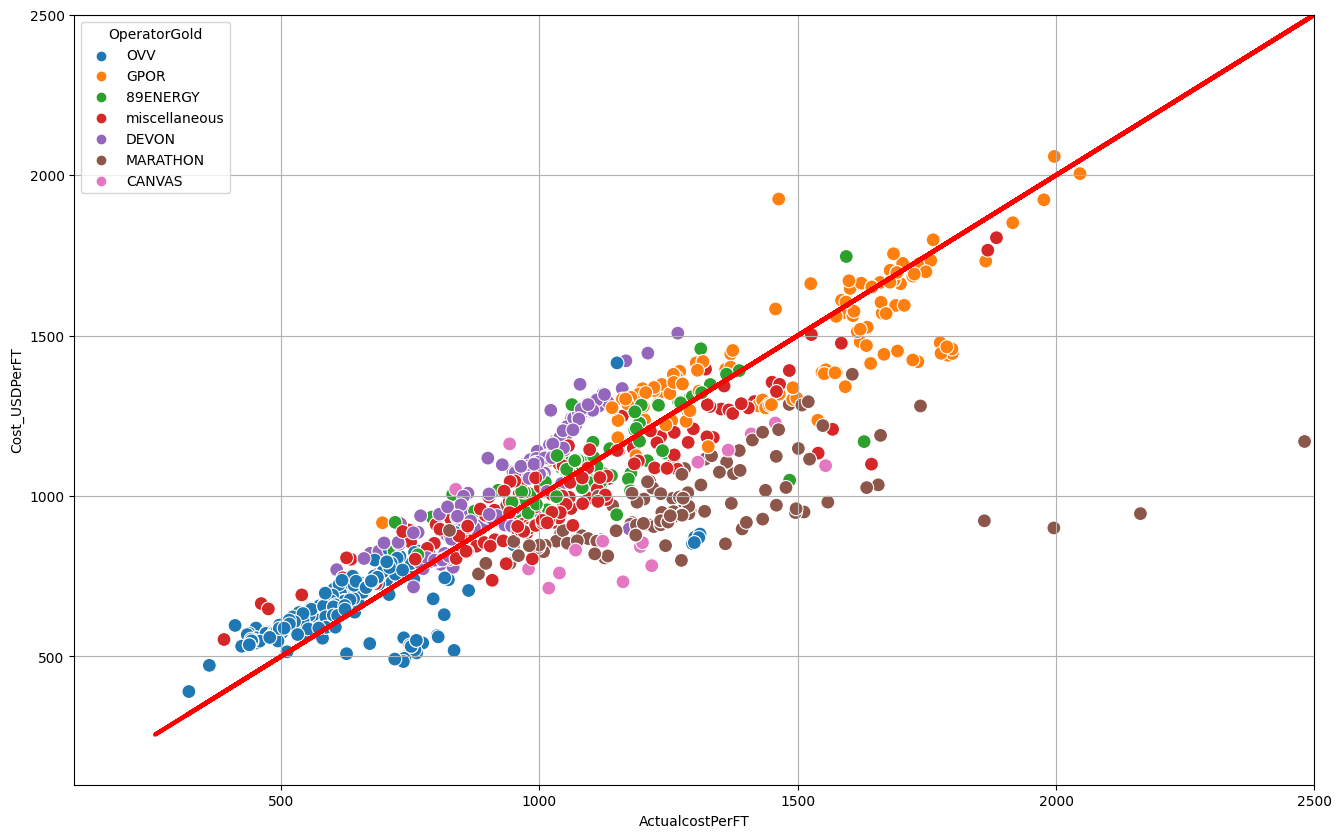

In [47]:
use_op_list = ['MARATHON', 'miscellaneous', 'CANVAS', 'GPOR', '89ENERGY', 'EOG', 'DEVON', 'OVV']
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")&(df_t['OperatorGold'].isin(use_op_list))], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "OperatorGold", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

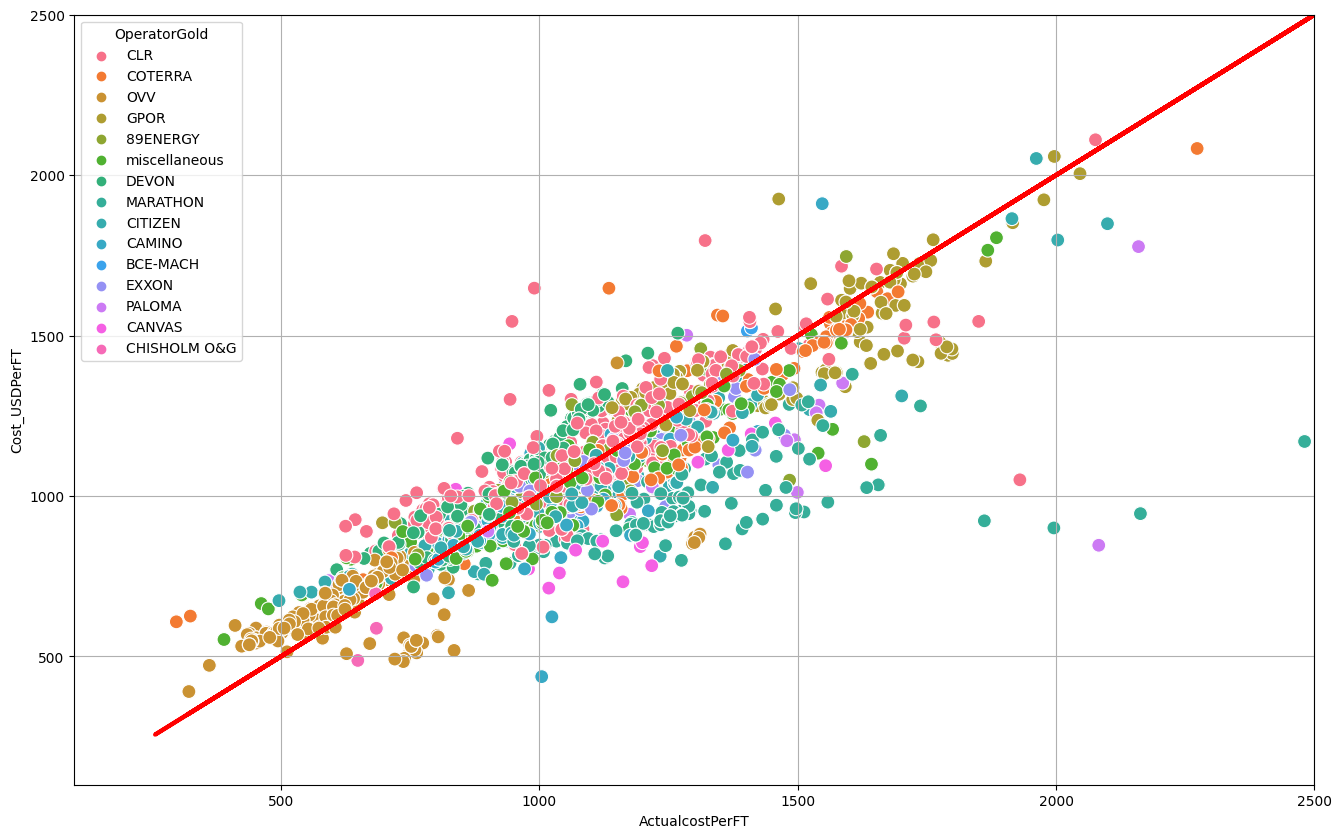

In [48]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "OperatorGold", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

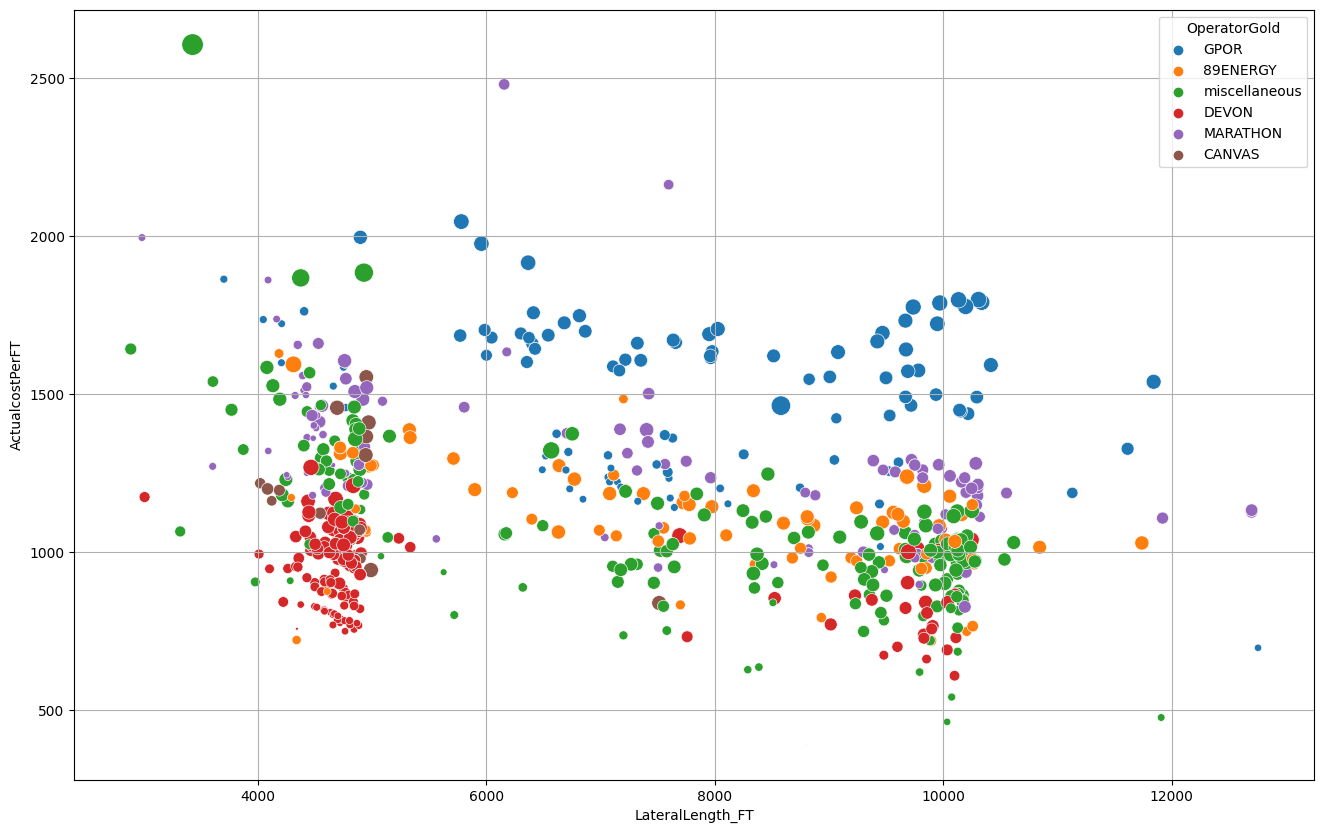

In [49]:
use_op_list = ['MARATHON', 'miscellaneous', 'CANVAS', 'GPOR', '89ENERGY', 'EOG', 'DEVON']
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")&(df_t["OperatorGold"].isin(use_op_list))], x ="LateralLength_FT", y ="ActualcostPerFT", hue= "OperatorGold", s=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")&(df_t["OperatorGold"].isin(use_op_list))]['Proppant_LBSPerFT']/25)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim([100, 2500])
#plt.ylim([100, 2500])
plt.grid()

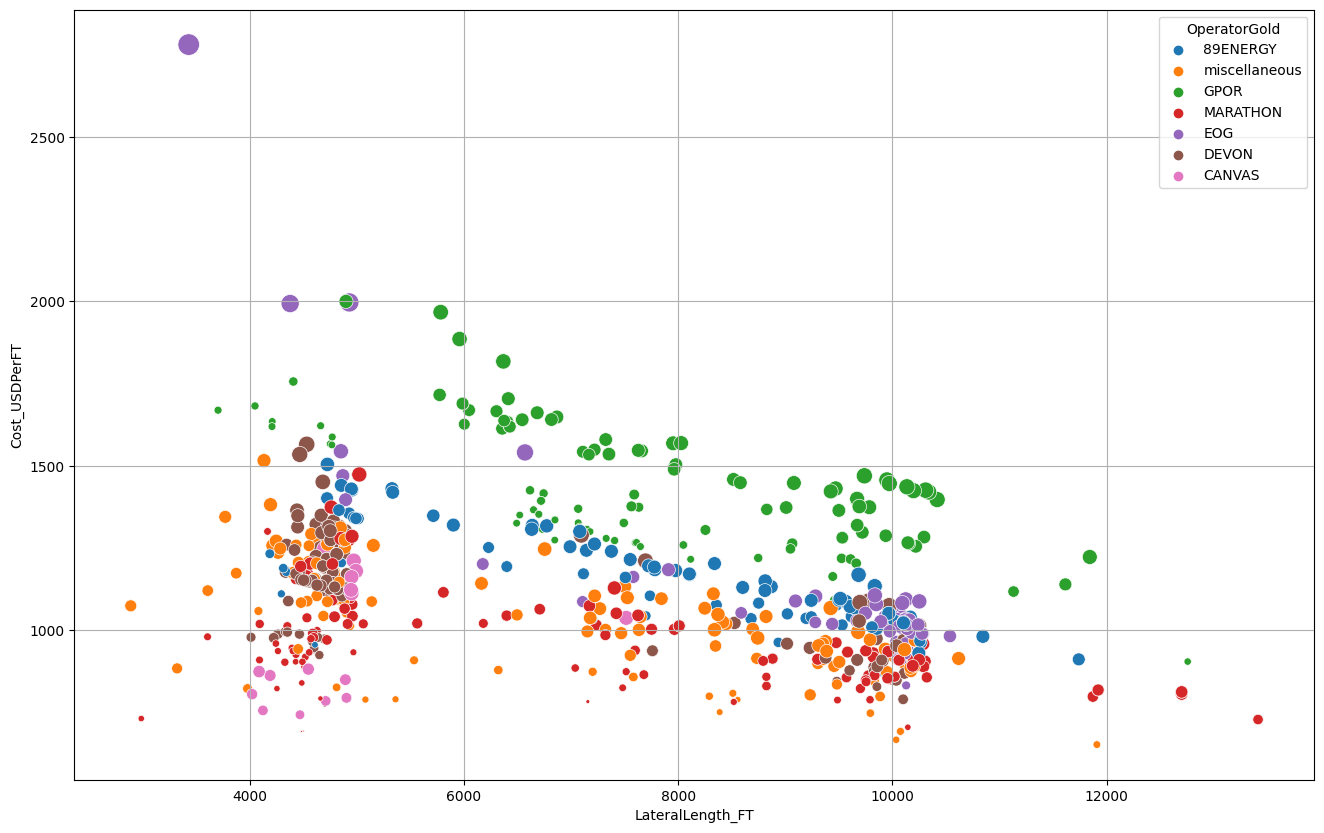

In [191]:
use_op_list = ['MARATHON', 'miscellaneous', 'CANVAS', 'GPOR', '89ENERGY', 'EOG', 'DEVON']
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")&(df_t["OperatorGold"].isin(use_op_list))], x ="LateralLength_FT", y ="Cost_USDPerFT", hue= "OperatorGold", s=df_t[(df_t["ReservoirGoldConsolidated"]=="WOODFORD")&(df_t["OperatorGold"].isin(use_op_list))]['Proppant_LBSPerFT']/25)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim([100, 2500])
#plt.ylim([100, 2500])
plt.grid()

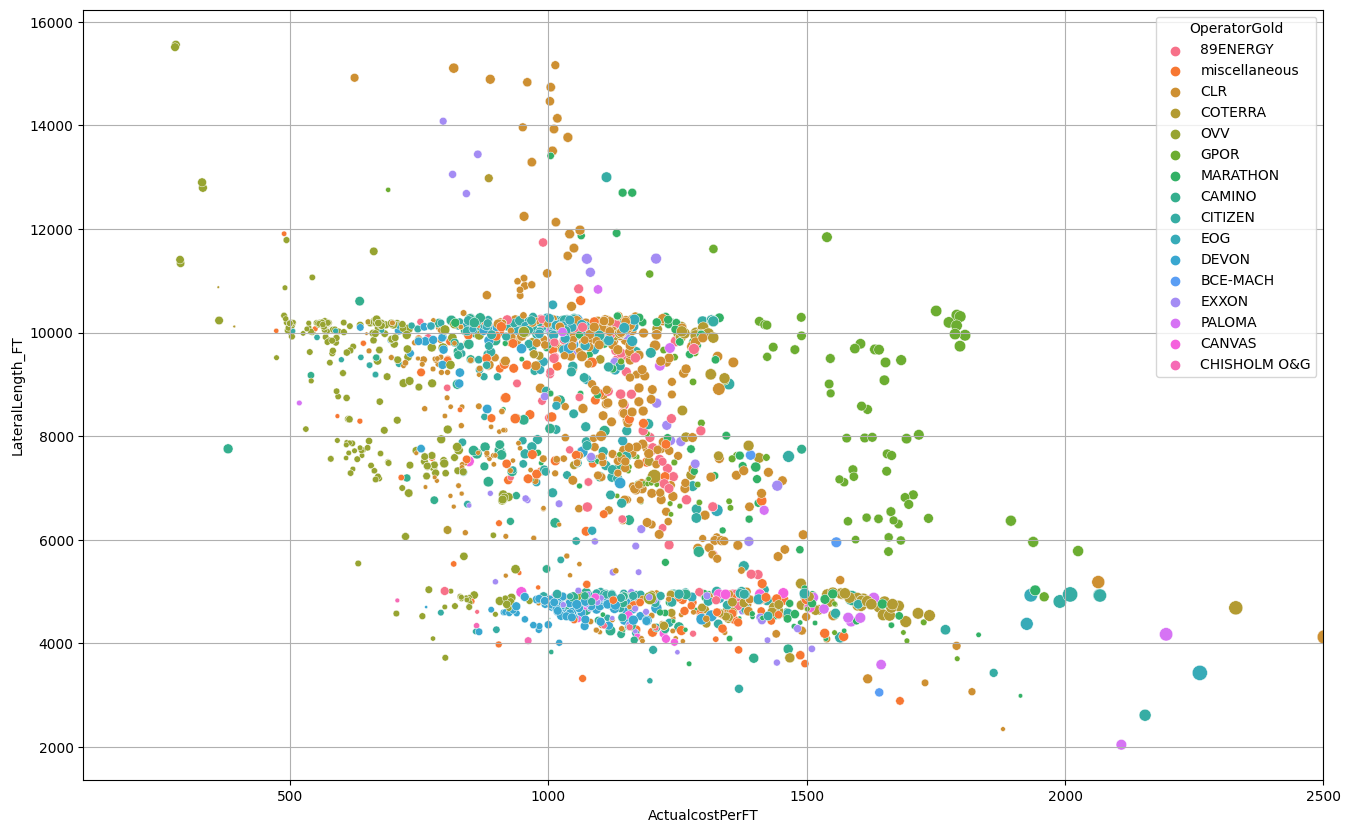

In [171]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["ReservoirGoldConsolidated"]=="WOODFORD"], x ="ActualcostPerFT", y ="LateralLength_FT", hue= "OperatorGold", s=df_t[df_t["ReservoirGoldConsolidated"]=="WOODFORD"]['Proppant_LBSPerFT']/50)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
#plt.ylim([100, 2500])
plt.grid()

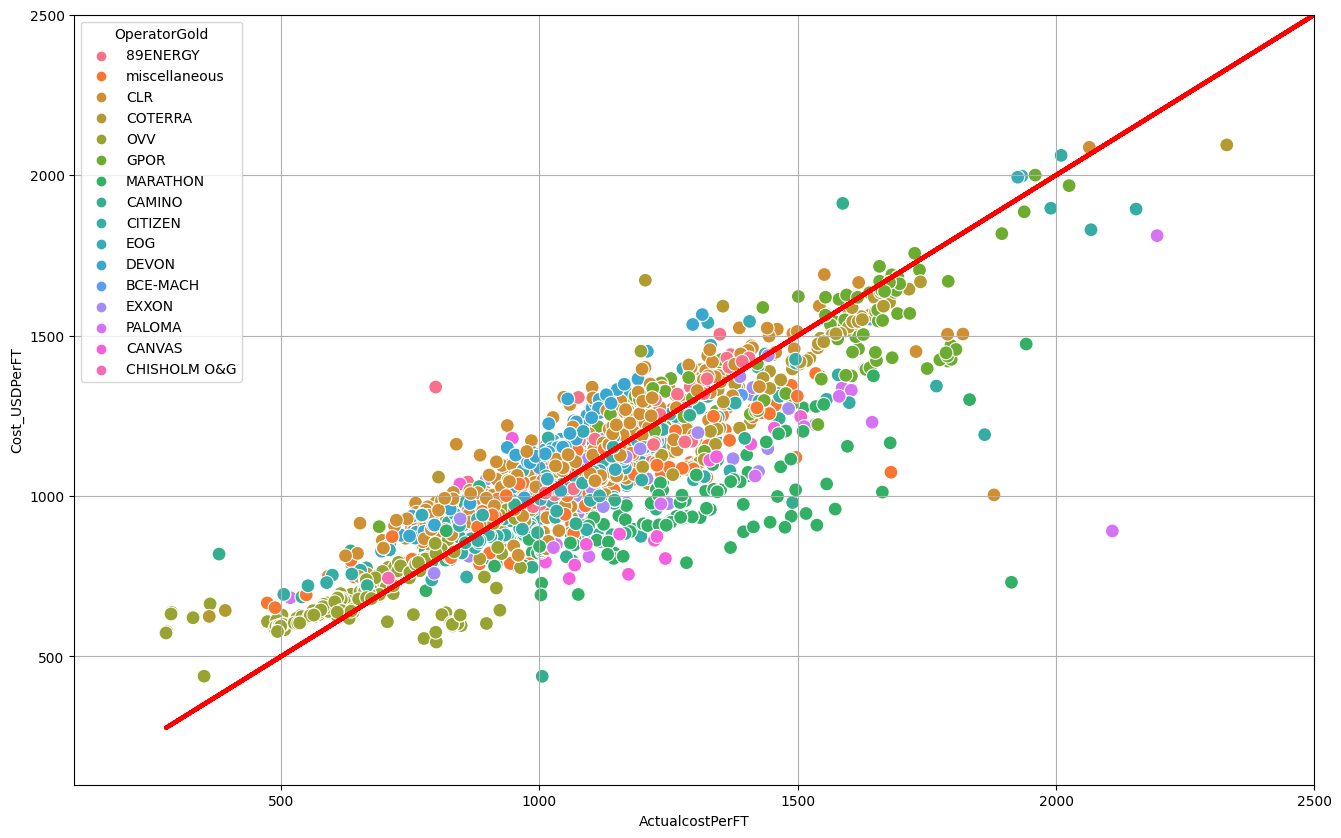

In [157]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["ReservoirGoldConsolidated"] == "WOODFORD"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "OperatorGold", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([100, 2500])
plt.ylim([100, 2500])
plt.grid()

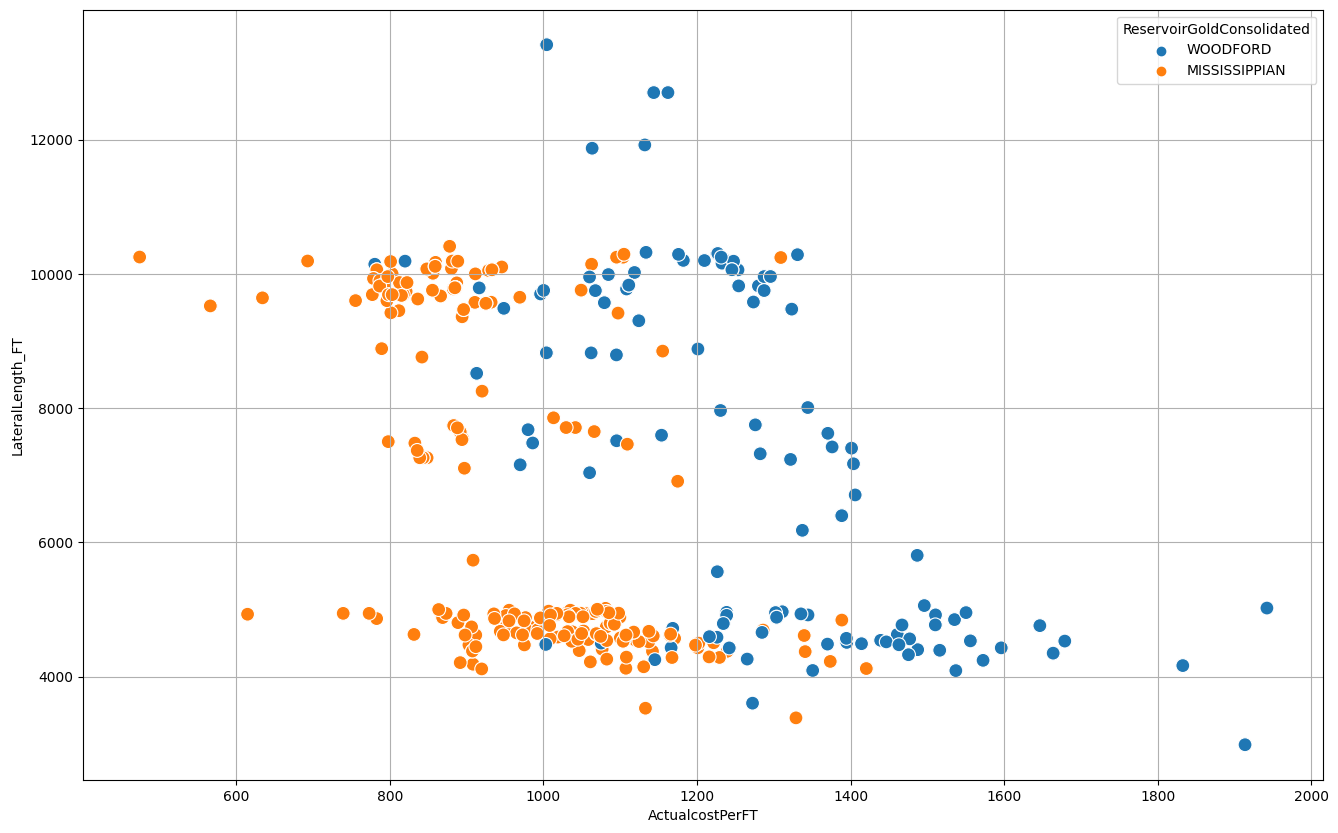

In [154]:
#conpare cost_USDPerFT and ActualCostPerFT for Marathon
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT",y= "LateralLength_FT", hue= "ReservoirGoldConsolidated", s=100)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim([250, 2500])
#plt.ylim([250, 2500])
plt.grid()

In [92]:
df_t.columns

Index(['Type Curve Area', 'Proppant_LBSPerFT', 'Fluid_BBLPerFT', 'LatitudeMP',
       'LongitudeMP', 'LateralLength_FT', 'TVD_FT', 'OperatorGold',
       'TotalCost_USDMM', 'Cost_USDPerFT', 'expected_cost_variance_%',
       'Actualcost_USDMM', 'ActualcostPerFT', 'ReservoirGoldConsolidated',
       'error'],
      dtype='object')

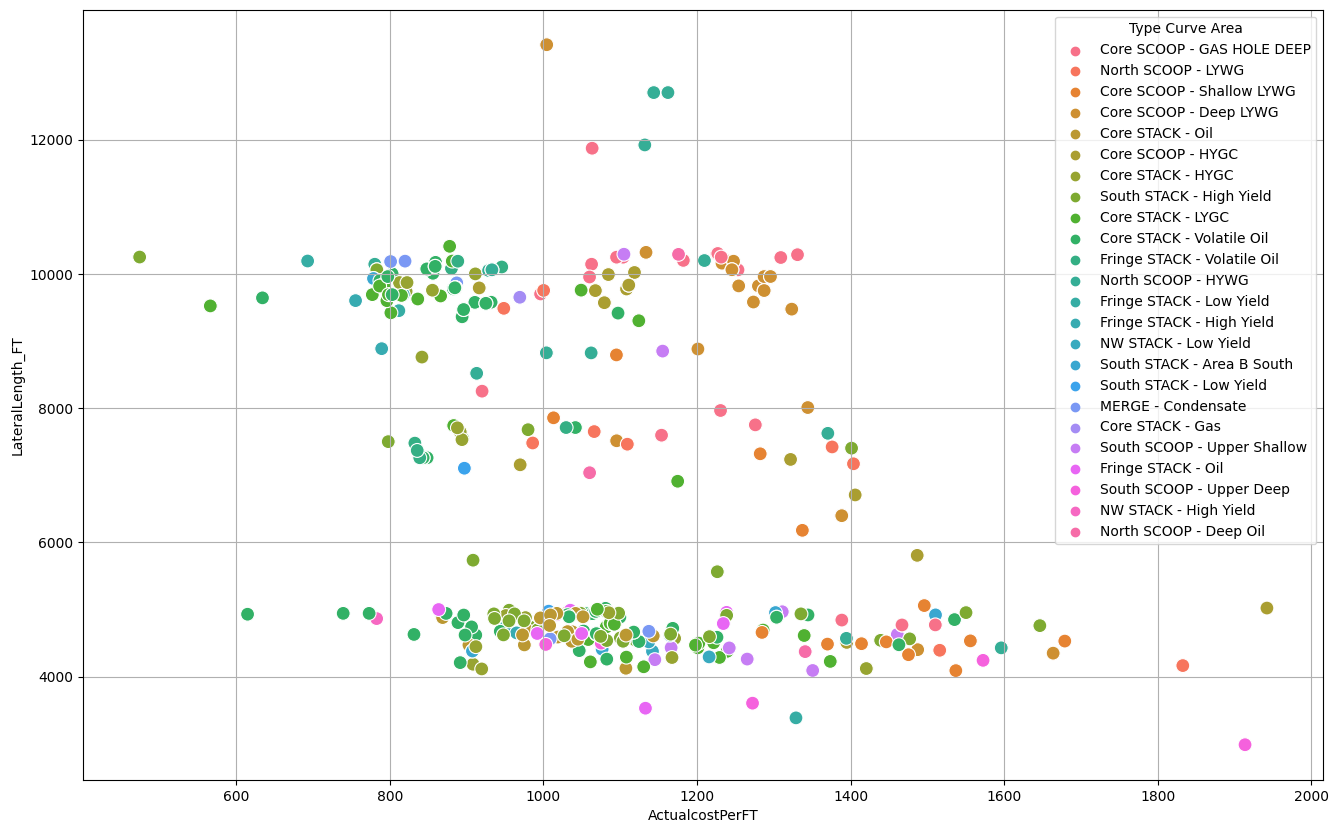

In [97]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT", y ="LateralLength_FT", hue= "Type Curve Area", s=100)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim([250, 2500])
#plt.ylim([250, 2500])
plt.grid()

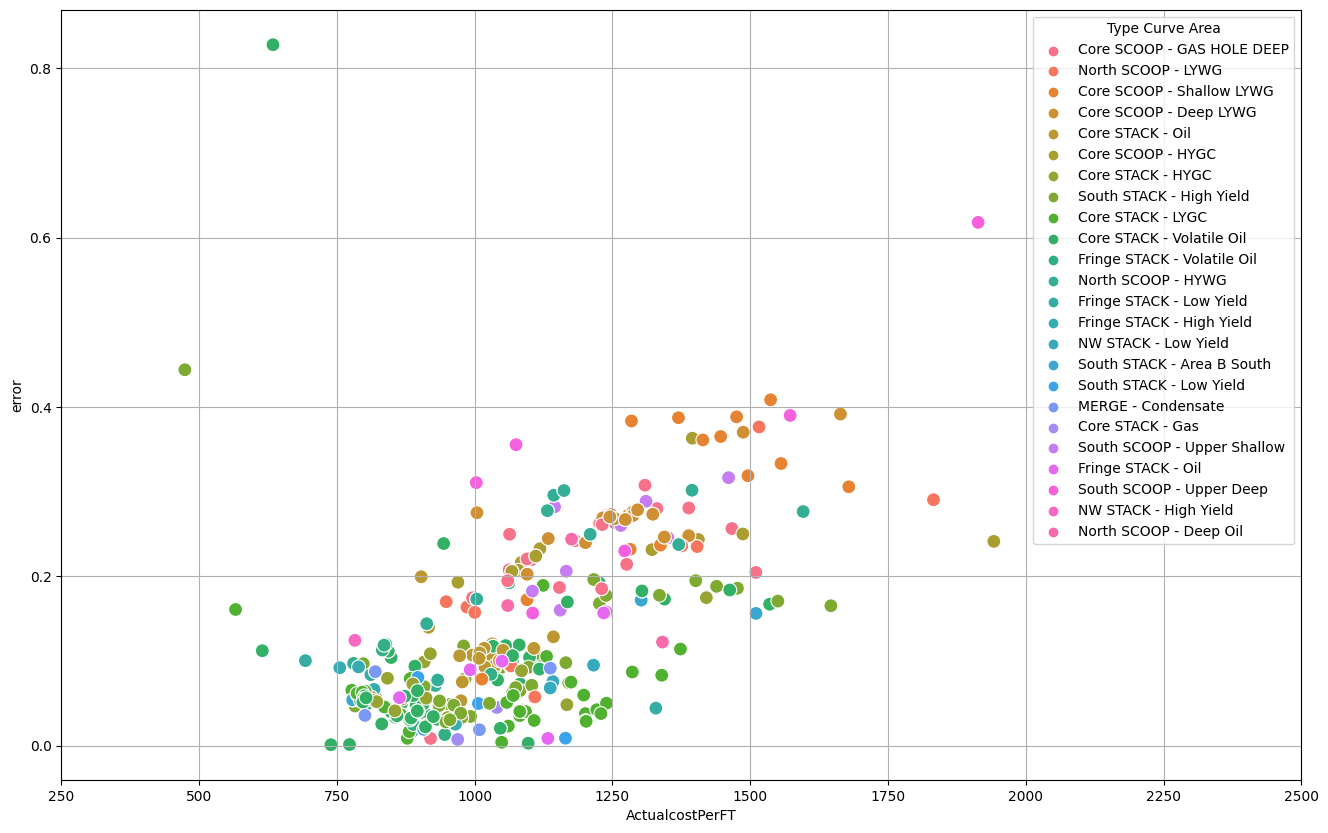

In [103]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT", y ="error", hue= "Type Curve Area", s=100)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([250, 2500])
#plt.ylim([250, 2500])
plt.grid()

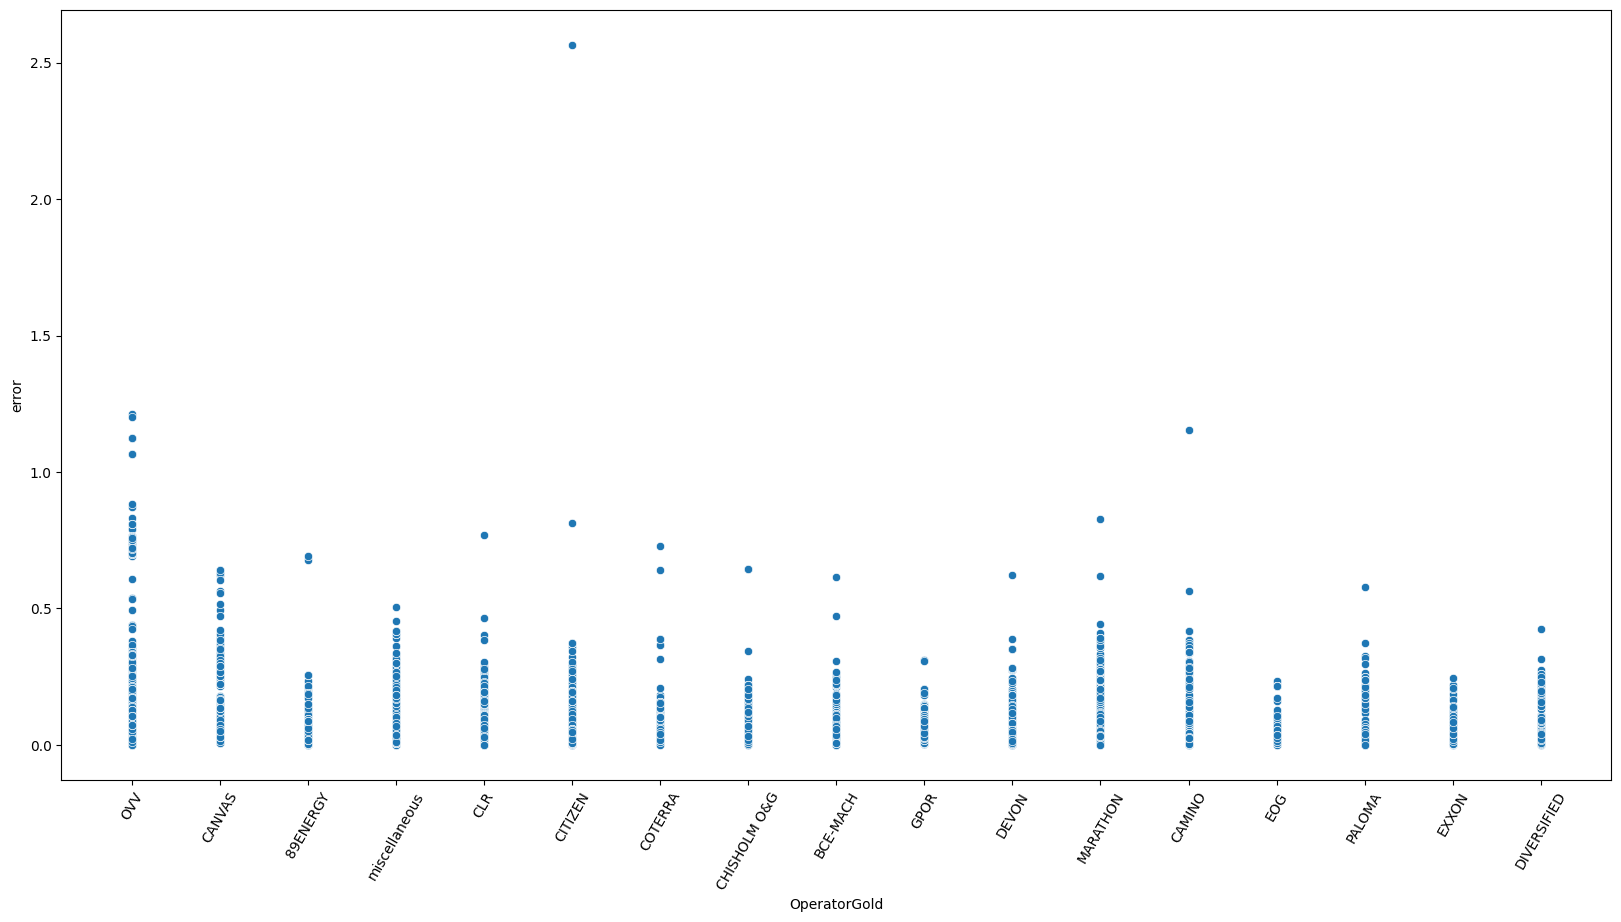

In [138]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.scatterplot(data=df_t, x="OperatorGold", y="error")
ax.tick_params(axis='x', rotation=60)


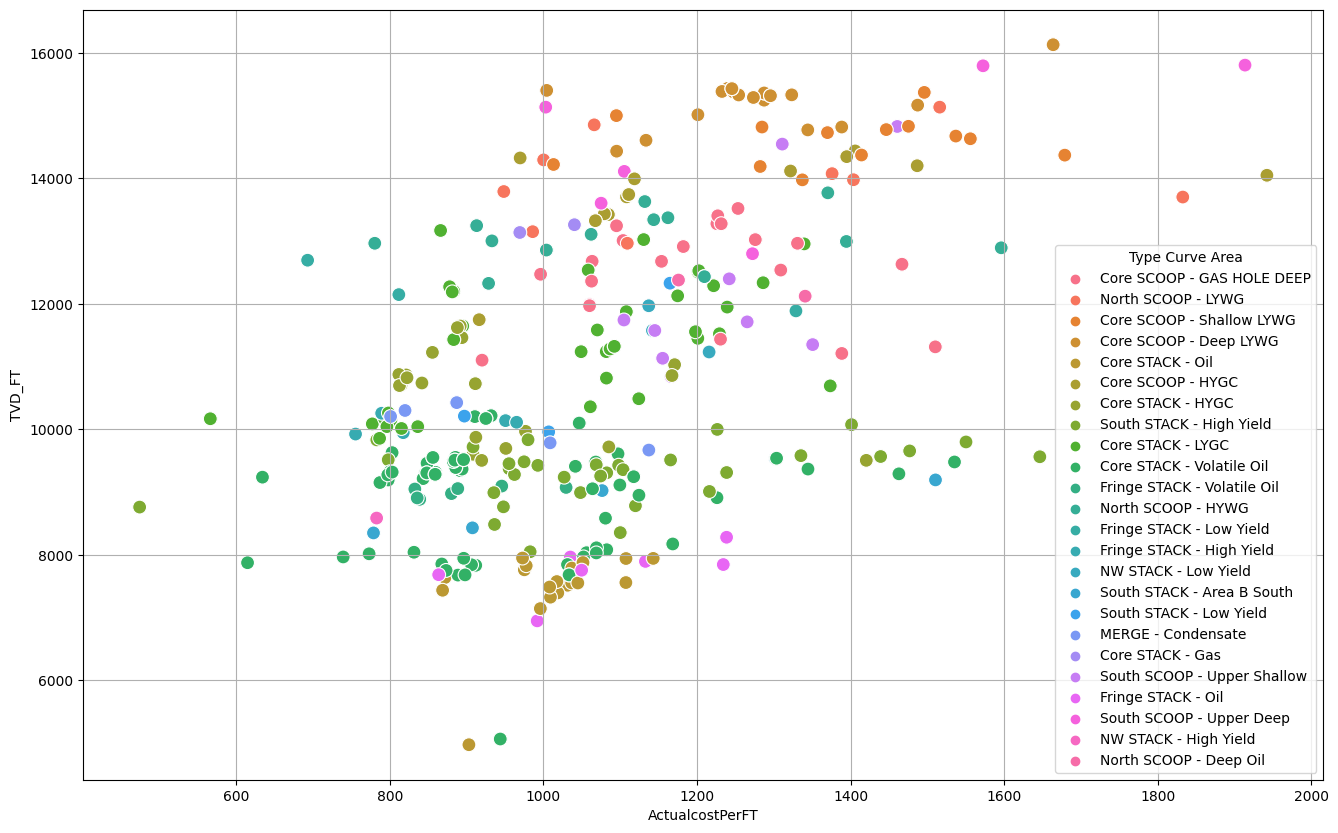

In [98]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "MARATHON"], x ="ActualcostPerFT", y ="TVD_FT", hue= "Type Curve Area", s=100)

#plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim([250, 2500])
#plt.ylim([250, 2500])
plt.grid()

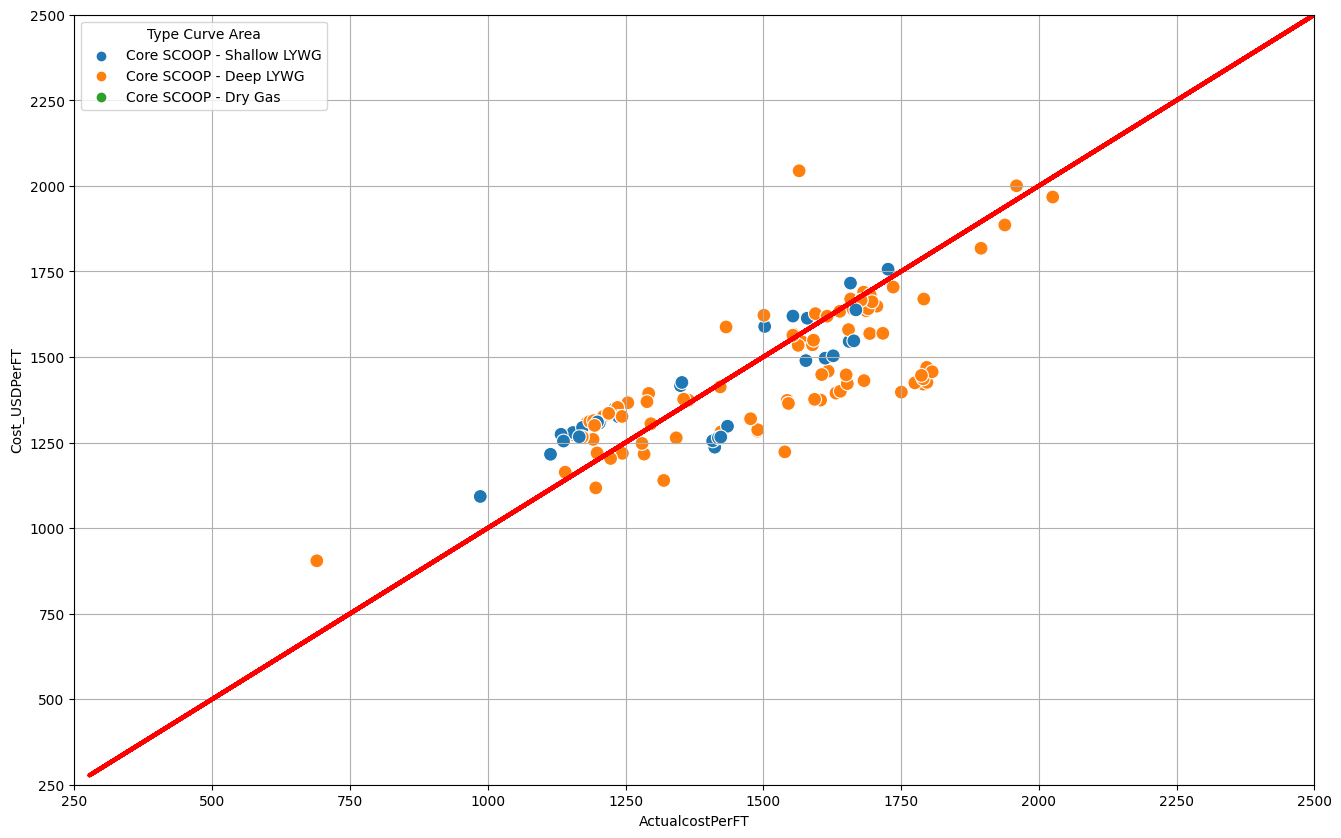

In [87]:
#conpare cost_USDPerFT and ActualCostPerFT for Canvas
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["OperatorGold"] == "GPOR"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "Type Curve Area", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
plt.xlim([250, 2500])
plt.ylim([250, 2500])
plt.grid()

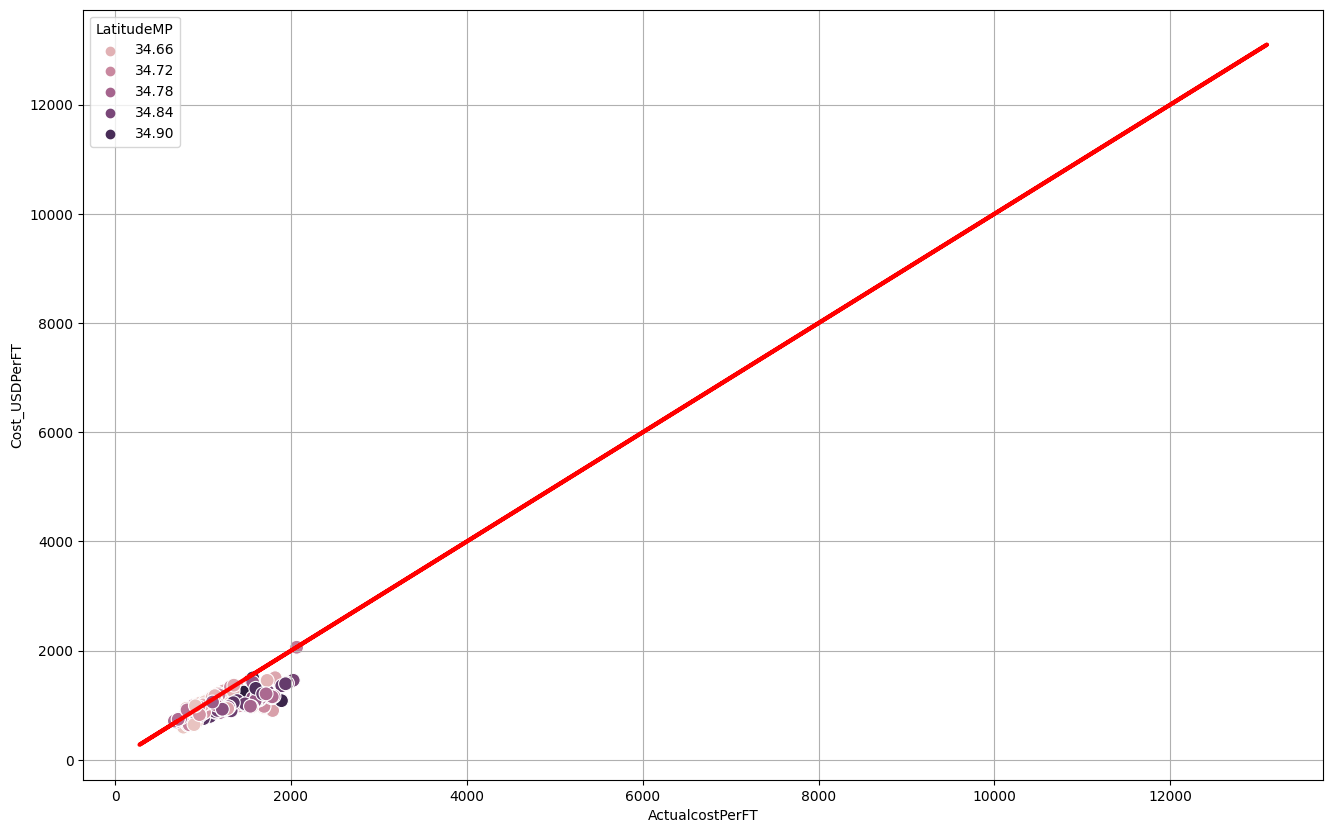

In [62]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Core SCOOP - Deep LYWG"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "LatitudeMP", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xlim([4, 16])
# plt.ylim([4, 16])
plt.grid()

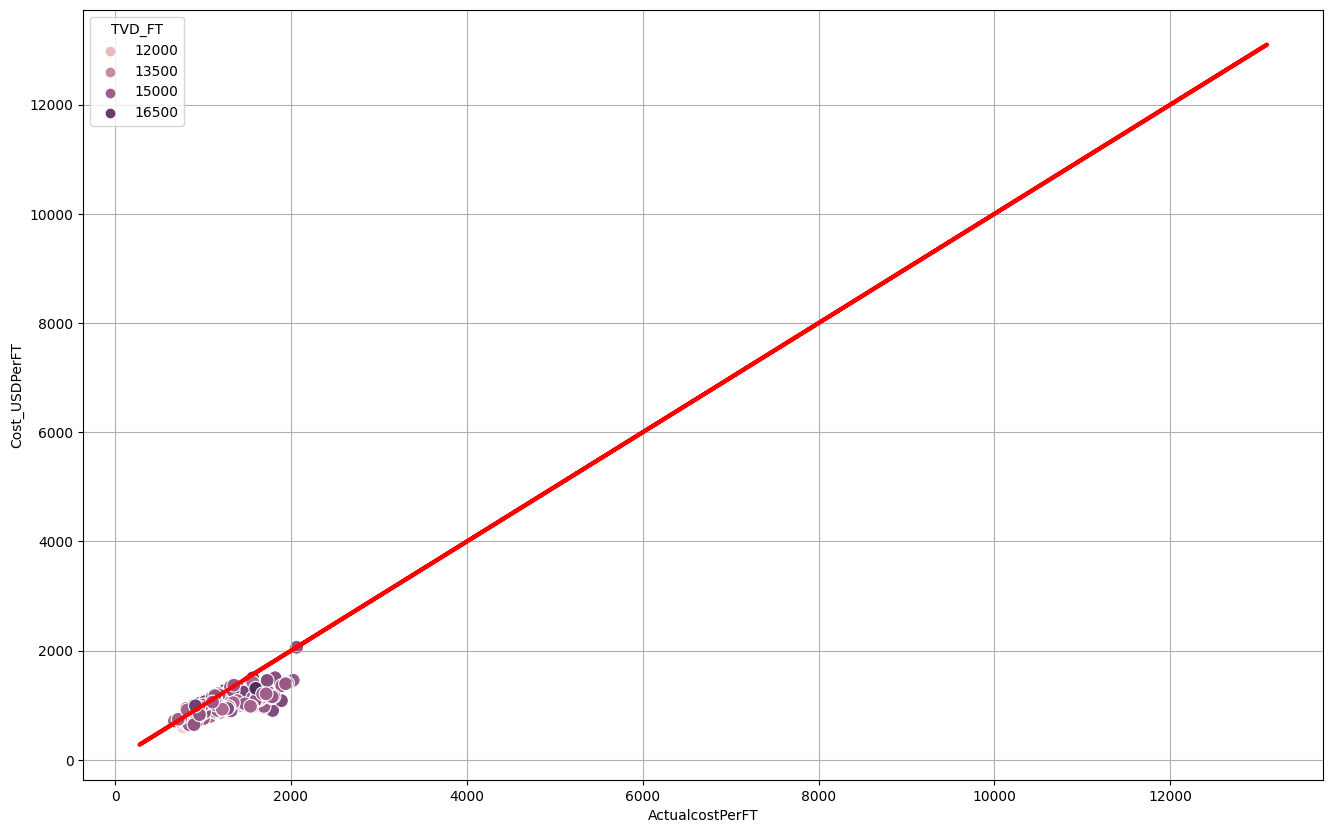

In [63]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Core SCOOP - Deep LYWG"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "TVD_FT", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xlim([4, 16])
# plt.ylim([4, 16])
plt.grid()

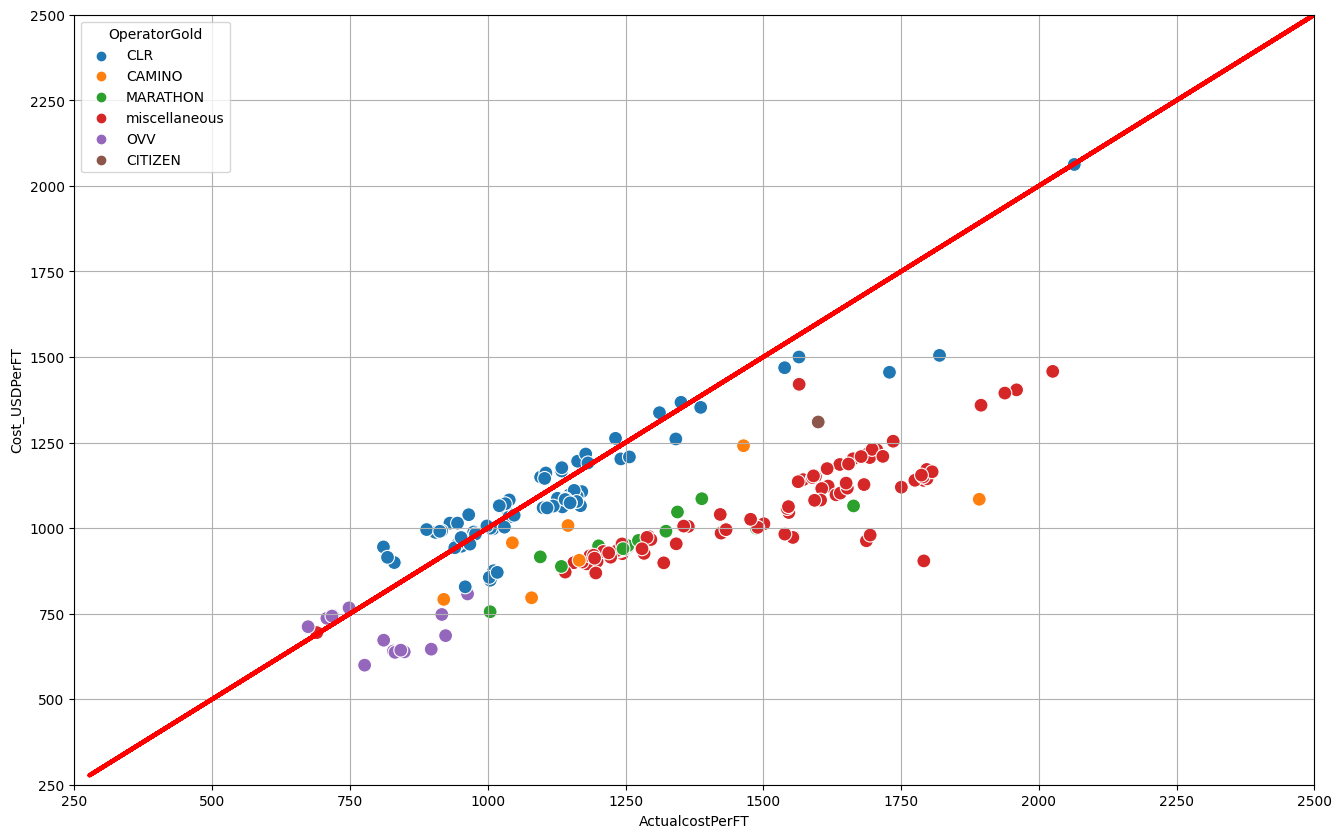

In [64]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Core SCOOP - Deep LYWG"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue= "OperatorGold", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
plt.xlim([250, 2500])
plt.ylim([250, 2500])
plt.grid()

In [65]:
import plotly.express as px

In [95]:
df.OperatorGold.value_counts()

OVV                 852
CLR                 725
CITIZEN             512
DEVON               462
BCE-MACH            453
MARATHON            323
EXXON               256
CANVAS              207
COTERRA             197
CAMINO              177
CHISHOLM O&G        167
DIVERSIFIED         144
PALOMA              129
89ENERGY            120
GPOR                112
EOG                  84
COMANCHE             74
FORMENTERA           63
STAGHORN             57
REVOLUTION           55
SD                   54
CRAWLEY              35
TAMWORTH             25
LIME ROCK            24
DERBY                21
RIMROCK              20
SAND CREEK           19
RED ROCKS            15
WARWICK              15
CHARTER OAK          13
CITATION             11
US ENERGY            11
HINKLE                7
INTERSTATE            7
CHEYENNE              7
TRP                   5
PRIDE                 5
KINGERY               5
BLACK MESA            4
NORTHLAKE             4
TRIAD                 3
ATLAS           

In [96]:
final_df.OperatorGold.value_counts()

OVV              1001
miscellaneous     907
CLR               842
CITIZEN           558
DEVON             553
BCE-MACH          461
MARATHON          392
COTERRA           239
CAMINO            208
CANVAS            189
CHISHOLM O&G      155
DIVERSIFIED       100
EXXON              73
Name: OperatorGold, dtype: int64

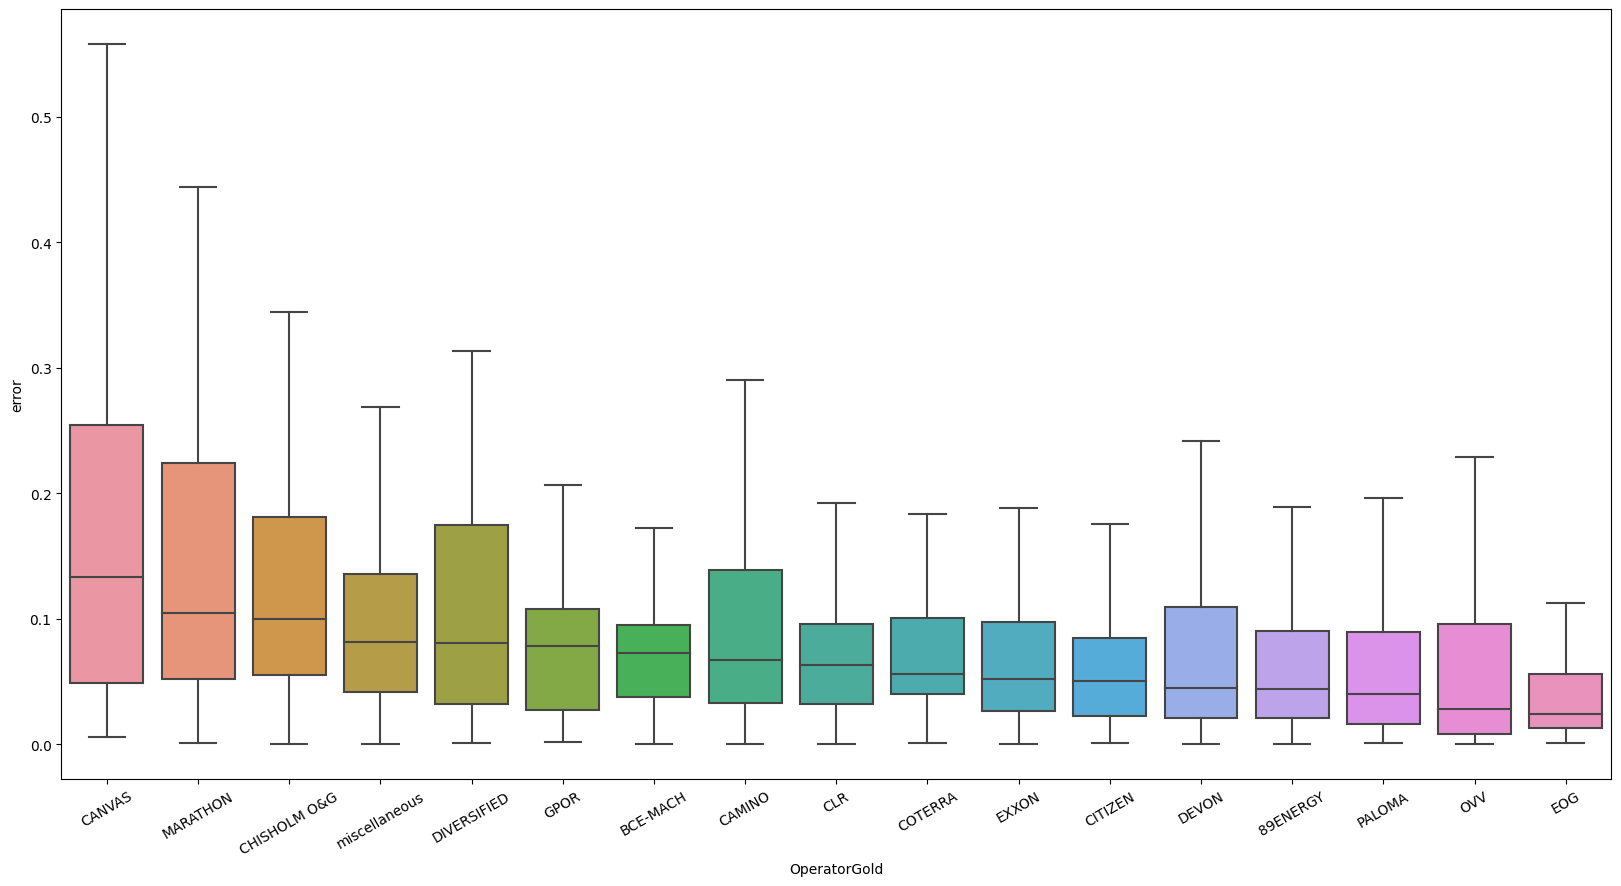

In [101]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="OperatorGold", y="error", showfliers=False, order=df_t.groupby("OperatorGold")["error"].median().sort_values(ascending=False).index)
ax.tick_params(axis='x', rotation=30)

# plt.ylim([])

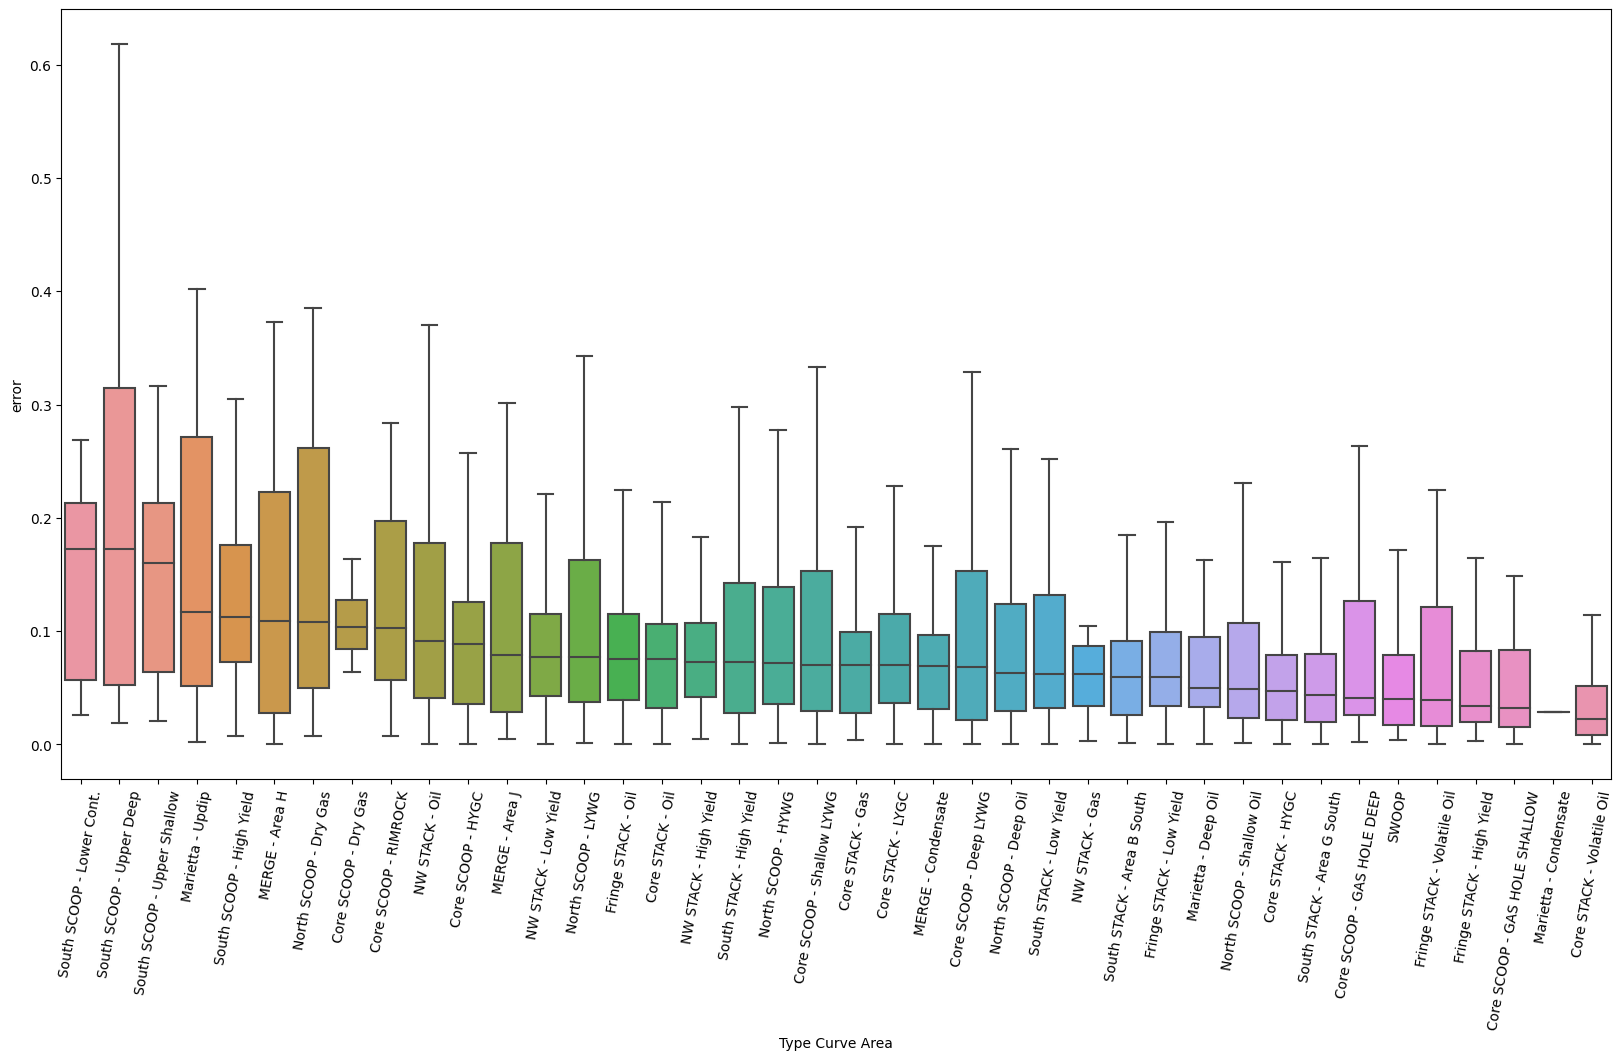

In [131]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="Type Curve Area", y="error", showfliers=False, order=df_t.groupby("Type Curve Area")["error"].median().sort_values(ascending=False).index)
ax.tick_params(axis='x', rotation=80)

# plt.ylim([])

In [147]:
df_t[df_t["Type Curve Area"].str.contains('SCOOP')]["Type Curve Area"].value_counts()

North SCOOP - Deep Oil           231
Core SCOOP - Shallow LYWG        219
Core SCOOP - Deep LYWG           196
Core SCOOP - HYGC                152
North SCOOP - Shallow Oil        143
Core SCOOP - GAS HOLE DEEP       109
North SCOOP - HYWG               102
North SCOOP - LYWG                91
South SCOOP - High Yield          58
Core SCOOP - RIMROCK              32
Core SCOOP - GAS HOLE SHALLOW     30
South SCOOP - Upper Shallow       29
South SCOOP - Lower Cont.         21
North SCOOP - Dry Gas             15
South SCOOP - Upper Deep          14
Core SCOOP - Dry Gas               4
Name: Type Curve Area, dtype: int64

In [148]:
df_t[df_t["Type Curve Area"].str.contains('SCOOP')]["ReservoirGoldConsolidated"].value_counts()

WOODFORD         1246
MISSISSIPPIAN     200
Name: ReservoirGoldConsolidated, dtype: int64

In [151]:
df_t[df_t["Type Curve Area"].str.contains('SCOOP')].groupby(['Type Curve Area','ReservoirGoldConsolidated']).size()

Type Curve Area                ReservoirGoldConsolidated
Core SCOOP - Deep LYWG         MISSISSIPPIAN                  5
                               WOODFORD                     191
Core SCOOP - Dry Gas           WOODFORD                       4
Core SCOOP - GAS HOLE DEEP     MISSISSIPPIAN                 23
                               WOODFORD                      86
Core SCOOP - GAS HOLE SHALLOW  MISSISSIPPIAN                  9
                               WOODFORD                      21
Core SCOOP - HYGC              MISSISSIPPIAN                  9
                               WOODFORD                     143
Core SCOOP - RIMROCK           MISSISSIPPIAN                  4
                               WOODFORD                      28
Core SCOOP - Shallow LYWG      MISSISSIPPIAN                 16
                               WOODFORD                     203
North SCOOP - Deep Oil         MISSISSIPPIAN                 34
                               WOODFORD        

In [141]:
df_t[df_t["Type Curve Area"]=='South SCOOP - Lower Cont.']['OperatorGold'].value_counts()

CLR              13
EXXON             4
miscellaneous     4
Name: OperatorGold, dtype: int64

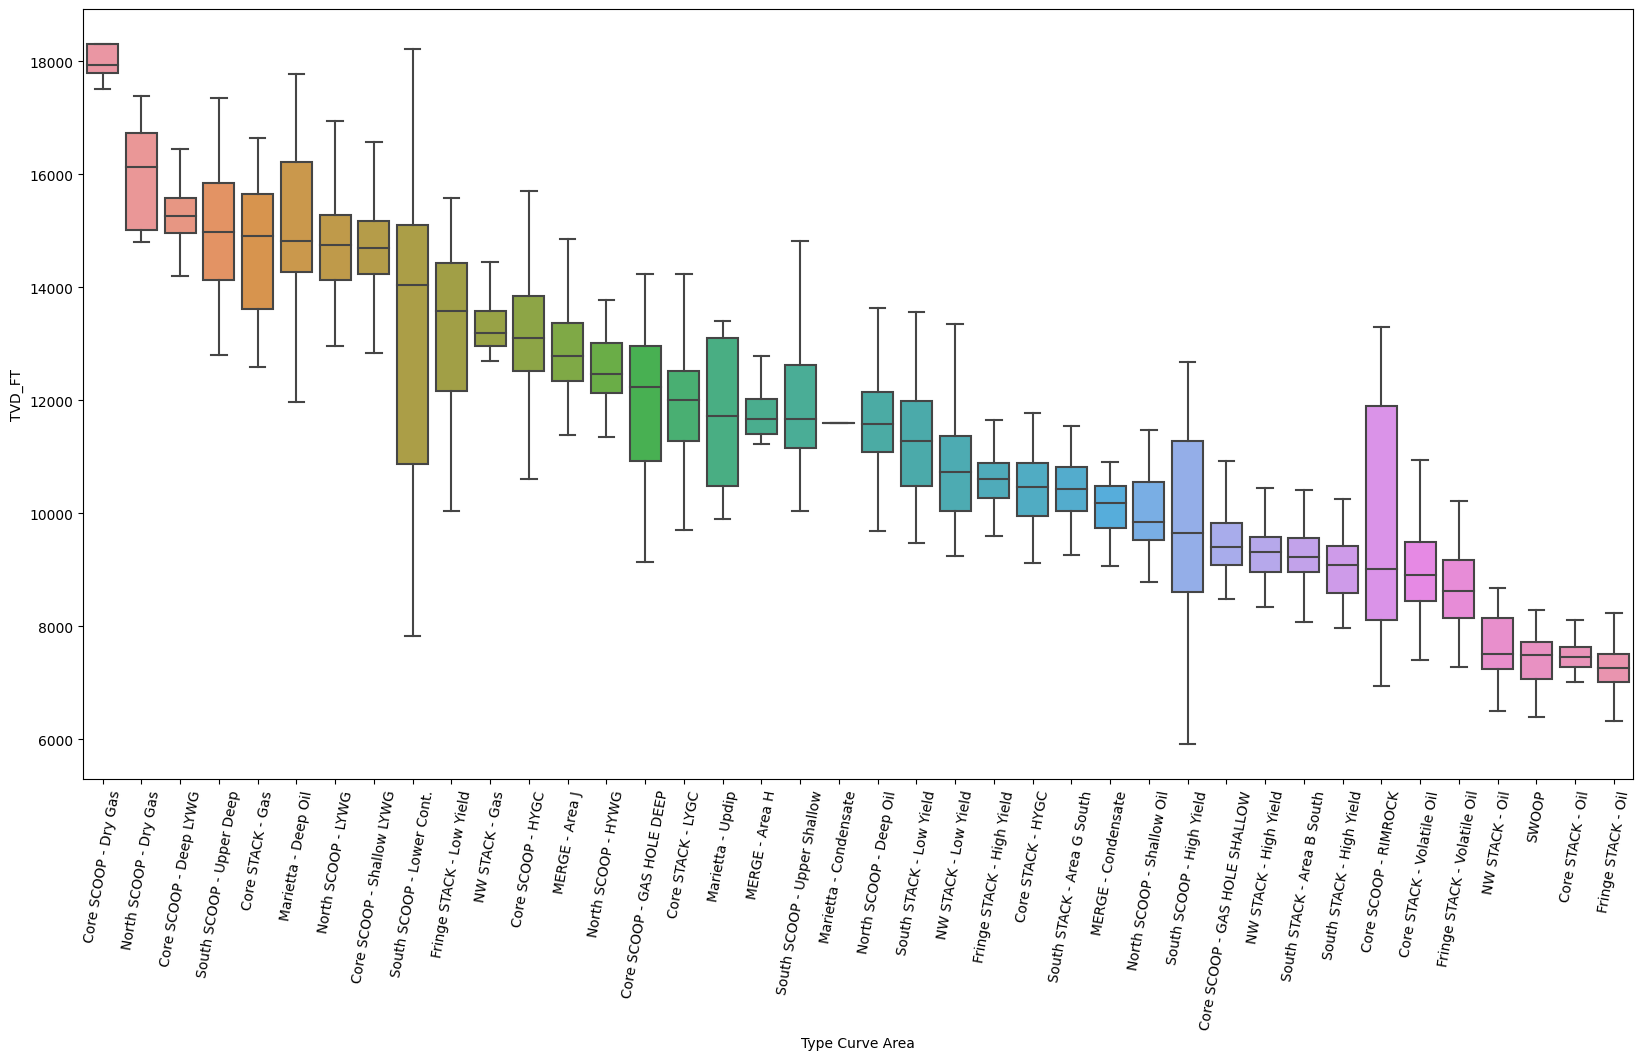

In [133]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="Type Curve Area", y="TVD_FT", showfliers=False, order=df_t.groupby("Type Curve Area")["TVD_FT"].median().sort_values(ascending=False).index)
ax.tick_params(axis='x', rotation=80)


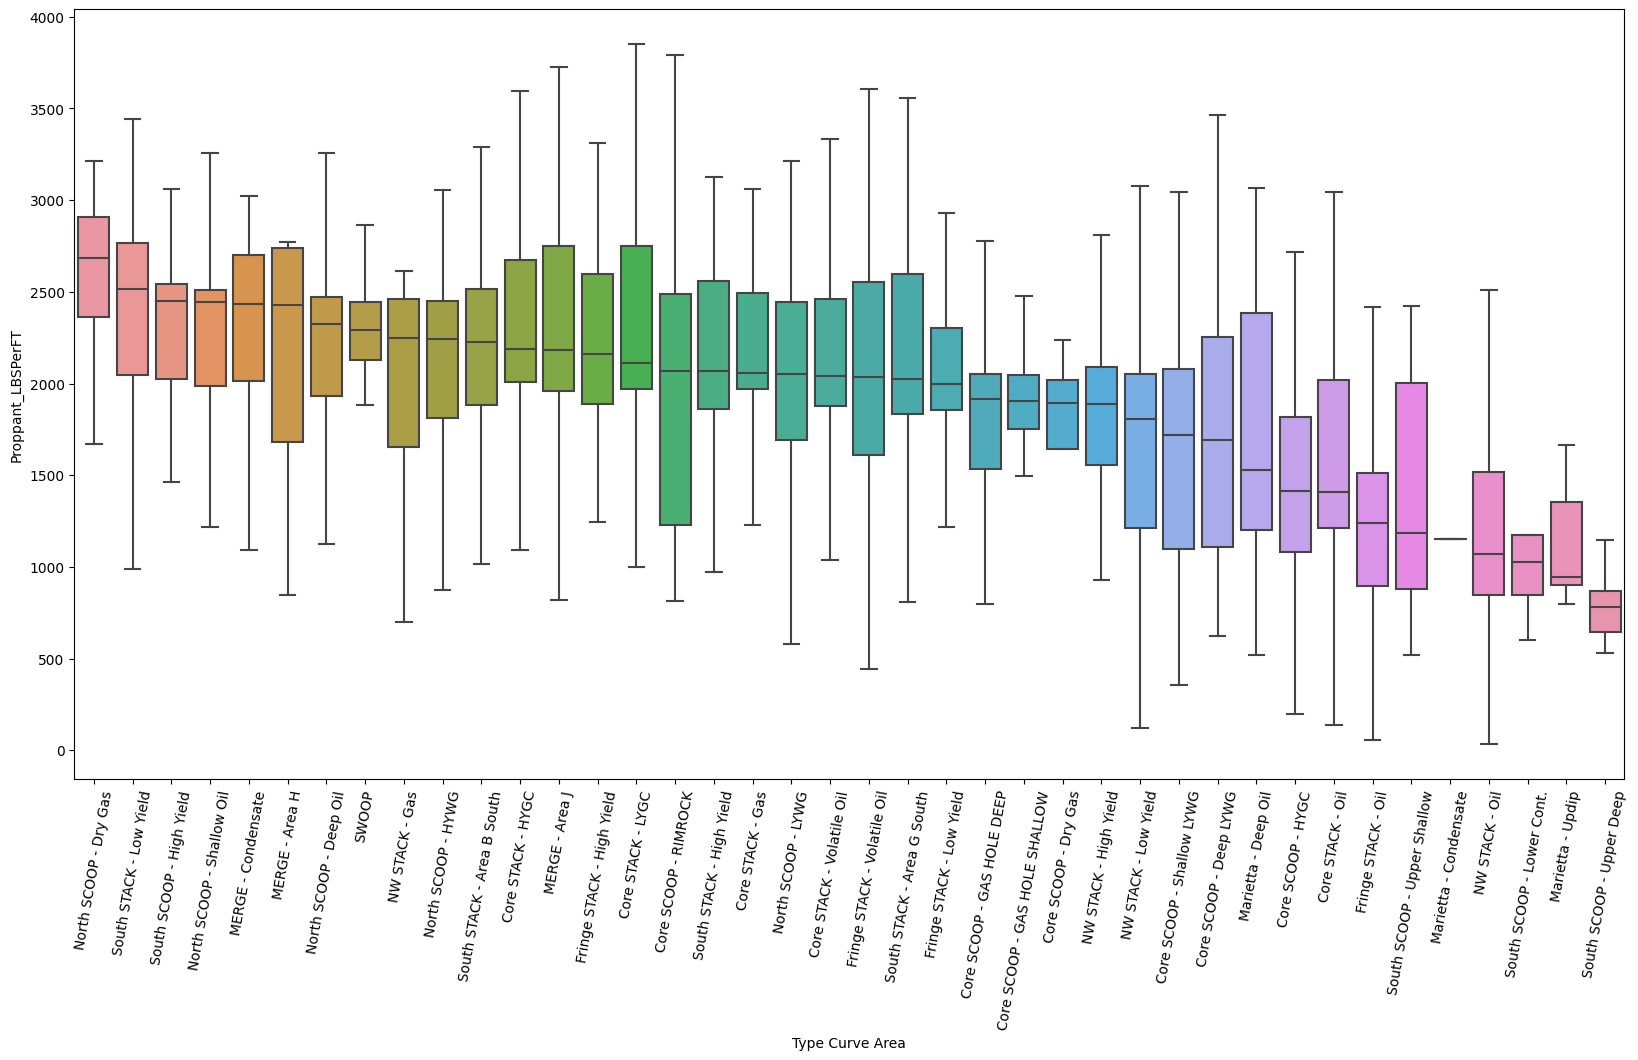

In [135]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="Type Curve Area", y="Proppant_LBSPerFT", showfliers=False, order=df_t.groupby("Type Curve Area")["Proppant_LBSPerFT"].median().sort_values(ascending=False).index)
ax.tick_params(axis='x', rotation=80)

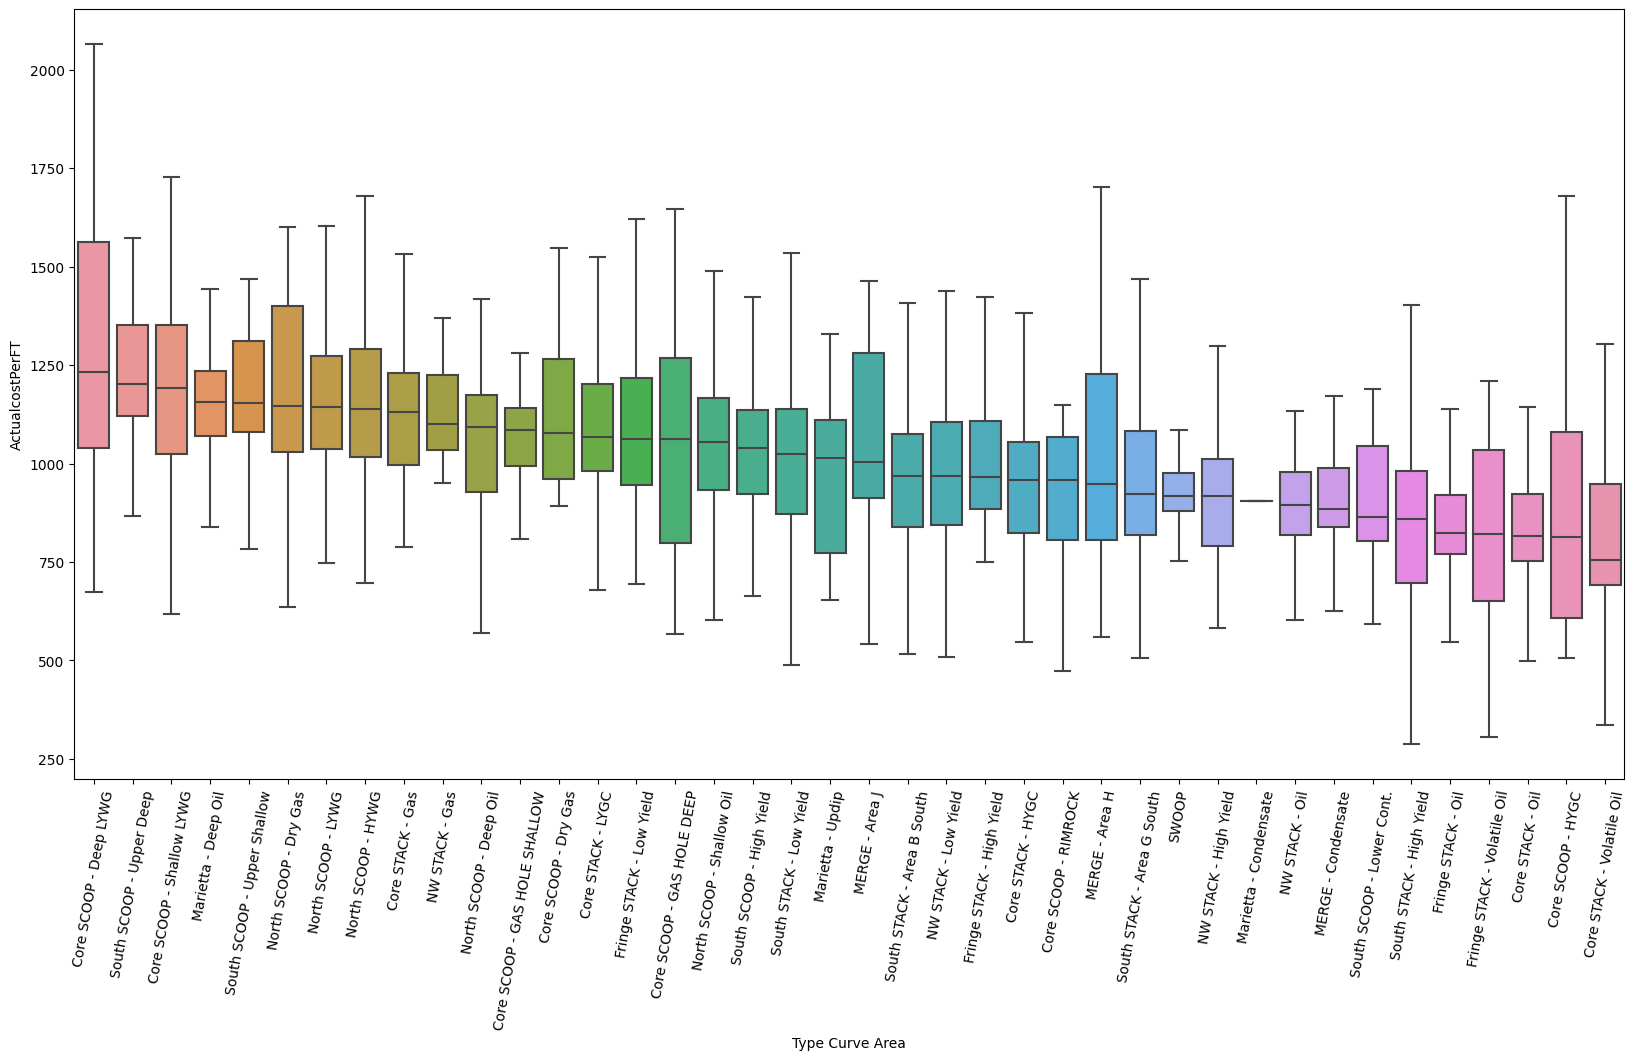

In [136]:
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="Type Curve Area", y="ActualcostPerFT", showfliers=False, order=df_t.groupby("Type Curve Area")["ActualcostPerFT"].median().sort_values(ascending=False).index)
ax.tick_params(axis='x', rotation=80)

# plt.ylim([])

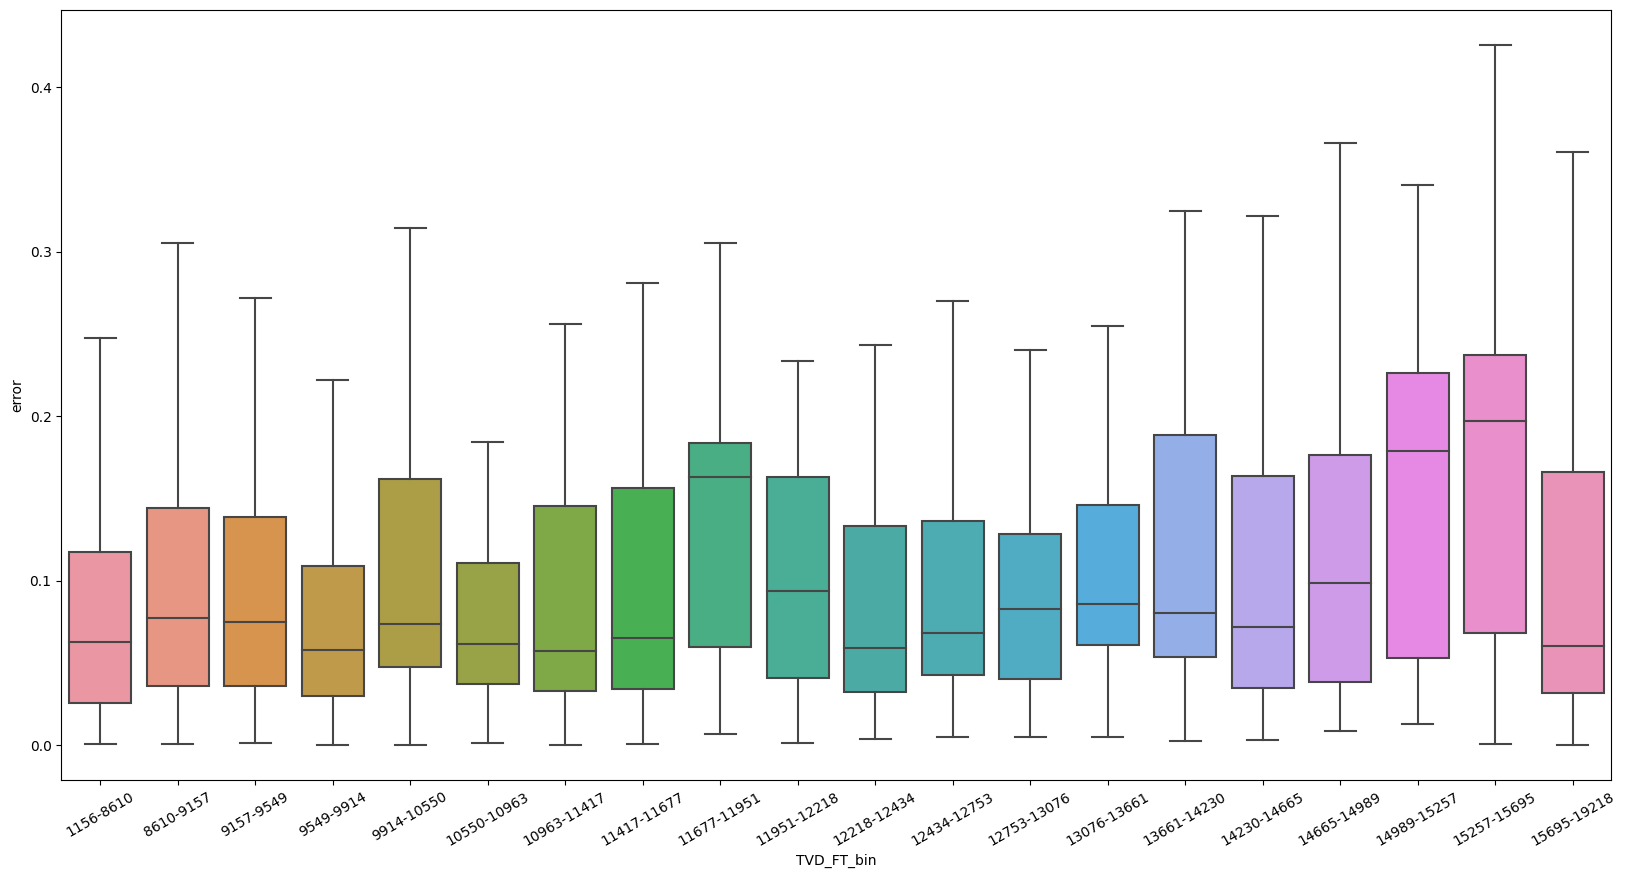

In [40]:
# Create P1 to P99 bins of TVD_FT and plot these bins of TVD with error
df_t["TVD_FT_bin"], bins = pd.qcut(df_t["TVD_FT"], 20, labels=False, retbins=True)
fig, ax = plt.subplots(figsize=(20, 10))
# plot sns boxplot without outliers and order by median of each group
sns.boxplot(data=df_t, x="TVD_FT_bin", y="error", showfliers=False) 

# set bins as tick labels
ax.set_xticklabels([f"{int(bins[i - 1])}-{int(bins[i])}" for i in range(1, len(bins))])
ax.tick_params(axis='x', rotation=30)


(0.0, 0.6)

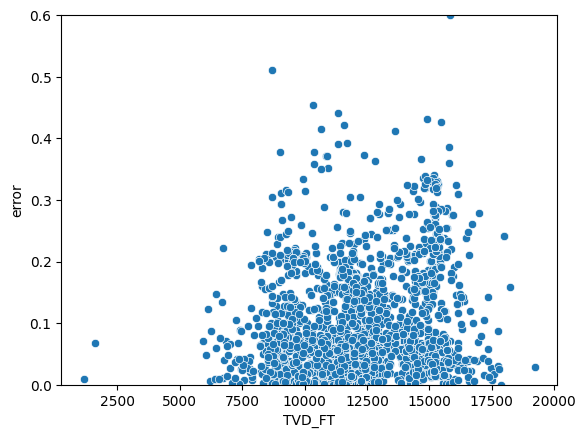

In [41]:
sns.scatterplot(data=df_t, x="TVD_FT", y="error")
plt.ylim([0, 0.6])

In [42]:
px.scatter(df_t[df_t["Type Curve Area"] == "Core SCOOP - Deep LYWG"], x="LongitudeMP", y="LatitudeMP", color="error", size="TVD_FT", hover_data=["ActualcostPerFT", "Cost_USDPerFT"], width=1600, height=900)

NameError: name 'px' is not defined

<AxesSubplot: xlabel='ActualcostPerFT', ylabel='Cost_USDPerFT'>

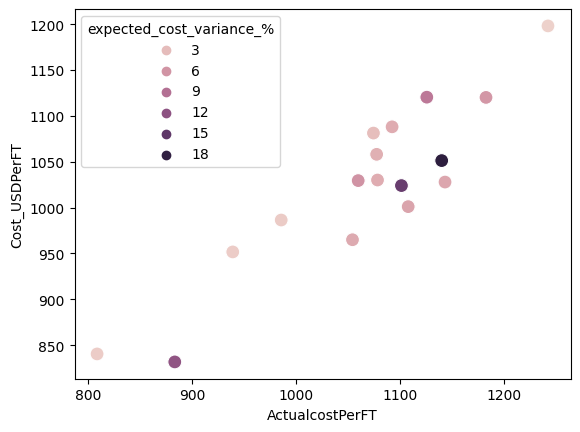

In [43]:
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Core SCOOP - GAS HOLE SHALLOW"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue="expected_cost_variance_%", s=100)


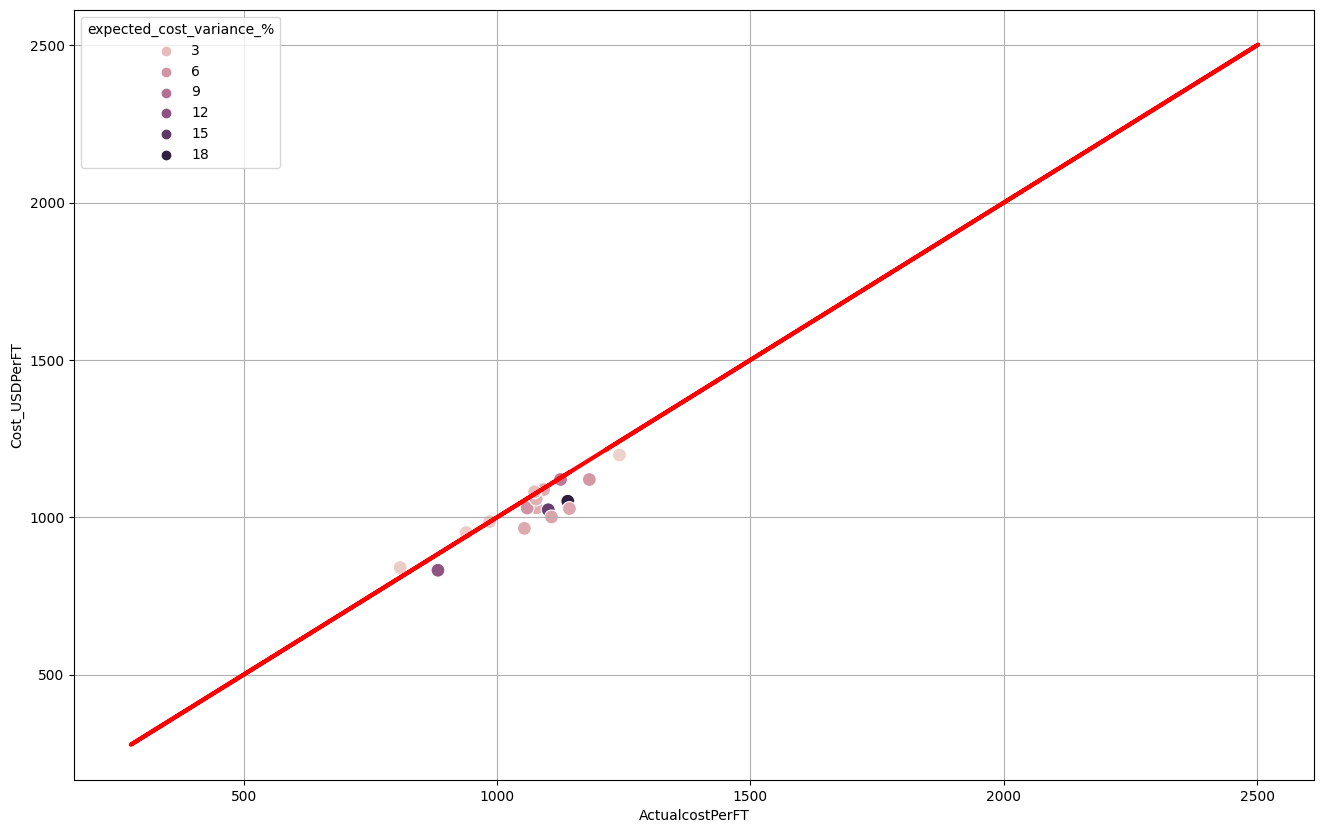

In [44]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Core SCOOP - GAS HOLE SHALLOW"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue="expected_cost_variance_%", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xlim([4, 16])
# plt.ylim([4, 16])
plt.grid()

In [70]:
def plot_cost(df, type_curve, actual_cost, predicted_cost, axes):
  sns.scatterplot(data=df[df["Type Curve Area"] == type_curve], x =actual_cost, y =predicted_cost, hue="OperatorGold", s=100, ax=axes)
  axes.plot(df[actual_cost].values, df[actual_cost].values, color='red', linewidth=3)
  axes.set_title(type_curve)
  axes.grid(True)
  axes.set_xlim(100, 2500)
  axes.set_ylim(100, 2500)
 

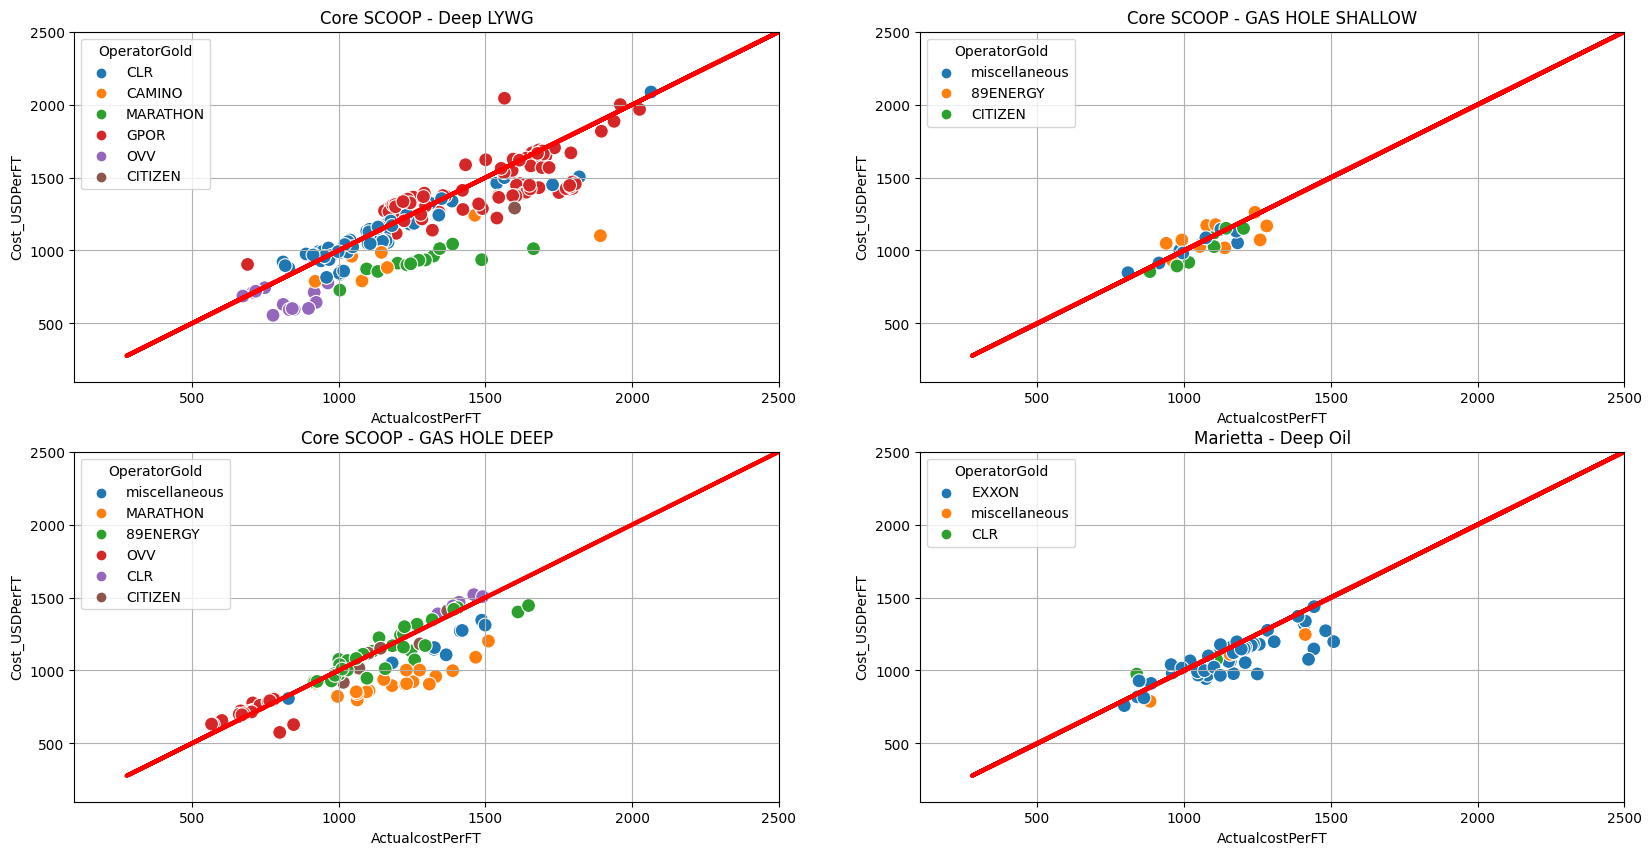

In [86]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_cost(df_t, "Core SCOOP - Deep LYWG", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 0])
plot_cost(df_t, "Core SCOOP - GAS HOLE SHALLOW", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 1])
plot_cost(df_t, "Core SCOOP - GAS HOLE DEEP", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 0])
plot_cost(df_t, "Marietta - Deep Oil", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 1])


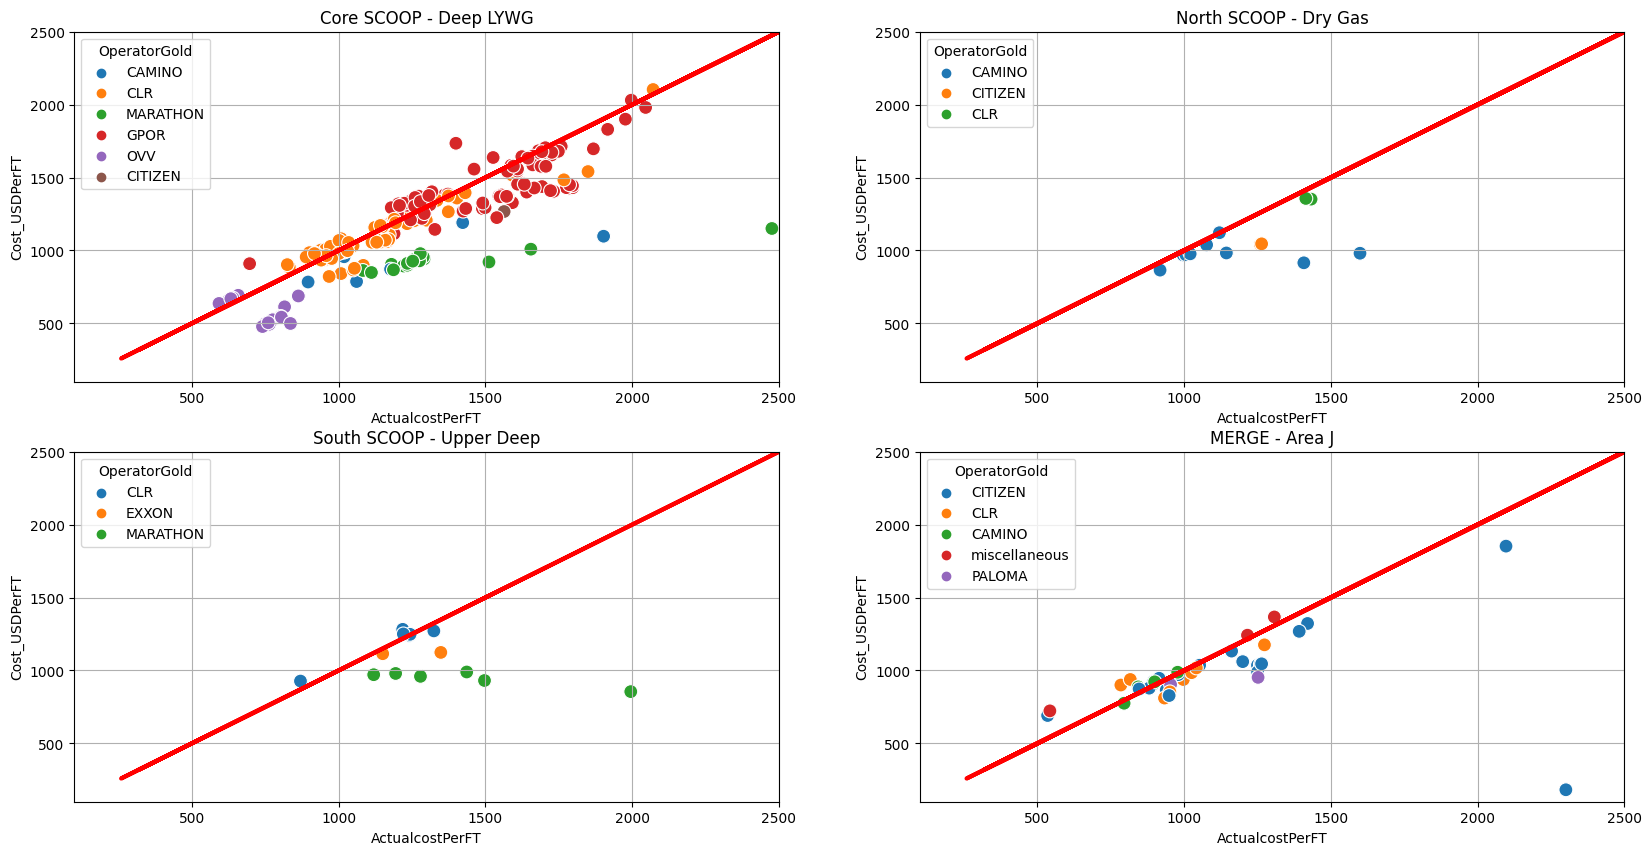

In [74]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_cost(df_t, "Core SCOOP - Deep LYWG", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 0])
plot_cost(df_t, "North SCOOP - Dry Gas", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 1])
plot_cost(df_t, "South SCOOP - Upper Deep", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 0])
plot_cost(df_t, "MERGE - Area J", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 1])
#plot_cost(df_t, "South STACK - Area B South", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 1])


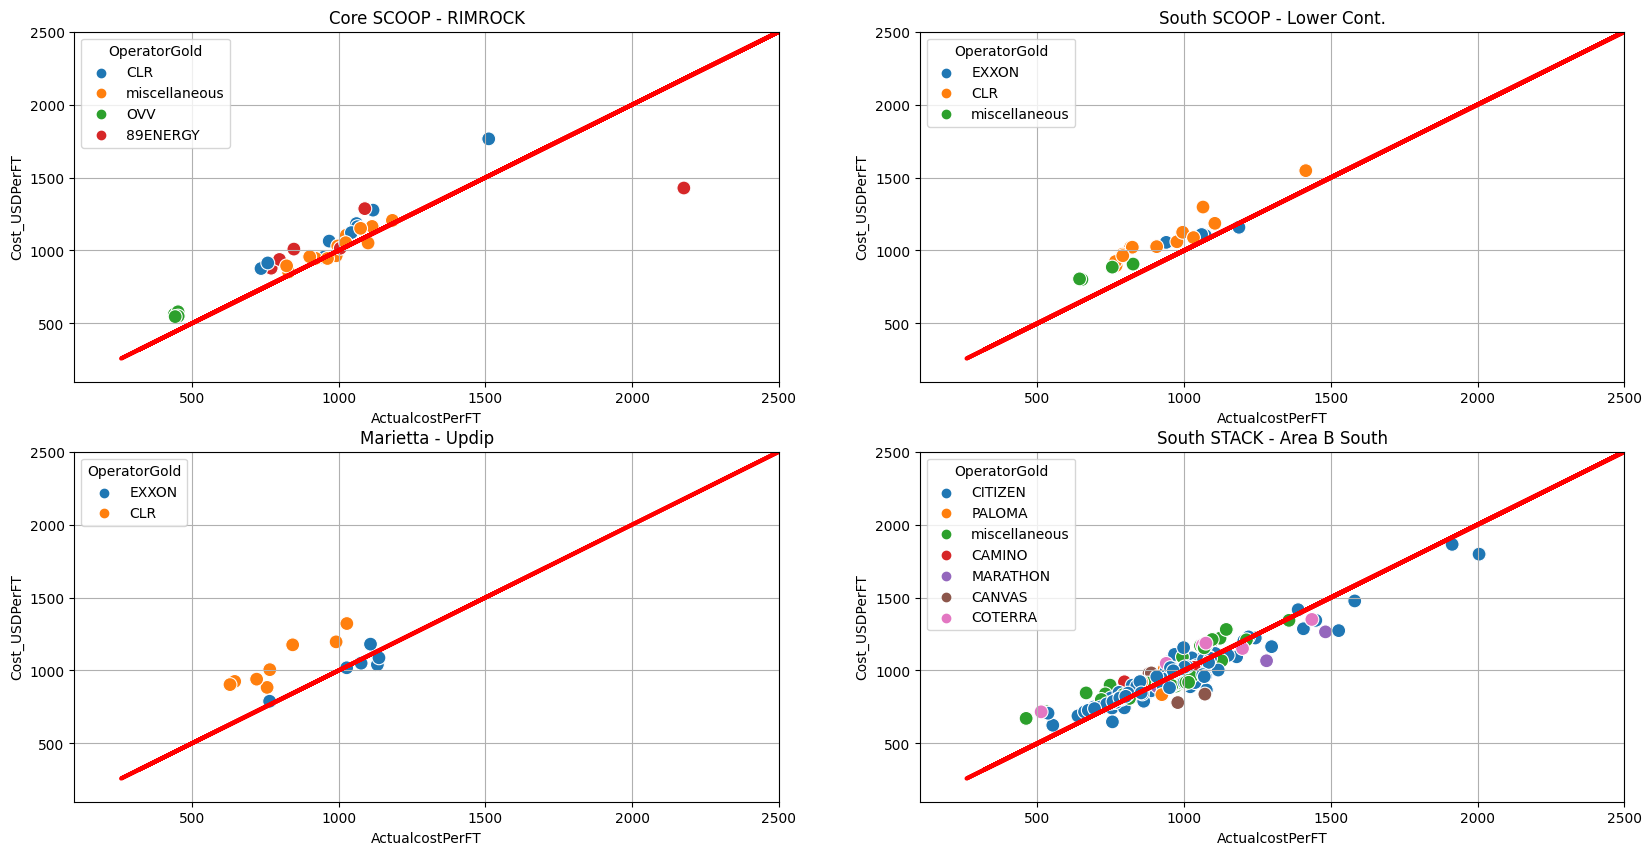

In [75]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_cost(df_t, "Core SCOOP - RIMROCK", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 0])
plot_cost(df_t, "South SCOOP - Lower Cont.", "ActualcostPerFT", "Cost_USDPerFT", ax[0, 1])
plot_cost(df_t, "Marietta - Updip", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 0])
#plot_cost(df_t, "MERGE - Area J", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 1])
plot_cost(df_t, "South STACK - Area B South", "ActualcostPerFT", "Cost_USDPerFT", ax[1, 1])


In [ ]:
final_df["Type Curve Area"]=="North SCOOP -Dry GAS"

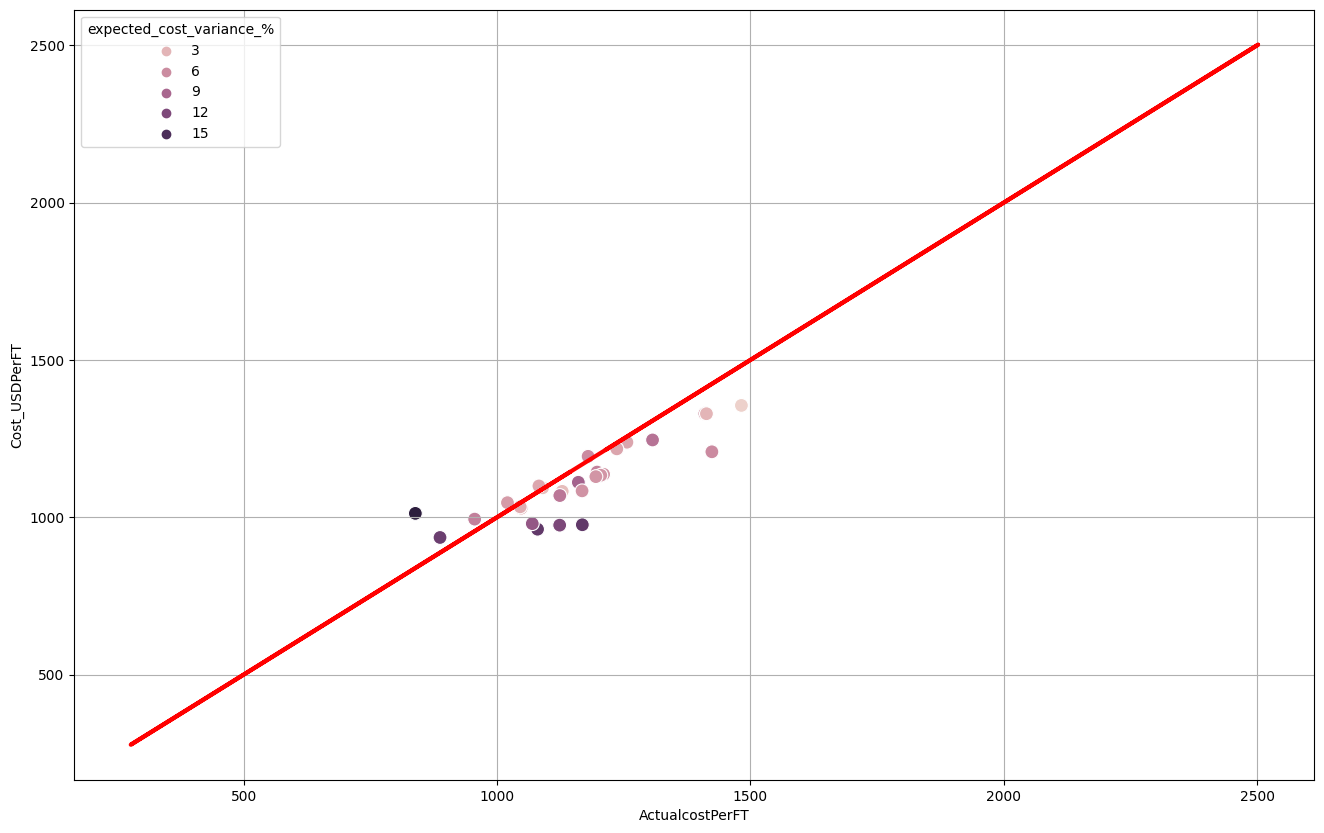

In [56]:
#conpare cost_USDPerFT and ActualCostPerFT for Core SCOOP - Deep LYWG type curve area
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=df_t[df_t["Type Curve Area"] == "Marietta - Deep Oil"], x ="ActualcostPerFT", y ="Cost_USDPerFT", hue="expected_cost_variance_%", s=100)

plt.plot(df_t["ActualcostPerFT"].values, df_t["ActualcostPerFT"].values, color='red', linewidth=3)
# plt.xlim([4, 16])
# plt.ylim([4, 16])
plt.grid()